# Crop Yield Prediction - Deep Learning

We pass seasonal time series of WOFOST, weather and FAPAR to 1DCNN or LSTM layers to extract features from them. Learned seasonal features, yield trend features (yield values of 5 previous years) and static features are passed to the output layer.

We run feature attribution methods from Captum to extract feature importance.

In [ ]:
test_env = 'notebook'
if (test_env == 'notebook'):
  !pip install d2l==0.16.1 >/dev/null
  !pip install captum >/dev/null
  ! pip install geopandas > /dev/null

  from d2l import torch as d2l
  import numpy as np
  import torch
  from torch import nn
  import pandas as pd
  import matplotlib.pyplot as plt
  %matplotlib inline
  plt.rcParams['figure.figsize'] = [30,25]
  plt.rcParams.update({'font.size': 12})

  !pip install pyspark > /dev/null
  !sudo apt update > /dev/null
  !apt-get install openjdk-8-jdk-headless -qq > /dev/null
  !pip install joblibspark > /dev/null

  import os
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
else:  
  import findspark
  findspark.init()

import pyspark
from pyspark.sql import functions as SparkF
from pyspark.sql import types as SparkT

from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

SparkContext.setSystemProperty('spark.executor.memory', '12g')
SparkContext.setSystemProperty('spark.driver.memory', '6g')
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

# crop name to id mapping
crop_id_dict = {
    'grain maize': 2,
    'sugar beet' : 6,
    'sugarbeet' : 6,
    'sugarbeets' : 6,
    'sugar beets' : 6,
    'total potatoes' : 7,
    'potatoes' : 7,
    'potato' : 7,
    'winter wheat' : 90,
    'soft wheat' : 90,
    'sunflower' : 93,
    'spring barley' : 95,
}

# crop id to name mapping
crop_name_dict = {
    2 : 'grain maize',
    6 : 'sugarbeet',
    7 : 'potatoes',
    90 : 'soft wheat',
    93 : 'sunflower',
    95 : 'spring barley',
}

## Utility Functions

In [ ]:
import sklearn
from sklearn.metrics import mean_squared_error

import captum
from captum.attr import Occlusion
from captum.attr import IntegratedGradients
from captum.attr import DeepLift
from captum.attr import DeepLiftShap
from captum.attr import GradientShap

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import pandas as pd

# crop name and id mappings
def cropNameToID(crop_id_dict, crop):
  """
  Return id of given crop. Relies on crop_id_dict.
  Return 0 if crop name is not in the dictionary.
  """
  crop_lcase = crop.lower()
  try:
    crop_id = crop_id_dict[crop_lcase]
  except KeyError as e:
    crop_id = 0

  return crop_id

def cropIDToName(crop_name_dict, crop_id):
  """
  Return crop name for given crop ID. Relies on crop_name_dict.
  Return 'NA' if crop id is not found in the dictionary.
  """
  try:
    crop_name = crop_name_dict[crop_id]
  except KeyError as e:
    crop_name = 'NA'

  return crop_name

def getYear(date_str):
  """Extract year from date in yyyyMMdd or dd/MM/yyyy format."""
  return SparkF.when(SparkF.length(date_str) == 8,
                     SparkF.year(SparkF.to_date(date_str, 'yyyyMMdd')))\
                     .otherwise(SparkF.year(SparkF.to_date(date_str, 'dd/MM/yyyy')))

def getMonth(date_str):
  """Extract month from date in yyyyMMdd or dd/MM/yyyy format."""
  return SparkF.when(SparkF.length(date_str) == 8,
                     SparkF.month(SparkF.to_date(date_str, 'yyyyMMdd')))\
                     .otherwise(SparkF.month(SparkF.to_date(date_str, 'dd/MM/yyyy')))

def getDay(date_str):
  """Extract day from date in yyyyMMdd or dd/MM/yyyy format."""
  return SparkF.when(SparkF.length(date_str) == 8,
                     SparkF.dayofmonth(SparkF.to_date(date_str, 'yyyyMMdd')))\
                     .otherwise(SparkF.dayofmonth(SparkF.to_date(date_str, 'dd/MM/yyyy')))

# 1-10: Dekad 1
# 11-20: Dekad 2
# > 20 : Dekad 3
def getDekad(date_str):
  """Extract dekad from date in YYYYMMDD format."""
  month = getMonth(date_str)
  day = getDay(date_str)
  return SparkF.when(day < 30, (month - 1)* 3 +
                     SparkF.ceil(day/10)).otherwise((month - 1) * 3 + 3)

def getFilename(crop, yield_trend, early_season_end,
                country=None, nuts_level=None, architecture=None):
  """Get filename based on input arguments"""
  filename = crop.replace(' ', '_')

  if (country is not None):
    filename += '_' + country

  if (nuts_level is not None):
    filename += '_' + nuts_level

  if (yield_trend):
    filename += '_trend'
  else:
    filename += '_notrend'

  if (early_season_end < 0):
    filename += '_early' + str(early_season_end)

  if (architecture is not None):
    filename += '-' + architecture

  return filename

def getLogFilename(crop, yield_trend, early_season_end,
                   country=None, nuts_level=None, architecture=None):
  """Get filename for experiment log"""
  log_file = getFilename(crop, yield_trend, early_season_end, country,
                         nuts_level, architecture)
  return log_file + '.log'

def getPredictionFilename(crop, yield_trend, early_season_end,
                          country=None, nuts_level=None, architecture=None):
  """Get unique filename for predictions"""
  pred_file = 'pred_'
  suffix = getFilename(crop, yield_trend, early_season_end, country,
                       nuts_level, architecture)
  pred_file += suffix
  return pred_file

def getFeatureImportanceFilename(crop, yield_trend, early_season_end,
                                 country=None, nuts_level=None, architecture=None):
  ft_import_file = 'import_'
  suffix = getFilename(crop, yield_trend, early_season_end, country,
                       nuts_level, architecture)
  return ft_import_file + suffix

def printConfig(cyp_config, log_fh=None):
  config_str = '\nCurrent DL Configuration'
  config_str += '\n-------------------------'
  for k in cyp_config:
    conf_val = cyp_config[k]
    if (not isinstance(conf_val, str)):
      conf_val = str(conf_val)

    config_str += '\n' + k + ': ' + conf_val

  config_str += '\n'
  if (log_fh is not None):
    log_fh.write(config_str)

  print(config_str)

def printPreprocessingInformation(df, data_source, order_cols, crop_season=None):
  """Print preprocessed data and additional debug information"""
  df_regions = [reg[0] for reg in df.select('IDREGION').distinct().collect()]
  print(data_source , 'data available for', len(df_regions), 'region(s)')
  if (crop_season is not None):
    print('Season end information')
    crop_season.orderBy(['IDREGION', 'FYEAR']).show(10)

  print(data_source, 'data')
  df.orderBy(order_cols).show(10)

def getTrendWindowYields(df, trend_window):
  """Extract previous years' yield values to separate columns"""
  sel_cols = ['IDREGION', 'FYEAR', 'YIELD']
  my_window = Window.partitionBy('IDREGION').orderBy('FYEAR')

  yield_fts = df.select(sel_cols)
  for i in range(trend_window):
    yield_fts = yield_fts.withColumn('YIELD-' + str(i+1),
                                     SparkF.lag(yield_fts.YIELD, i+1).over(my_window))
    yield_fts = yield_fts.withColumn('YEAR-' + str(i+1),
                                     SparkF.lag(yield_fts.FYEAR, i+1).over(my_window))

  # drop columns withs null values
  for i in range(trend_window):
    yield_fts = yield_fts.filter(SparkF.col('YIELD-' + str(i+1)).isNotNull())

  prev_yields = [ 'YIELD-' + str(i) for i in range(trend_window, 0, -1)]
  prev_years = [ 'YEAR-' + str(i) for i in range(trend_window, 0, -1)]
  sel_cols = ['IDREGION', 'FYEAR'] + prev_years + prev_yields
  yield_fts = yield_fts.select(sel_cols)

  return yield_fts

def getNumericIDSforNUTSIDs(src_df, nuts_id_col, num_id_col):
  """Assigns monotonically increasing unique ids to NUTS regions"""
  id_df = src_df.select(nuts_id_col).distinct().orderBy(nuts_id_col)
  id_df = id_df.withColumn(num_id_col, SparkF.monotonically_increasing_id())

  return id_df

def NormalizedRMSE(y_true, y_pred):
  y_true = y_true.astype('float32')
  y_pred = y_pred.astype('float32')
  return 100 * np.sqrt(mean_squared_error(y_true, y_pred))/np.mean(y_true)

## Data Preprocessor Class

In [ ]:
from pyspark.sql import Window

class CYPDataPreprocessor:
  def __init__(self, spark):
    self.spark = spark
    self.verbose = 1

  def extractYearDekad(self, df):
    """Extract year and dekad from date_col in yyyyMMdd format."""
    # Conversion to string type is required to make getYear(), getMonth() etc. work correctly.
    # They use to_date() function to verify valid dates and to_date() expects the date column to be string.
    df = df.withColumn('DATE', df['DATE'].cast("string"))
    df = df.select('*',
                   getYear('DATE').alias('FYEAR'),
                   getDekad('DATE').alias('DEKAD'))

    # Bring FYEAR, DEKAD to the front
    col_order = df.columns[:2] + df.columns[-2:] + df.columns[2:-2]
    df = df.select(col_order).drop('DATE')
    return df

  def getCropSeasonInformation(self, wofost_df, season_crosses_calyear):
    """Crop season information based on WOFOST DVS"""
    join_cols = ['IDREGION', 'FYEAR']
    if (('DATE' in wofost_df.columns) and ('FYEAR' not in wofost_df.columns)):
      wofost_df = self.extractYearDekad(wofost_df)

    crop_season = wofost_df.select(join_cols).distinct()
    diff_window = Window.partitionBy(join_cols).orderBy('DEKAD')
    cs_window = Window.partitionBy('IDREGION').orderBy('FYEAR')

    wofost_df = wofost_df.withColumn('VALUE', wofost_df['DVS'])
    wofost_df = wofost_df.withColumn('PREV', SparkF.lag(wofost_df['VALUE']).over(diff_window))
    wofost_df = wofost_df.withColumn('DIFF', SparkF.when(SparkF.isnull(wofost_df['PREV']), 0)\
                                     .otherwise(wofost_df['VALUE'] - wofost_df['PREV']))
    # calculate end of season dekad
    dvs_nochange_filter = ((wofost_df['VALUE'] >= 200) & (wofost_df['DIFF'] == 0.0))
    year_end_filter = (wofost_df['DEKAD'] == 36)
    if (season_crosses_calyear):
      value_zero_filter =  (wofost_df['VALUE'] == 0)
    else:
      value_zero_filter =  ((wofost_df['PREV'] >= 200) & (wofost_df['VALUE'] == 0))

    end_season_filter = (dvs_nochange_filter | value_zero_filter | year_end_filter)
    crop_season = crop_season.join(wofost_df.filter(end_season_filter).groupBy(join_cols)\
                                   .agg(SparkF.min('DEKAD').alias('SEASON_END_DEKAD')), join_cols)
    wofost_df = wofost_df.drop('VALUE', 'PREV', 'DIFF')

    # We take the max of SEASON_END_DEKAD for current campaign and next campaign
    # to determine which dekads go to next campaign year.
    max_year = crop_season.agg(SparkF.max('FYEAR')).collect()[0][0]
    min_year = crop_season.agg(SparkF.min('FYEAR')).collect()[0][0]
    crop_season = crop_season.withColumn('NEXT_SEASON_END', SparkF.when(crop_season['FYEAR'] == max_year,
                                                                        crop_season['SEASON_END_DEKAD'])\
                                         .otherwise(SparkF.lead(crop_season['SEASON_END_DEKAD']).over(cs_window)))
    crop_season = crop_season.withColumn('SEASON_END',
                                         SparkF.when(crop_season['SEASON_END_DEKAD'] > crop_season['NEXT_SEASON_END'],
                                                     crop_season['SEASON_END_DEKAD'])\
                                         .otherwise(crop_season['NEXT_SEASON_END']))
    crop_season = crop_season.withColumn('PREV_SEASON_END', SparkF.when(crop_season['FYEAR'] == min_year, 0)\
                                         .otherwise(SparkF.lag(crop_season['SEASON_END']).over(cs_window)))
    crop_season = crop_season.select(join_cols + ['PREV_SEASON_END', 'SEASON_END'])

    return crop_season

  def alignDataToCropSeason(self, df, crop_season, season_crosses_calyear):
    """Calculate CAMPAIGN_YEAR, CAMPAIGN_DEKAD based on crop_season"""
    join_cols = ['IDREGION', 'FYEAR']
    max_year = crop_season.agg(SparkF.max('FYEAR')).collect()[0][0]
    min_year = crop_season.agg(SparkF.min('FYEAR')).collect()[0][0]
    df = df.join(crop_season, join_cols)

    # Dekads > SEASON_END belong to next campaign year
    df = df.withColumn('CAMPAIGN_YEAR',
                       SparkF.when(df['DEKAD'] > df['SEASON_END'], df['FYEAR'] + 1)\
                       .otherwise(df['FYEAR']))
    # min_year has no previous season information. We align CAMPAIGN_DEKAD to end in 36.
    # For other years, dekads < SEASON_END are adjusted based on PREV_SEASON_END.
    # Dekads > SEASON_END get renumbered from 1 (for next campaign).
    df = df.withColumn('CAMPAIGN_DEKAD',
                       SparkF.when(df['CAMPAIGN_YEAR'] == min_year, df['DEKAD'] + 36 - df['SEASON_END'])\
                       .otherwise(SparkF.when(df['DEKAD'] > df['SEASON_END'], df['DEKAD'] - df['SEASON_END'])\
                                  .otherwise(df['DEKAD'] + 36 - df['PREV_SEASON_END'])))

    # Columns should be IDREGION, FYEAR, DEKAD, ..., CAMPAIGN_YEAR, CAMPAIGN_DEKAD.
    # Bring CAMPAIGN_YEAR and CAMPAIGN_DEKAD to the front.
    col_order = df.columns[:3] + df.columns[-2:] + df.columns[3:-2]
    df = df.select(col_order)
    if (season_crosses_calyear):
      # For crop with two seasons, remove the first year. Data from the first year
      # only contributes to the second year and we have already moved useful data
      # to the second year (or first campaign year).
      df = df.filter(df['CAMPAIGN_YEAR'] > min_year)

    # In both cases, remove extra rows beyond max campaign year
    df = df.filter(df['CAMPAIGN_YEAR'] <= max_year)
    return df

  def preprocessWofost(self, wofost_df, crop_season, season_crosses_calyear):
    """
    Extract year and dekad from date. Use crop_season to compute
    CAMPAIGN_YEAR and CAMPAIGN_DEKAD.
    """
    if (('DATE' in wofost_df.columns) and ('FYEAR' not in wofost_df.columns)):
      wofost_df = self.extractYearDekad(wofost_df)

    join_cols = ['IDREGION', 'FYEAR']
    wofost_df = self.alignDataToCropSeason(wofost_df, crop_season, season_crosses_calyear)

    # determine when DVS becomes zero again
    start_season_df = wofost_df.filter((wofost_df['DEKAD'] > wofost_df['SEASON_END']) &
                                       (wofost_df['DVS'] == 0.0)).groupBy(['IDREGION', 'CAMPAIGN_YEAR'])\
                                .agg(SparkF.min('CAMPAIGN_DEKAD').alias('START_SEASON'))
    # start_season_df.orderBy(['IDREGION', 'CAMPAIGN_YEAR']).show()
    wofost_df = wofost_df.join(start_season_df, ['IDREGION', 'CAMPAIGN_YEAR'])
    # trailing columns: crop_season cols except join_cols, START_SEASON
    drop_cols = crop_season.columns[2:] + ['START_SEASON']
    num_trailing_cols = len(crop_season.columns) - 2 + 1
    wofost_inds = wofost_df.columns[5:-num_trailing_cols]
    # set indicators values for dekads after end of season to zero.
    # TODO - Dilli: Find a way to avoid the for loop.
    for ind in wofost_inds:
        wofost_df = wofost_df.withColumn(ind,
                                         SparkF.when(wofost_df['CAMPAIGN_DEKAD'] >= wofost_df['START_SEASON'],
                                                     wofost_df[ind]).otherwise(0))

    wofost_df = wofost_df.drop(*drop_cols)
    return wofost_df

  def preprocessMeteo(self, meteo_df, crop_season, season_crosses_calyear):
    """
    Extract year and dekad from date, calculate CWB.
    Use crop_season to compute CAMPAIGN_YEAR and CAMPAIGN_DEKAD.
    """
    join_cols = ['IDREGION', 'FYEAR']
    drop_cols = crop_season.columns[2:]
    meteo_df = meteo_df.drop('IDCOVER')
    meteo_df = meteo_df.withColumn('CWB',
                                   SparkF.bround(meteo_df['PREC'] - meteo_df['ET0'], 2))
    if (('DATE' in meteo_df.columns) and ('FYEAR' not in meteo_df.columns)):
      meteo_df = self.extractYearDekad(meteo_df)

    meteo_df = self.alignDataToCropSeason(meteo_df, crop_season, season_crosses_calyear)
    meteo_df = meteo_df.drop(*drop_cols)
    return meteo_df

  def preprocessMeteoDaily(self, meteo_df):
    """
    Convert daily meteo data to dekadal. Takes avg for all indicators
    except TMAX (take max), TMIN (take min), PREC (take sum), ET0 (take sum), CWB (take sum).
    """
    self.spark.catalog.dropTempView('meteo_daily')
    meteo_df.createOrReplaceTempView('meteo_daily')
    join_cols = ['IDREGION', 'CAMPAIGN_YEAR', 'CAMPAIGN_DEKAD']
    join_df = meteo_df.select(join_cols + ['FYEAR', 'DEKAD']).distinct()

    # We are ignoring VPRES, WSPD and RELH at the moment
    # avg(VPRES) as VPRES1, avg(WSPD) as WSPD1, avg(RELH) as RELH1,
    # TMAX| TMIN| TAVG| VPRES| WSPD| PREC| ET0| RAD| RELH| CWB
    #
    # It seems keeping same name after aggregation is fine. We are using a
    # different name just to be sure nothing untoward happens.
    query = 'select IDREGION, CAMPAIGN_YEAR, CAMPAIGN_DEKAD, '
    query = query + ' max(TMAX) as TMAX1, min(TMIN) as TMIN1, '
    query = query + ' bround(avg(TAVG), 2) as TAVG1, bround(sum(PREC), 2) as PREC1, '
    query = query + ' bround(sum(ET0), 2) as ET01, bround(avg(RAD), 2) as RAD1, '
    query = query + ' bround(sum(CWB), 2) as CWB1 '
    query = query + ' from meteo_daily group by IDREGION, CAMPAIGN_YEAR, CAMPAIGN_DEKAD '
    query = query + ' order by IDREGION, CAMPAIGN_YEAR, CAMPAIGN_DEKAD'
    meteo_df = self.spark.sql(query).cache()

    # rename the columns
    selected_cols = ['TMAX', 'TMIN', 'TAVG', 'PREC', 'ET0', 'RAD', 'CWB']
    for scol in selected_cols:
      meteo_df = meteo_df.withColumnRenamed(scol + '1', scol)

    meteo_df = meteo_df.join(join_df, join_cols)
    # Bring FYEAR, DEKAD to the front
    col_order = meteo_df.columns[:1] + meteo_df.columns[-2:] + meteo_df.columns[1:-2]
    meteo_df = meteo_df.select(col_order)

    return meteo_df

  def preprocessRemoteSensing(self, rs_df, crop_season, season_crosses_calyear):
    """
    Extract year and dekad from date.
    Use crop_season to compute CAMPAIGN_YEAR and CAMPAIGN_DEKAD.
    NOTE crop_season and rs_df must be at the same NUTS level.
    """
    join_cols = ['IDREGION', 'FYEAR']
    drop_cols = crop_season.columns[2:]
    if (('DATE' in rs_df.columns) and ('FYEAR' not in rs_df.columns)):
      rs_df = self.extractYearDekad(rs_df)

    rs_df = self.alignDataToCropSeason(rs_df, crop_season, season_crosses_calyear)
    rs_df = rs_df.drop(*drop_cols)
    return rs_df

  def preprocessSoil(self, soil_df):
    # SM_WC = water holding capacity
    soil_df = soil_df.withColumn('SM_WHC', SparkF.bround(soil_df['SM_FC'] - soil_df['SM_WP'], 2))
    soil_df = soil_df.select(['IDREGION', 'SM_WHC'])

    return soil_df

  def preprocessAreaFractions(self, af_df, crop_id):
    """Filter area fractions data by crop id"""
    af_df = af_df.withColumn("FYEAR", af_df["FYEAR"].cast(SparkT.IntegerType()))
    af_df = af_df.filter(af_df["CROP_ID"] == crop_id).drop('CROP_ID')

    return af_df

  def preprocessCropArea(self, area_df, crop_id):
    """Filter area fractions data by crop id"""
    area_df = area_df.withColumn("FYEAR", area_df["FYEAR"].cast(SparkT.IntegerType()))
    area_df = area_df.filter(area_df["CROP_ID"] == crop_id).drop('CROP_ID')
    area_df = area_df.filter(area_df["CROP_AREA"].isNotNull())
    area_df = area_df.drop('FRACTION')

    return area_df

  def preprocessGAES(self, gaes_df, crop_id):
    """Select irrigated crop area by crop id"""
    sel_cols = [ c for c in gaes_df.columns if 'IRRIG' not in c]
    sel_cols += ['IRRIG_AREA_ALL', 'IRRIG_AREA' + str(crop_id)]

    return gaes_df.select(sel_cols)

  def preprocessLabels(self, yield_df, crop_id):
    """
    Yield preprocessing depends on the data format.
    Here we cover preprocessing for France (NUTS3), Germany (NUTS3) and the Netherlands (NUTS2).
    """
    # Delete trailing empty columns
    empty_cols = [ c for c in yield_df.columns if c.startswith('_c') ]
    for c in empty_cols:
      yield_df = yield_df.drop(c)

    # Special case for Netherlands and Germany: convert yield columns into rows
    years = [int(c) for c in yield_df.columns if c[0].isdigit()]
    if (len(years) > 0):
      yield_by_year = yield_df.rdd.map(lambda x: (x[0], cropNameToID(crop_id_dict, x[0]), x[1],
                                                  [(years[i], x[i+2]) for i in range(len(years))]))

      yield_df = yield_by_year.toDF(['CROP', 'CROP_ID', 'IDREGION', 'YIELD'])
      yield_df = yield_df.withColumn('YR_YIELD', SparkF.explode('YIELD')).drop('YIELD')
      yield_by_year = yield_df.rdd.map(lambda x: (x[0], x[1], x[2], x[3][0], x[3][1]))
      yield_df = yield_by_year.toDF(['CROP', 'CROP_ID', 'IDREGION', 'FYEAR', 'YIELD'])
    else:
      yield_by_year = yield_df.rdd.map(lambda x: (x[0], cropNameToID(crop_id_dict, x[0]), x[1], x[2], x[3]))
      yield_df = yield_by_year.toDF(['CROP', 'CROP_ID', 'IDREGION', 'FYEAR', 'YIELD'])

    yield_df = yield_df.filter(yield_df.CROP_ID == crop_id).drop('CROP', 'CROP_ID')
    if (yield_df.count() == 0):
      return None

    yield_df = yield_df.filter(yield_df.YIELD.isNotNull())
    yield_df = yield_df.withColumn("YIELD", yield_df["YIELD"].cast(SparkT.FloatType()))
    yield_df = yield_df.withColumn("FYEAR", yield_df["FYEAR"].cast(SparkT.IntegerType()))
    yield_df = yield_df.filter(yield_df['YIELD'] > 0.0)

    return yield_df

## Data Loading and Preprocessing

In [ ]:
from datetime import date

def loadDataFromCSVFile(spark, data_path, src, nuts, country_code):
    """
    The implied filename for each source is:
    <data_source>_<nuts_level>_<country_code>.csv
    Examples: WOFOST_NUTS2_NL.csv.
    Schema is inferred from the file. We might want to specify the schema at some point.
    """
    if (country_code is not None):
      datafile = data_path + '/' + src  + '_' + nuts + '_' + country_code + '.csv'
    elif (nuts is not None):
      datafile = data_path + '/' + src  + '_' + nuts + '.csv'
    else:
      datafile = data_path + '/' + src  + '.csv'

    print('Data file name', '"' + datafile + '"')

    df = spark.read.csv(datafile, header = True, inferSchema = True)
    return df

def loadAllData(spark, data_sources, data_path='.', country=None):
  #################
  # Load data     #
  #################
  data_dfs = {}
  for src in data_sources:
    nuts_level = None
    if (country is not None):
      nuts_level = data_sources[src]['nuts_level']

    data_dfs[src] = loadDataFromCSVFile(spark, data_path, src, nuts_level, country)

  data_sources_str = ''
  for src in data_dfs:
    data_sources_str = data_sources_str + src + ', '

  # remove the comma and space from the end
  print('Loaded data:', data_sources_str[:-2])
  print('\n')

  return data_dfs

def preprocessData(spark, data_dfs, data_sources, crop,
                   season_crosses_calyear=False,
                   early_season=False, early_season_end=0, print_debug=False):
  ######################
  # Preprocess Data    #
  ######################
  crop_id = cropNameToID(crop_id_dict, crop)
  cyp_preprocessor = CYPDataPreprocessor(spark)
  crop_season = None
  label_nuts_level = data_sources['YIELD']['nuts_level']
  for src in data_sources:
    if (src == 'WOFOST'):
      # wofost data
      wofost_df = data_dfs[src]
      wofost_df = wofost_df.filter(wofost_df['CROP_ID'] == crop_id).drop('CROP_ID')
      crop_season = cyp_preprocessor.getCropSeasonInformation(wofost_df, season_crosses_calyear)
      wofost_df = cyp_preprocessor.preprocessWofost(wofost_df, crop_season, season_crosses_calyear)
      wofost_regions = [reg[0] for reg in wofost_df.select('IDREGION').distinct().collect()]
      data_dfs[src] = wofost_df

    if ('METEO' in src):
      # meteo data
      meteo_df = data_dfs[src]
      meteo_df = cyp_preprocessor.preprocessMeteo(meteo_df, crop_season, season_crosses_calyear)

      if (src == 'METEO_DAILY'):
        meteo_df = cyp_preprocessor.preprocessMeteoDaily(meteo_df)

      # Make CWB a cumulative sum
      # We limit counting to 4 months before emergence.
      w = Window.partitionBy(['IDREGION', 'CAMPAIGN_YEAR']).orderBy('CAMPAIGN_DEKAD')\
                                                           .rangeBetween(Window.unboundedPreceding, 0)
      if (crop == 'soft wheat'):
        after_season_start = (meteo_df['CAMPAIGN_DEKAD'] >= 1)
      elif (crop == 'grain maize'):
        after_season_start = (meteo_df['CAMPAIGN_DEKAD'] >= 7)
      # TODO: add filter for other crops
      else:
        after_season_start = (meteo_df['CAMPAIGN_DEKAD'] >= 1)

      meteo_df = meteo_df.withColumn('CWB', SparkF.sum(SparkF.when(after_season_start, meteo_df['CWB'])\
                                                             .otherwise(0.0)).over(w))

      assert (meteo_df is not None)
      data_dfs[src] = meteo_df

    # remote sensing data
    if (src == 'REMOTE_SENSING'):
      rs_df = data_dfs[src]
      rs_df = rs_df.drop('IDCOVER')
      rs_df = cyp_preprocessor.preprocessRemoteSensing(rs_df, crop_season, season_crosses_calyear)
      assert (rs_df is not None)
      data_dfs[src] = rs_df

    # soil data
    if (src == 'SOIL'):
      soil_df = data_dfs['SOIL']
      soil_df = cyp_preprocessor.preprocessSoil(soil_df)
      data_dfs['SOIL'] = soil_df

    # agro-environmental zones
    if (src == 'GAES'):
      gaes_df = data_dfs['GAES']
      gaes_df = cyp_preprocessor.preprocessGAES(gaes_df, crop_id)
      data_dfs['GAES'] = gaes_df

    # crop area data
    if (src == 'CROP_AREA'):
      crop_area_df = data_dfs['CROP_AREA']
      crop_area_df = cyp_preprocessor.preprocessCropArea(crop_area_df, crop_id)
      data_dfs['CROP_AREA'] = crop_area_df

    # label data
    if (src == 'YIELD'):
      label_df = data_dfs['YIELD']

      label_df = cyp_preprocessor.preprocessLabels(label_df, crop_id)
      assert (label_df is not None)
      data_dfs['YIELD'] = label_df

  for src in data_dfs:
    order_cols = data_sources[src]['order_cols']
    src_df = data_dfs[src]
    if (print_debug):
      if (src == 'WOFOST'):
        printPreprocessingInformation(src_df, src, order_cols, crop_season=crop_season)
      else:
        printPreprocessingInformation(src_df, src, order_cols)

  return data_dfs

def wofostDVSSummary(wofost_df, early_season_end=None):
  """
  Summary of crop calendar based on DVS.
  Early season end is relative to end of the season, hence a negative number.
  """
  join_cols = ['IDREGION', 'CAMPAIGN_YEAR']
  dvs_summary = wofost_df.select(join_cols).distinct()
  wofost_df = wofost_df.withColumn('SEASON_ALIGN', wofost_df['CAMPAIGN_DEKAD'] - wofost_df['DEKAD'])

  dvs_summary = dvs_summary.join(wofost_df.filter(wofost_df['DVS'] > 0.0).groupBy(join_cols)\
                                  .agg(SparkF.min('CAMPAIGN_DEKAD').alias('START_DVS')), join_cols)
  dvs_summary = dvs_summary.join(wofost_df.filter(wofost_df['DVS'] >= 100).groupBy(join_cols)\
                                  .agg(SparkF.min('CAMPAIGN_DEKAD').alias('START_DVS1')), join_cols)
  dvs_summary = dvs_summary.join(wofost_df.filter(wofost_df['DVS'] >= 200).groupBy(join_cols)\
                                  .agg(SparkF.min('CAMPAIGN_DEKAD').alias('START_DVS2')), join_cols)
  dvs_summary = dvs_summary.join(wofost_df.filter(wofost_df['DVS'] >= 200).groupBy(join_cols)\
                                  .agg(SparkF.min('DEKAD').alias('HARVEST')), join_cols)
  dvs_summary = dvs_summary.join(wofost_df.filter(wofost_df['DVS'] >= 200).groupBy(join_cols)\
                                  .agg(SparkF.max('SEASON_ALIGN').alias('SEASON_ALIGN')), join_cols)

  # Calendar year end season and early season dekads for comparing with MCYFS
  # Campaign year early season dekad to filter data during feature design
  dvs_summary = dvs_summary.withColumn('CALENDAR_END_SEASON', dvs_summary['HARVEST'] + 1)
  dvs_summary = dvs_summary.withColumn('CAMPAIGN_EARLY_SEASON',
                                        dvs_summary['CALENDAR_END_SEASON'] + dvs_summary['SEASON_ALIGN'])
  if (early_season_end is not None):
    dvs_summary = dvs_summary.withColumn('CALENDAR_EARLY_SEASON',
                                        dvs_summary['CALENDAR_END_SEASON'] + early_season_end)
    dvs_summary = dvs_summary.withColumn('CAMPAIGN_EARLY_SEASON',
                                          dvs_summary['CAMPAIGN_EARLY_SEASON'] + early_season_end)

  dvs_summary = dvs_summary.drop('HARVEST', 'SEASON_ALIGN')

  return dvs_summary

def getCropCalendar(pd_dvs_summary, early_season_end, log_fh):
  """Use DVS summary to infer the crop calendar"""
  avg_dvs_start = np.round(pd_dvs_summary['START_DVS'].mean(), 0)
  avg_dvs1_start = np.round(pd_dvs_summary['START_DVS1'].mean(), 0)
  avg_dvs2_start = np.round(pd_dvs_summary['START_DVS2'].mean(), 0)

  # We look at 6 windows
  # 0. Preplanting window (maximum of 4 months = 12 dekads).
  # Subtracting 11 because both ends of the period are included.
  p0_start = 1 if (avg_dvs_start - 11) < 1 else (avg_dvs_start - 11)
  p0_end = avg_dvs_start

  # 1. Planting window
  p1_start = avg_dvs_start - 1
  p1_end = avg_dvs_start + 1

  # 2. Vegetative phase
  p2_start = avg_dvs_start
  p2_end = avg_dvs1_start

  # 3. Flowering phase
  p3_start = avg_dvs1_start - 1
  p3_end = avg_dvs1_start + 1

  # 4. Yield formation phase
  p4_start = avg_dvs1_start
  p4_end = avg_dvs2_start

  # 5. Harvest window
  p5_start = avg_dvs2_start - 1
  p5_end = avg_dvs2_start + 1

  campaign_early_season_end = 36
  if (early_season_end < 0):
    campaign_early_season_end = np.round(pd_dvs_summary['CAMPAIGN_EARLY_SEASON'].mean(), 0)
    p0_end = campaign_early_season_end if (p0_end > campaign_early_season_end) else p0_end
    p1_end = campaign_early_season_end if (p1_end > campaign_early_season_end) else p1_end
    p2_end = campaign_early_season_end if (p2_end > campaign_early_season_end) else p2_end
    p3_end = campaign_early_season_end if (p3_end > campaign_early_season_end) else p3_end
    p4_end = campaign_early_season_end if (p4_end > campaign_early_season_end) else p4_end
    p5_end = campaign_early_season_end if (p5_end > campaign_early_season_end) else p5_end

  crop_cal = {}
  if (p0_end > p0_start):
    crop_cal['p0'] = { 'desc' : 'pre-planting window', 'start' : p0_start, 'end' : p0_end }
  if (p1_end > p1_start):
    crop_cal['p1'] = { 'desc' : 'planting window', 'start' : p1_start, 'end' : p1_end }
  if (p2_end > p2_start):
    crop_cal['p2'] = { 'desc' : 'vegetative phase', 'start' : p2_start, 'end' : p2_end }
  if (p3_end > p3_start):
    crop_cal['p3'] = { 'desc' : 'flowering phase', 'start' : p3_start, 'end' : p3_end }
  if (p4_end > p4_start):
    crop_cal['p4'] = { 'desc' : 'yield formation phase', 'start' : p4_start, 'end' : p4_end }
  if (p5_end > p5_start):
    crop_cal['p5'] = { 'desc' : 'harvest window', 'start' : p5_start, 'end' : p5_end }

  if (early_season_end < 0):
    early_season_info = '\nEarly Season Prediction Dekad: ' + str(early_season_end)
    early_season_info += ', Campaign Dekad: ' + str(campaign_early_season_end)
    print(early_season_info)
    log_fh.write(early_season_info + '\n')

  crop_cal_info = '\nCrop Calendar'
  crop_cal_info += '\n-------------'
  for p in crop_cal:
    crop_cal_info += '\nPeriod ' + p + ' (' + crop_cal[p]['desc'] + '): '
    crop_cal_info += 'Campaign Dekads ' + str(crop_cal[p]['start']) + '-' + str(crop_cal[p]['end'])

  print(crop_cal_info)
  log_fh.write(crop_cal_info + '\n')

  return crop_cal

def printCropCalendar(wofost_df, early_season_end, log_fh):
  dvs_summary = wofostDVSSummary(wofost_df, early_season_end)
  print('Season End:', dvs_summary.agg(SparkF.avg('CALENDAR_END_SEASON')).collect()[0][0])
  dvs_summary = dvs_summary.drop('CALENDAR_END_SEASON', 'CALENDAR_EARLY_SEASON')
  dvs_summary.orderBy(['IDREGION', 'CAMPAIGN_YEAR']).show(10)
  crop_cal = getCropCalendar(dvs_summary.toPandas(), early_season_end, log_fh)

def combineInputData(data_sources, data_dfs,
                     ts_data_sources,
                     static_data_sources,
                     trend_window=5,
                     print_debug=False):
  """Combine dekadal and static data"""
  input_min_year = 1900
  input_max_year = date.today().year

  label_df = data_dfs['YIELD']
  crop_area_df = data_dfs['CROP_AREA']
  for src in ts_data_sources:
    input_df = data_dfs[src]
    min_year = input_df.agg(SparkF.min('CAMPAIGN_YEAR')).collect()[0][0]
    max_year = input_df.agg(SparkF.max('CAMPAIGN_YEAR')).collect()[0][0]
    # max of min years (earliest year after join, non min of min)
    if (min_year > input_min_year):
      input_min_year = min_year
    # min of max years (latest year after join, non max of max)
    if (max_year < input_max_year):
      input_max_year = max_year

  # combine dekadal data
  combined_dekadal_df = None
  for src in ts_data_sources:
    input_df = data_dfs[src].select(data_sources[src]['sel_cols'])
    input_df = input_df.filter((input_df['CAMPAIGN_YEAR'] >= input_min_year) &
                               (input_df['CAMPAIGN_YEAR'] <= input_max_year))
    if (combined_dekadal_df is None):
      combined_dekadal_df = input_df
    else:
      combined_dekadal_df = combined_dekadal_df.join(input_df, data_sources[src]['order_cols'], 'full')
      combined_dekadal_df = combined_dekadal_df.na.fill(0.0)

  combined_static_df = None
  for src in static_data_sources:
    input_df = data_dfs[src].select(data_sources[src]['sel_cols'])
    if (combined_static_df is None):
      combined_static_df = input_df
    else:
      combined_static_df = combined_static_df.join(input_df, ['IDREGION'])

  # get trend feature values: basically values of 5 previous years
  trend_ft_df = getTrendWindowYields(label_df, trend_window)
  year_cols = ['YEAR-' + str(i) for i in range(1, trend_window + 1)]
  trend_ft_df = trend_ft_df.drop(*year_cols)

  # Create numeric ids for regions and countries
  id_df = getNumericIDSforNUTSIDs(label_df, 'IDREGION', 'id3')
  id_df = id_df.withColumn('COUNTRY', SparkF.substring(id_df['IDREGION'], 1, 2))
  cnid_df = getNumericIDSforNUTSIDs(id_df, 'COUNTRY', 'id0')
  id_df = id_df.join(cnid_df, ['COUNTRY'])

  combined_dfs = {
      'DEKADAL' : combined_dekadal_df,
      'STATIC' : combined_static_df,
      'CROP_AREA' : crop_area_df,
      'YIELD_TREND' : trend_ft_df,
      'YIELD' : label_df,
  }

  # Add numeric id columns, remove IDREGION, COUNTRY and reorder columns
  num_id_cols = ['id0', 'id3']
  for src in combined_dfs:
    src_df = combined_dfs[src]
    src_df = src_df.join(id_df, ['IDREGION']).drop(*['IDREGION', 'COUNTRY'])
    col_order = num_id_cols + [c for c in src_df.columns if c not in num_id_cols]
    src_df = src_df.select(col_order)
    if (print_debug):
      print('\n', src)
      if (src == 'DEKADAL'):
        src_df.orderBy(num_id_cols + ['CAMPAIGN_YEAR', 'CAMPAIGN_DEKAD']).show(10)
      elif (src == 'STATIC'):
        src_df.orderBy(num_id_cols).show(10)
      else:
        src_df.orderBy(num_id_cols + ['FYEAR']).show(10)

    combined_dfs[src] = src_df.toPandas()

  if (print_debug):
    print('\n', 'NUMERIC_IDS')
    id_df.orderBy(num_id_cols).show(10)

  combined_dfs['NUMERIC_IDS'] = id_df.toPandas()
  return combined_dfs

## Training, Validation and Test Splits

In [ ]:
import numpy as np

class CYPTrainTestSplitter:
  def __init__(self, verbose=False):
    self.verbose = verbose

  def getTestYears(self, all_years, test_fraction=None, use_yield_trend=None):
    num_years = len(all_years)
    test_years = []
    if (test_fraction is None):
      test_fraction = 0.3

    if (use_yield_trend is None):
      use_yield_trend = False

    if (use_yield_trend):
      # If test_year_start 15, years with index >= 15 are added to the test set
      test_year_start = num_years - np.floor(num_years * test_fraction).astype('int')
      test_years = all_years[test_year_start:]
    else:
      # If test_year_pos = 5, every 5th year is added to test set.
      # indices start with 0, so test_year_pos'th year has index (test_year_pos - 1)
      test_year_pos = np.floor(1/test_fraction).astype('int')
      test_years = all_years[test_year_pos - 1::test_year_pos]

    return test_years

  # NOTE Y_train should include IDREGION, FYEAR as first two columns.
  def getCustomKFoldValidationYears(self, all_years, num_folds=5, num_valid_years=1):
    """
    Custom K-fold Validation Splits:
    When using yield trend, we cannot do k-fold cross-validation. The custom
    K-Fold validation splits data in time-ordered fashion. The test data
    always comes after the training data.
    """
    num_years = len(all_years)
    num_train_years = num_years - (num_valid_years * num_folds)

    custom_split_info = '\nCustom sliding validation train, test splits'
    custom_split_info += '\n----------------------------------------------'

    cv_valid_years = []
    for k in range(num_folds):
      test_years_start = num_train_years + (k * num_valid_years)
      k_train_years = all_years[:test_years_start]
      k_val_years = all_years[test_years_start:test_years_start + num_valid_years]
      cv_valid_years.append(k_val_years)
      k_train_years = [str(y) for y in k_train_years]
      k_val_years = [str(y) for y in k_val_years]
      custom_split_info += '\nValidation set ' + str(k + 1) + ' training years: ' + ', '.join(k_train_years)
      custom_split_info += '\nValidation set ' + str(k + 1) + ' test years: ' + ', '.join(k_val_years)

    custom_split_info += '\n'
    if (self.verbose):
      print(custom_split_info)

    return cv_valid_years

## Dataset Class

In [ ]:
from torch.utils.data import Dataset

# A dataset class for crop yield forecasting data
# A dataset class for crop yield forecasting data
class CYPMLDataset(Dataset):
  """
  Dataset class used to load features and labels for training and testing.
  For more info about writing custom datasets classes check
  https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

  Parameters
  ----------
  data_dfs : dictionary of input dataframes
  yield_trend : data uses yield trend
  early_season_end : early season prediction dekad (relative to harvest)
  is_train : bool to differentiate training, validation and test sets
  is_validation : bool to differentiate between training and validation sets
  test_fraction : fraction of years to use for held-out testing
  num_folds : number of folds for custom cv
  num_valid_years : number of years in validation set
  fold_iter : iteration number of cv
  scaler_args : mean, std values (for each indicator) calculated using training dataset
  country : country code
  """
  def __init__(self, data_dfs,
               yield_trend=True, early_season_end=None,
               is_train=True, is_validation=False, test_fraction=0.3,
               num_folds=1, num_valid_years=5, fold_iter=0,
               scaler_args=None, country=None, test_years=None,
               print_debug=False, log_fh=None):

    if (is_train and print_debug):
      print('\n----------------')
      print('Training data')
      print('----------------')
    elif (is_validation and print_debug):
      print('\n------------------')
      print('Validation data')
      print('------------------')
    elif (print_debug):
      print('\n-------------')
      print('Test data:')
      print('-------------')

    pd_dekadal_df = data_dfs['DEKADAL']
    pd_dekadal_df = pd_dekadal_df.rename(columns={ 'CAMPAIGN_YEAR' : 'FYEAR' })
    max_dekad = 36
    if (early_season_end is not None):
      # early_season_end is relative to harvest (so 0 or negative)
      max_dekad += early_season_end
      pd_dekadal_df = pd_dekadal_df[pd_dekadal_df['CAMPAIGN_DEKAD'] <= max_dekad]

    pd_label_df = data_dfs['YIELD']
    pd_trend_df = data_dfs['YIELD_TREND']
    pd_crop_area_df = data_dfs['CROP_AREA']
    pd_label_df = pd_label_df.merge(pd_crop_area_df, on=['id0', 'id3', 'FYEAR'])
    pd_static_df = data_dfs['STATIC']
    id_df = data_dfs['NUMERIC_IDS']

    static_exclude_cols = ['id0', 'id3', 'AEZ_ID']
    static_feature_cols = [ c for c in pd_static_df.columns if c not in static_exclude_cols]
    # Static data
    pd_label_df = pd_label_df.merge(pd_static_df[['id0', 'id3']], on=['id0', 'id3'])
    if (len(pd_static_df['id0'].unique()) > 1):
      pd_sel_static_df = pd_static_df[['id0', 'AEZ_ID']].astype({ 'id0' : 'str', 'AEZ_ID' : 'str' })
      pd_onehot_df = pd.get_dummies(pd_sel_static_df, prefix=['CN', 'AEZ'])
    else:
      pd_sel_static_df = pd_static_df[['AEZ_ID']].astype({ 'AEZ_ID' : 'str' })
      pd_onehot_df = pd.get_dummies(pd_sel_static_df, prefix=['AEZ'])

    pd_static_df = pd_static_df.drop(columns=['id0', 'AEZ_ID'])
    pd_static_df = pd.concat([pd_static_df, pd_onehot_df], axis=1)
    static_feature_cols += list(pd_onehot_df.columns.values)
    self.static_feature_cols = static_feature_cols
    static_sel_cols = ['id3'] + static_feature_cols

    # Dekadal data should have id0, id3, FYEAR, CAMPAIGN_DEKAD, ...
    dekadal_feature_cols = list(pd_dekadal_df.columns.values)[4:]
    # Trend data should have id0, id3, FYEAR, ...
    trend_feature_cols = list(pd_trend_df.columns.values)[3:]
    # For labels, we want to keep id0, id3 and FYEAR.
    label_cols = list(pd_label_df.columns.values[:-1])

    if (print_debug):
      assert (log_fh is not None)
      feature_cols_info = '\n'
      feature_cols_info += '\nDekadal features: ' + ', '.join(dekadal_feature_cols)
      feature_cols_info += '\nOther features: ' + ', '.join(static_feature_cols)
      feature_cols_info += '\nTrend features: ' + ', '.join(trend_feature_cols)
      feature_cols_info += '\nLabel columns: ' + ', '.join(label_cols[3:])
      print(feature_cols_info)
      log_fh.write(feature_cols_info + '\n')

    # NOTE: Static features include one-hot enconding of countries and AEZs.
    # We need to create the encodings with all the countries and AEZs when
    # creating a dataset to finetune model for one country. The saved model
    # expects certain number of static features.
    country_codes = sorted(id_df['COUNTRY'].unique())
    if (country is not None):
      country_codes = [country]

    self.X_dekadal = None
    self.X_trend = None
    self.Y = None
    for cn in country_codes:
      cn_id = id_df[id_df['COUNTRY'] == cn]['id0'].values[0]
      pd_cn_label_df = pd_label_df[pd_label_df['id0'] == cn_id]
      pd_cn_trend_df = pd_trend_df[pd_trend_df['id0'] == cn_id]
      pd_cn_dekadal_df = pd_dekadal_df[pd_dekadal_df['id0'] == cn_id]

      cn_all_years = sorted(pd_cn_label_df['FYEAR'].unique())
      if (is_train or is_validation or (test_years is None)):
        # in the baseline, test years are determined based on all years available.
        select_years = self.selectYears(cn_all_years, is_train, is_validation, test_fraction,
                                        num_folds, num_valid_years, fold_iter,
                                        yield_trend)
      else:
        select_years = test_years

      min_trend_year = pd_cn_trend_df['FYEAR'].min()
      min_dek_year = pd_cn_dekadal_df['FYEAR'].min()
      if (is_train):
        # if using given test years, use all previous years for training
        if (test_years is not None):
          select_years = [ yr for yr in cn_all_years if yr < test_years[0]]

        # Filter earlier years not in trend and dekadal data.
        select_years = [ yr for yr in select_years if ((yr >= min_trend_year) and (yr >= min_dek_year))]

      if (is_train and print_debug):
        train_info = '\n' + cn + ' Training years: ' + ', '.join([str(yr) for yr in select_years])
        log_fh.write(train_info + '\n')
        print(train_info)
      elif (is_validation and print_debug):
        valid_info = '\n' + cn + ' Validation years: ' + ', '.join([str(yr) for yr in select_years])
        log_fh.write(valid_info + '\n')
        print(valid_info)
      elif (print_debug):
        test_info = '\n' + cn + ' Test years: ' + ', '.join([str(yr) for yr in select_years])
        log_fh.write(test_info + '\n')
        print(test_info)

      cn_regions = sorted(pd_cn_label_df['id3'].unique())
      for reg in cn_regions:
        for yr in select_years:
          sel_dekadal_df = pd_cn_dekadal_df[(pd_cn_dekadal_df['id3'] == reg) &
                                            (pd_cn_dekadal_df['FYEAR'] == yr)]
          sel_trend_df = pd_cn_trend_df[(pd_cn_trend_df['id3'] == reg) &
                                        (pd_cn_trend_df['FYEAR'] == yr)]
          sel_label_df = pd_cn_label_df[(pd_cn_label_df['id3'] == reg) &
                                        (pd_cn_label_df['FYEAR'] == yr)]

          if (sel_dekadal_df.empty or sel_trend_df.empty or
              sel_label_df.empty):
            continue

          sel_dekadal_df = sel_dekadal_df.sort_values(by=['CAMPAIGN_DEKAD'])
          dekad_idxs = sel_dekadal_df['CAMPAIGN_DEKAD'].values - 1
          sel_X_dekadal = np.zeros((1, max_dekad, len(dekadal_feature_cols)))
          sel_X_trend = np.zeros((1, len(trend_feature_cols)))
          sel_X_dekadal[0, dekad_idxs, :] = sel_dekadal_df[dekadal_feature_cols].values
          sel_X_trend[0, :] = sel_trend_df[trend_feature_cols].values

          if (self.Y is None):
            self.Y = sel_label_df[label_cols].values
            self.X_dekadal = sel_X_dekadal
            self.X_trend = sel_X_trend
          else:
            self.Y = np.append(self.Y, sel_label_df[label_cols].values, axis=0)
            self.X_dekadal = np.append(self.X_dekadal, sel_X_dekadal, axis=0)
            self.X_trend = np.append(self.X_trend, sel_X_trend, axis=0)

    self.X_rest = pd_static_df[static_sel_cols].values
    # Normalize data
    if (is_train and (scaler_args is not None)):
      for i, dek_col in enumerate(dekadal_feature_cols):
        scaler_args[dek_col] = [np.mean(self.X_dekadal[:, :, i]), np.std(self.X_dekadal[:, :, i])]

      for i, trend_col in enumerate(trend_feature_cols):
        scaler_args[trend_col] = [np.mean(self.X_trend[:, i]), np.std(self.X_trend[:, i])]

      for i, st_col in enumerate(static_feature_cols):
        # Skip id3
        scaler_args[st_col] = [np.mean(self.X_rest[:, i+1]), np.std(self.X_rest[:, i+1])]

    if (scaler_args is not None):
      for i, dek_col in enumerate(dekadal_feature_cols):
        self.X_dekadal[:, :, i] = (self.X_dekadal[:, :, i] - scaler_args[dek_col][0])/scaler_args[dek_col][1]

      for i, trend_col in enumerate(trend_feature_cols):
        self.X_trend[:, i] = (self.X_trend[:, i] - scaler_args[trend_col][0])/scaler_args[trend_col][1]

      for i, st_col in enumerate(static_feature_cols):
        # CN feature can have 0.0 std
        if (scaler_args[st_col][1] > 0.0):
          # Skip id3
          self.X_rest[:, i+1] = (self.X_rest[:, i+1] - scaler_args[st_col][0])/scaler_args[st_col][1]

    if ((self.Y is not None) and print_debug):
      data_info = '\n'
      data_info += '\nDekadal data: ' + ', '.join([ str(x) for x in self.X_dekadal.shape ])
      data_info += '\nOther feature data: ' + ', '.join([ str(x) for x in self.X_rest.shape ])
      data_info += '\nTrend feature data: ' + ', '.join([ str(x) for x in self.X_trend.shape])
      data_info += '\nLabel data: ' + ', '.join([ str(x) for x in self.Y.shape ])
      print(data_info)
      log_fh.write(data_info + '\n')

  def getStaticFeatureCols(self):
    return self.static_feature_cols

  def selectYears(self, all_years, is_train, is_validation, test_fraction,
                  num_folds, num_valid_years, fold_iter,
                  yield_trend=True):
    """Get selected train OR validation OR test years"""
    trts_splitter = CYPTrainTestSplitter()
    test_years = trts_splitter.getTestYears(all_years, test_fraction=test_fraction,
                                            use_yield_trend=yield_trend)

    if ((not is_train) and (not is_validation)):
      return test_years

    train_years = [yr for yr in all_years if yr not in test_years]
    if (num_valid_years == 0):
      return train_years

    custom_valid_years = trts_splitter.getCustomKFoldValidationYears(train_years,
                                                                     num_folds=num_folds,
                                                                     num_valid_years=num_valid_years)
    validation_years = custom_valid_years[fold_iter]
    train_years = [yr for yr in train_years if yr < validation_years[0]]
    select_years = train_years if is_train else validation_years

    return select_years

  def __len__(self):
    if (self.Y is None):
      return 0

    return self.Y.shape[0]

  def __getitem__(self, idx):
    """
    Returns data for given idx, which corresponds to IDREGION and FYEAR
    sel_X_dekadal : Dekadal (time series) data
    sel_X_rest : Other feature data (mostly static)
    sel_X_trend : Trend features (yields of 5 previous years)
    sel_Y : all label columns (id0, id3, FYEAR, YIELD)
    """
    assert (idx < self.Y.shape[0])
    sel_regid = self.Y[idx, 1]
    sel_year = self.Y[idx, 2]
    sel_X_dekadal = torch.from_numpy(np.array(self.X_dekadal[idx,:], dtype='float32'))
    sel_X_trend = torch.from_numpy(np.array(self.X_trend[idx, :], dtype='float32'))
    sel_X_rest = self.X_rest[self.X_rest[:, 0] == sel_regid]
    # Skip id3
    sel_X_rest = torch.from_numpy(sel_X_rest[:, 1:].astype('float32'))
    sel_X_rest = torch.squeeze(sel_X_rest)

    sel_Y = torch.from_numpy(np.array(self.Y[idx, :], dtype='float32'))
    # print(sel_regid, sel_year)

    return sel_X_dekadal, sel_X_rest, sel_X_trend, sel_Y

## Evaluation method

In [ ]:
def predictionError(y_hat, y_true):
  return torch.mean((y_hat - y_true)**2)

def evaluatePredictions(net, data_iter, device='cpu'):
  """Evaluate predictions on dataset"""
  # TODO: It seems this is not supressing dropout
  net.eval()

  y_full = None
  for X_ts, X_rest, X_trend, y in data_iter:
    if (isinstance(net, CYP1DCNNModel)):
      X_ts = X_ts.permute(0, 2, 1)

    X_ts, X_rest,  = X_ts.to(device), X_rest.to(device)
    X_trend, y = X_trend.to(device), y.to(device)

    y_true = y[:, -1]
    y_predicted = net(X_ts, X_rest, X_trend)
    y_full_iter = torch.cat((y, y_predicted), 1)
    if (y_full is None):
      y_full = y_full_iter
    else:
      y_full = torch.cat((y_full, y_full_iter), 0)

  y_hat = y_full[:, -1]
  y_true = y_full[:, -2]
  nrmse_y = torch.sqrt(predictionError(y_hat, y_true))/torch.mean(y_true)

  y_full = y_full.cpu().detach().numpy()
  return y_full, nrmse_y.item()

## Training function

In [ ]:
def grad_clipping(net, theta):
  """Clip the gradient."""
  if isinstance(net, nn.Module):
    params = [p for p in net.parameters() if p.requires_grad]
  else:
    params = net.params

  norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
  if norm > theta:
    for param in params:
      param.grad[:] *= theta / norm

def train_epoch(net, train_iter, loss, updater, device='cpu'):
  # Set the model to training mode
  if isinstance(net, torch.nn.Module):
      net.train()

  # Sum of training loss, sum of training MSE, no. of examples
  metric = d2l.Accumulator(2)
  train_y_full = None
  for X_ts, X_rest, X_trend, y in train_iter:
    if (isinstance(net, CYP1DCNNModel)):
      X_ts = X_ts.permute(0, 2, 1)

    X_ts, X_rest,  = X_ts.to(device), X_rest.to(device)
    X_trend, y = X_trend.to(device), y.to(device)

    y_true = y[:, -1]
    y_hat = net(X_ts, X_rest, X_trend)
    l = loss(y_hat.flatten(), y_true.flatten())
    updater.zero_grad()
    l.backward()
    updater.step()
    pred_error = predictionError(y_hat, y_true)
    metric.add(float(l), y.size().numel())

    y_full_iter = torch.cat((y, y_hat), 1)
    if (train_y_full is None):
      train_y_full = y_full_iter
    else:
      train_y_full = torch.cat((train_y_full, y_full_iter), 0)

  # Return training loss and training NRMSE
  y_hat = train_y_full[:, -1]
  y_true = train_y_full[:, -2]
  nrmse_y = torch.sqrt(predictionError(y_hat, y_true))/torch.mean(y_true)
  return metric[0] / metric[1], nrmse_y.item()

def train(net, train_iter, test_iter, loss, updater, num_epochs,
          early_stopping=False, device='cpu',
          visualize=False, country=None, ymax=1.0):
  if (visualize):
    animator = d2l.Animator(xlabel='epoch',
                            ylabel=('loss (' + country + ')') if country is not None else 'loss',
                            xlim=[1, num_epochs], ylim=[0, ymax],
                            legend=['train loss', 'train error', 'test error'],
                            figsize=(5,5))
  test_error = 0
  saved_test_errors = []
  epochs_to_run = num_epochs
  for epoch in range(num_epochs):
    train_metrics = train_epoch(net, train_iter, loss, updater, device)
    _, test_error = evaluatePredictions(net, test_iter, device)
    # Early Stopping:
    # Check if test error is more than last two errors.
    if (early_stopping):
      saved_test_errors.append(test_error)
      if ((epoch > 3) and
          (test_error > saved_test_errors[-3]) and
          (test_error > saved_test_errors[-2])):
        # (epoch - 2) + 1. +1 because of range(epochs_to_run)
        epochs_to_run = epoch - 1
        break

    if (visualize):
      animator.add(epoch + 1, train_metrics + (test_error,))

  return test_error, epochs_to_run

## 1-D CNN model

In [ ]:
# WOFOST : Dekadal (every 10 days) : 5 variables
# WEATHER : Dekadal : 5 variables
# REMOTE SENSING : Dekadal (every 10 days) : 1 variable

#         WOFOST_V1 WOFOST_V2 ... WEATHER_V1 WEATHER_V2 ... FAPAR
# Dekad 1
# Dekad 2
# ...
# Dekad 36
# Yield = one value

# Trend Window
# YEAR-5, YEAR-4, YEAR-3, YEAR-2, YEAR-1

def get1DCNNModel(num_inputs, num_channels, kernel_sizes, paddings, strides):
  cnn_layers = []
  saved_nch = num_inputs
  for i, nch in enumerate(num_channels):
    cnn_layers += [nn.Conv1d(in_channels = saved_nch,
                             out_channels = nch,
                             kernel_size = kernel_sizes[i],
                             padding = paddings[i],
                             stride = strides[i]),
                   nn.BatchNorm1d(num_features=nch),
                   nn.ReLU(),
                   nn.Dropout(0.1),
                   ]
    saved_nch = nch

  return nn.Sequential(*cnn_layers)

class CYP1DCNNModel(nn.Module):
  """Use 1-D CNNs for season data and LSTM for yield trend."""
  def __init__(self, num_ts_inputs,
               num_trend_features,
               num_other_features,
               ts_seq_len=36,
               num_outputs=1):
    super(CYP1DCNNModel, self).__init__()

    self.num_ts_inputs = num_ts_inputs
    num_channels = [16, 32, 8]

    kernel_sizes = [3, 3, 3]
    paddings = [1, 1, 1]
    strides = [1, 2, 2]
    self.cnn1d = get1DCNNModel(num_ts_inputs, num_channels, kernel_sizes,
                               paddings, strides)

    output_size = ts_seq_len
    for i, k in enumerate(kernel_sizes):
      output_size = int((output_size + 2 * paddings[i] - k)/strides[i] + 1)

    num_ts_features = num_channels[-1] * output_size
    num_all_features = num_ts_features + num_trend_features + num_other_features
    self.fc = nn.Linear(num_all_features, num_outputs)

  def forward(self, X_ts, X_rest, X_trend):
    cnn1d_out = self.cnn1d(X_ts)
    X_cnn1d = torch.flatten(cnn1d_out, 1)

    all_features = torch.cat([X_cnn1d, X_trend, X_rest], 1)
    output = self.fc(all_features)

    # print(output.shape)
    return output

## LSTM RNN Model

In [ ]:
# WOFOST : Dekadal (every 10 days) : 5 variables
# WEATHER : Dekadal : 5 variables
# REMOTE SENSING : Dekadal (every 10 days) : 1 variable

# RNN
#         WOFOST_V1 WOFOST_V2 ... WEATHER_V1 WEATHER_V2 ... FAPAR
# Dekad 1
# Dekad 2
# ...
# Dekad 36
# Yield = one value

# Trend Window
# YEAR-5, YEAR-4, YEAR-3, YEAR-2, YEAR-1

class CYPLSTMModel(nn.Module):
  """The RNN model."""
  def __init__(self, num_ts_features,
               num_trend_features,
               num_other_features,
               ts_seq_len=36,
               num_outputs=1):
    super(CYPLSTMModel, self).__init__()

    self.num_rnn_layers = 1
    self.rnn_hidden_size = 64
    self.rnn = nn.LSTM(input_size=num_ts_features,
                       hidden_size=self.rnn_hidden_size,
                       num_layers=self.num_rnn_layers,
                       batch_first=True)

    num_all_features = self.rnn_hidden_size + num_trend_features + num_other_features
    self.fc = nn.Linear(num_all_features, num_outputs)

  def forward(self, X_ts, X_rest, X_trend):
    start_index = 0
    ts_h, ts_state = self.rnn(X_ts)
    ts_h_out = ts_state[0][self.num_rnn_layers - 1].view(-1, self.rnn.hidden_size)

    all_features = torch.cat([ts_h_out, X_rest, X_trend], 1)
    output = self.fc(all_features)

    # print(output.shape)
    return output

## Run Workflow

### Unzip data

In [ ]:
# Copy data over and unzip data
# Expect data in /content/NUTS3-CN, where CN is country code.

### Configuration

In [ ]:
if (test_env == 'notebook'):
  cyp_config = {
      'crop' : 'soft wheat',
      'season_crosses_calendar_year' : True,
      'country_code' : 'FR',
      'data_path' : '/content/NUTS3-FR',
      'output_path' : '/content',
      'spatial_level' : 'NUTS3',
      'use_yield_trend' : True,
      'early_season_end_dekad' : -6,
      'num_cv_folds' : 5,
      'num_valid_years' : 1,
      'test_fraction' : 0.3,
      'architecture' : 'LSTM',
      'debug_level' : 2,
  }

  crop = cyp_config['crop']
  country = cyp_config['country_code']
  use_yield_trend = cyp_config['use_yield_trend']
  early_season_end = cyp_config['early_season_end_dekad']

  output_path = cyp_config['output_path']
  log_file = getLogFilename(crop, use_yield_trend,
                            early_season_end, country,
                            cyp_config['spatial_level'],
                            cyp_config['architecture'])
  log_fh = open(output_path + '/' + log_file, 'w+')

  if (cyp_config['debug_level'] > 1):
    printConfig(cyp_config, log_fh)


Current DL Configuration
-------------------------
crop: soft wheat
season_crosses_calendar_year: True
country_code: FR
data_path: /content/NUTS3-FR
output_path: /content
spatial_level: NUTS3
use_yield_trend: True
early_season_end_dekad: -6
num_cv_folds: 5
num_valid_years: 1
test_fraction: 0.3
architecture: LSTM
debug_level: 2



### Load and preprocess data

In [ ]:
def loadAndPreprocessData(cyp_config, data_sources,
                          dekadal_data_sources, static_data_sources):
  """Load, preprocess and combine data sources"""
  crop = cyp_config['crop']
  season_crosses = cyp_config['season_crosses_calendar_year']
  country = cyp_config['country_code']
  data_path = cyp_config['data_path']
  early_season_end = cyp_config['early_season_end_dekad']
  print_debug = (cyp_config['debug_level'] > 1)

  data_dfs = loadAllData(spark, data_sources, data_path=data_path, country=country)
  data_dfs = preprocessData(spark, data_dfs, data_sources, crop,
                            season_crosses_calyear=season_crosses, print_debug=print_debug)

  combined_dfs = combineInputData(data_sources, data_dfs,
                                  dekadal_data_sources,
                                  static_data_sources,
                                  print_debug=print_debug)

  return combined_dfs

if (test_env == 'notebook'):
  crop = cyp_config['crop']
  nuts_level = cyp_config['spatial_level']
  reg_id_col = 'IDREGION'
  label_year_col = 'FYEAR'
  input_campaign_cols = [ 'CAMPAIGN_YEAR', 'CAMPAIGN_DEKAD']
  # wofost_indicators = ['WLIM_YB', 'WLIM_YS', 'WLAI', 'TWC', 'RSM' ]
  wofost_indicators = ['WLIM_YB', 'WLIM_YS', 'WLAI', 'RSM' ]
  # meteo_indicators = ['TMIN', 'TAVG', 'TMAX', 'RAD', 'PREC', 'CWB' ]
  meteo_indicators = ['TMIN', 'TMAX', 'TAVG', 'PREC', 'CWB']
  crop_id = cropNameToID(crop_id_dict, crop)
  gaes_features = ['AVG_ELEV', 'STD_ELEV', 'AVG_SLOPE', 'STD_SLOPE', 'AVG_FIELD_SIZE', 'STD_FIELD_SIZE']
  gaes_features += ['IRRIG_AREA_ALL', 'IRRIG_AREA' + str(crop_id)]
  rs_indicators = [ 'FAPAR' ]
  input_order_cols = [reg_id_col] + input_campaign_cols
  label_order_cols = [reg_id_col, label_year_col]

  data_sources = {
      'WOFOST' : { 'nuts_level' : nuts_level,
                  'order_cols' : input_order_cols,
                  'sel_cols' : input_order_cols + wofost_indicators
      },
      'METEO_DAILY' : { 'nuts_level' : nuts_level,
                        'order_cols' : input_order_cols,
                        'sel_cols' : input_order_cols + meteo_indicators
      },
      'REMOTE_SENSING' : { 'nuts_level' : nuts_level,
                          'order_cols' : input_order_cols,
                          'sel_cols' : input_order_cols + rs_indicators
      },
      'CROP_AREA' : { 'nuts_level' : nuts_level,
                      'order_cols' : label_order_cols,
                      'sel_cols' : label_order_cols + [ 'CROP_AREA']
      },
      'SOIL' : { 'nuts_level' : nuts_level,
                'order_cols' : [reg_id_col],
                'sel_cols' : [ reg_id_col, 'SM_WHC' ]
      },
      'GAES' : { 'nuts_level' : nuts_level,
                'order_cols' : [reg_id_col],
                'sel_cols' : [ reg_id_col, 'AEZ_ID'] + gaes_features
      },
      'YIELD' : { 'nuts_level' : nuts_level,
                  'order_cols' : label_order_cols,
                  'sel_cols' : label_order_cols + [ 'YIELD' ]
      },
  }

  dekadal_data_sources = ['WOFOST', 'METEO_DAILY', 'REMOTE_SENSING']
  static_data_sources = ['SOIL', 'GAES']
  combined_dfs = loadAndPreprocessData(cyp_config, data_sources,
                                       dekadal_data_sources, static_data_sources)

Data file name "/content/NUTS3-FR/WOFOST_NUTS3_FR.csv"
Data file name "/content/NUTS3-FR/METEO_DAILY_NUTS3_FR.csv"
Data file name "/content/NUTS3-FR/REMOTE_SENSING_NUTS3_FR.csv"
Data file name "/content/NUTS3-FR/CROP_AREA_NUTS3_FR.csv"
Data file name "/content/NUTS3-FR/SOIL_NUTS3_FR.csv"
Data file name "/content/NUTS3-FR/GAES_NUTS3_FR.csv"
Data file name "/content/NUTS3-FR/YIELD_NUTS3_FR.csv"
Loaded data: WOFOST, METEO_DAILY, REMOTE_SENSING, CROP_AREA, SOIL, GAES, YIELD


WOFOST data available for 92 region(s)
Season end information
+--------+-----+---------------+----------+
|IDREGION|FYEAR|PREV_SEASON_END|SEASON_END|
+--------+-----+---------------+----------+
|   FR102| 1979|              0|        23|
|   FR102| 1980|             23|        23|
|   FR102| 1981|             23|        22|
|   FR102| 1982|             22|        22|
|   FR102| 1983|             22|        23|
|   FR102| 1984|             23|        23|
|   FR102| 1985|             23|        23|
|   FR102| 1986|     

### Print Crop Calendar

In [ ]:
print(crop, country)
wofost_file = cyp_config['data_path'] + '/WOFOST'
if (country is not None):
  wofost_file += '_' + cyp_config['spatial_level'] + '_' + country + '.csv'

wofost_df = spark.read.csv(wofost_file, header=True, inferSchema=True)
crop_id = cropNameToID(crop_id_dict, crop)
wofost_df = wofost_df.filter(wofost_df['CROP_ID'] == crop_id).drop('CROP_ID')
cyp_preprocessor = CYPDataPreprocessor(spark)
season_crosses_calyear = cyp_config['season_crosses_calendar_year']
crop_season = cyp_preprocessor.getCropSeasonInformation(wofost_df, season_crosses_calyear)
wofost_df = cyp_preprocessor.preprocessWofost(wofost_df, crop_season, season_crosses_calyear)
early_season_end = cyp_config['early_season_end_dekad']
printCropCalendar(wofost_df, early_season_end, log_fh)

soft wheat FR
Season End: 21.81510710259301
+--------+-------------+---------+----------+----------+---------------------+
|IDREGION|CAMPAIGN_YEAR|START_DVS|START_DVS1|START_DVS2|CAMPAIGN_EARLY_SEASON|
+--------+-------------+---------+----------+----------+---------------------+
|   FR102|         1980|       11|        29|        35|                   30|
|   FR102|         1981|       12|        28|        34|                   29|
|   FR102|         1982|       11|        29|        35|                   30|
|   FR102|         1983|       11|        30|        35|                   30|
|   FR102|         1984|       12|        29|        35|                   30|
|   FR102|         1985|       10|        28|        34|                   29|
|   FR102|         1986|       11|        29|        34|                   29|
|   FR102|         1987|       10|        29|        35|                   30|
|   FR102|         1988|       10|        28|        34|                   29|
|   FR10

### Optimize Hyperparameters

#### CV datasets

In [ ]:
def getCustomCVDatasets(cyp_config, combined_dfs, log_fh):
  """Get training and validation datasets for custom cv"""
  num_folds = cyp_config['num_cv_folds']
  num_valid_years = cyp_config['num_valid_years']
  test_fraction = cyp_config['test_fraction']
  use_yield_trend = cyp_config['use_yield_trend']
  early_season_end = cyp_config['early_season_end_dekad']

  cv_datasets = []
  for fold_iter in range(num_folds):
    scaler_args = {}
    train_dataset = CYPMLDataset(combined_dfs,
                                 yield_trend=use_yield_trend, early_season_end=early_season_end,
                                 is_train=True, test_fraction=test_fraction,
                                 num_folds = num_folds, num_valid_years=num_valid_years,
                                 fold_iter=fold_iter,
                                 scaler_args=scaler_args,
                                 print_debug=(fold_iter == 0),
                                 log_fh=log_fh)

    valid_dataset = CYPMLDataset(combined_dfs,
                                 yield_trend=use_yield_trend, early_season_end=early_season_end,
                                 is_train=False, is_validation=True,
                                 test_fraction=test_fraction,
                                 num_folds = num_folds, num_valid_years=num_valid_years,
                                 fold_iter=fold_iter,
                                 scaler_args=scaler_args,
                                 print_debug=(fold_iter == 0),
                                 log_fh=log_fh)

    cv_datasets.append([train_dataset, valid_dataset])

  return cv_datasets

if (test_env == 'notebook'):
  cv_datasets = getCustomCVDatasets(cyp_config, combined_dfs, log_fh)


----------------
Training data
----------------


Dekadal features: WLIM_YB, WLIM_YS, RSM, TMIN, TMAX, TAVG, PREC, CWB, FAPAR
Other features: SM_WHC, AVG_ELEV, STD_ELEV, AVG_SLOPE, STD_SLOPE, AVG_FIELD_SIZE, STD_FIELD_SIZE, IRRIG_AREA_ALL, IRRIG_AREA90, CN_0, AEZ_1845, AEZ_1932, AEZ_1957, AEZ_1976, AEZ_1984, AEZ_2034, AEZ_2057, AEZ_2075, AEZ_2137
Trend features: YIELD-5, YIELD-4, YIELD-3, YIELD-2, YIELD-1
Label columns: YIELD

FR Training years: 1999, 2000, 2001, 2002, 2003, 2004


Dekadal data: 528, 35, 9
Other feature data: 88, 20
Trend feature data: 528, 5
Label data: 528, 4

------------------
Validation data
------------------


Dekadal features: WLIM_YB, WLIM_YS, RSM, TMIN, TMAX, TAVG, PREC, CWB, FAPAR
Other features: SM_WHC, AVG_ELEV, STD_ELEV, AVG_SLOPE, STD_SLOPE, AVG_FIELD_SIZE, STD_FIELD_SIZE, IRRIG_AREA_ALL, IRRIG_AREA90, CN_0, AEZ_1845, AEZ_1932, AEZ_1957, AEZ_1976, AEZ_1984, AEZ_2034, AEZ_2057, AEZ_2075, AEZ_2137
Trend features: YIELD-5, YIELD-4, YIELD-3, YIELD-2, YIELD-

#### Hyperparameter Search

In [ ]:
pd.options.mode.chained_assignment = None

def optimizeHyperparameters(cyp_config, cv_datasets, log_fh):
  loss = nn.MSELoss()
  # consider using Huber Loss
  # loss = nn.HuberLoss(reduction='mean', delta=1.35)

  num_folds = cyp_config['num_cv_folds']
  debug_level = cyp_config['debug_level']
  architecture = cyp_config['architecture']
  best_cv_nrmse = None
  # optimize?
  num_epochs = 100

  batch_size_space = [16]
  lr_space = [1e-3, 5e-4]
  weight_decay_space = [1e-4, 1e-5]
  best_lr = lr_space[0]
  best_batch_size = batch_size_space[0]
  best_lambda = weight_decay_space[0]

  custom_cv_params = {}
  row_idx = 0
  for batch_size in batch_size_space:
    for lr in lr_space:
      for weight_decay in weight_decay_space:
        cv_nrmses = []
        for fold_iter in range(num_folds):
          train_dataset = cv_datasets[fold_iter][0]
          valid_dataset = cv_datasets[fold_iter][1]
          train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                                    shuffle=True, num_workers=2)
          valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size,
                                                    shuffle=False, num_workers=2)

          # train_dataset is : X_ts, X_rest, X_trend. X_rest shape is (variables)
          num_other_features = train_dataset[0][1].shape[0]
          # X_trend shape is (trend_window)
          num_trend_features = train_dataset[0][2].shape[0]

          # X_ts shape is (dekads, variables)
          ts_seq_len = train_dataset[0][0].shape[0]
          num_ts_indicators = train_dataset[0][0].shape[1]
          device = d2l.try_gpu()

          assert architecture in ['1DCNN', 'LSTM'], 'Architecture is not supported. Must be 1DCNN or LSTM.'
          if (architecture == '1DCNN'):
            net = CYP1DCNNModel(num_ts_indicators,
                                num_trend_features,
                                num_other_features,
                                ts_seq_len=ts_seq_len,
                                num_outputs=1)
          elif (architecture == 'LSTM'):
            net = CYPLSTMModel(num_ts_indicators,
                              num_trend_features,
                              num_other_features,
                              ts_seq_len=ts_seq_len,
                              num_outputs=1)

          if ((debug_level > 1) and (row_idx == 0) and (fold_iter == 0)):
            print(net)
            print('\nSearching for optimal hyperparameters ...' )
            print('-------------------------------------------' )

          net = net.to(device)
          trainer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

          val_nrmse, _ = train(net, train_loader, valid_loader, loss, trainer,
                              num_epochs, device=device)
          cv_nrmses.append(val_nrmse)

        avg_cv_nrmse = round(np.mean(cv_nrmses), 4)
        std_cv_nrmse = round(np.std(cv_nrmses), 4)
        if (debug_level > 1):
          print("lr:", lr, ", L2 lambda:", weight_decay,
                ", avg NRMSE:", avg_cv_nrmse, ", std NRMSE:", std_cv_nrmse)

        cv_row = [lr, weight_decay, avg_cv_nrmse, std_cv_nrmse]
        custom_cv_params['row' + str(row_idx)] = cv_row
        row_idx += 1

        if ((best_cv_nrmse is None) or (avg_cv_nrmse < best_cv_nrmse)):
          best_cv_nrmse = avg_cv_nrmse
          best_lr = lr
          best_batch_size = batch_size
          best_lambda = weight_decay

  cv_params = ['LR', 'L2 lambda', 'Avg CV NRMSE', 'STD CV NRMSE']
  pd_cv_params_df = pd.DataFrame.from_dict(custom_cv_params, orient='index',
                                          columns=cv_params)

  cv_info = '\n' + pd_cv_params_df.head(row_idx).to_string(index=False)
  cv_info += "\nOptimal batch_size: " + str(best_batch_size)
  cv_info += "\nOptimal lr: " + str(best_lr)
  cv_info += "\nOptimal weight decay lambda: " + str(best_lambda)
  
  log_fh.write(cv_info)
  if (debug_level > 1):
    print(cv_info)

  best_params = {
      'batch_size' : best_batch_size,
      'lr' : best_lr,
      'weight_decay' : best_lambda
  }

  return best_params

if (test_env == 'notebook'):
  best_params = optimizeHyperparameters(cyp_config, cv_datasets, log_fh)

CYPLSTMModel(
  (rnn): LSTM(9, 64, batch_first=True)
  (fc): Linear(in_features=88, out_features=1, bias=True)
)

Searching for optimal hyperparameters ...
-------------------------------------------
lr: 0.001 , L2 lambda: 0.0001 , avg NRMSE: 0.0934 , std NRMSE: 0.0146
lr: 0.001 , L2 lambda: 1e-05 , avg NRMSE: 0.1029 , std NRMSE: 0.0307
lr: 0.0005 , L2 lambda: 0.0001 , avg NRMSE: 0.1032 , std NRMSE: 0.0308
lr: 0.0005 , L2 lambda: 1e-05 , avg NRMSE: 0.0922 , std NRMSE: 0.0291

    LR  L2 lambda  Avg CV NRMSE  STD CV NRMSE
0.0010    0.00010        0.0934        0.0146
0.0010    0.00001        0.1029        0.0307
0.0005    0.00010        0.1032        0.0308
0.0005    0.00001        0.0922        0.0291
Optimal batch_size: 16
Optimal lr: 0.0005
Optimal weight decay lambda: 1e-05


### Refit using Optimal Hyperparameters

In [ ]:
# soft wheat, FR, LSTM
best_params = {
    'batch_size' : 16,
    'lr' : 0.0005,
    'weight_decay' : 0.00001,
}

# soft wheat, FR, 1DCNN
# best_params = {
#     'batch_size' : 16,
#     'lr' : 0.001,
#     'weight_decay' : 0.0001,
# }

# grain maize, FR
# best_params = {
#     'batch_size' : 16,
#     'lr' : 0.0005,
#     'weight_decay' : 0.0001,
# }

def evaluateOptimalHyperparameters(cyp_config, best_params,
                                   is_validation=False,
                                   early_stopping=False,
                                   pretrained=False, saved_net=None,
                                   visualize=False, country=None):
  """
  1. Evaluate on validation data: num_valid_years = 5
  2. Evaluate on test data: num_valid_years = 0.
  """
  loss = nn.MSELoss()
  num_epochs = best_params['num_epochs']
  architecture = cyp_config['architecture']

  test_fraction = cyp_config['test_fraction']
  use_yield_trend = cyp_config['use_yield_trend']
  early_season_end = cyp_config['early_season_end_dekad']
  print_debug = cyp_config['debug_level'] > 1
  num_valid_years = 5 if (is_validation) else 0

  scaler_args = {}
  train_dataset = CYPMLDataset(combined_dfs,
                               yield_trend=use_yield_trend,
                               early_season_end=early_season_end,
                               is_train=True,
                               test_fraction=test_fraction,
                               num_folds=1, fold_iter=0,
                               num_valid_years=num_valid_years,
                               scaler_args=scaler_args,
                               country=country,
                               print_debug=print_debug,
                               log_fh=log_fh)

  test_dataset = CYPMLDataset(combined_dfs,
                              yield_trend=use_yield_trend,
                              early_season_end=early_season_end,
                              is_train=False, is_validation=is_validation,
                              test_fraction=test_fraction,
                              num_folds=1, fold_iter=0,
                              num_valid_years=num_valid_years,
                              scaler_args=scaler_args,
                              country=country,
                              print_debug=print_debug,
                              log_fh=log_fh)

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=best_params['batch_size'],
                                             shuffle=True, num_workers=2)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=best_params['batch_size'],
                                            shuffle=False, num_workers=2)

  y_max = 1.0 # torch.max(train_dataset[0][3]).item()/2
  # train_dataset is : X_ts, X_rest, X_trend. X_rest shape is (variables)
  num_other_features = train_dataset[0][1].shape[0]
  # X_trend shape is (trend_window)
  num_trend_features = train_dataset[0][2].shape[0]

  # X_ts shape is (dekads, variables)
  ts_seq_len = train_dataset[0][0].shape[0]
  num_ts_indicators = train_dataset[0][0].shape[1]

  device = d2l.try_gpu()
  assert architecture in ['1DCNN', 'LSTM'], 'Architecture is not supported. Must be 1DCNN or LSTM.'
  if (architecture == '1DCNN'):
    net = CYP1DCNNModel(num_ts_indicators,
                        num_trend_features,
                        num_other_features,
                        ts_seq_len=ts_seq_len,
                        num_outputs=1)
  elif (architecture == 'LSTM'):
    net = CYPLSTMModel(num_ts_indicators,
                       num_trend_features,
                       num_other_features,
                       ts_seq_len=ts_seq_len,
                       num_outputs=1)

  net = net.to(device)
  if (pretrained):
    net.load_state_dict(torch.load(saved_net))

  trainer = torch.optim.Adam(net.parameters(), lr=best_params['lr'],
                             weight_decay=best_params['weight_decay'])

  test_nrmse, epochs_run = train(net, train_loader, test_loader, loss, trainer, num_epochs,
                                 early_stopping=early_stopping, device=device,
                                 country=country, visualize=visualize, ymax=y_max)

  if (early_stopping):
    best_params['num_epochs'] = epochs_run

  print('NRMSE:', round(test_nrmse, 4))
  predictions, test_nrmse = evaluatePredictions(net, test_loader, device)

  return net, predictions, test_nrmse

### Evaluate on validation data

NRMSE: 0.0952
Validation NRMSE: 9.52

 soft wheat FR Normalized RMSE: 9.522786556320694
  COUNTRY IDREGION   FYEAR  YIELD  YIELD_PRED
0      FR    FR102  2005.0    8.0    8.184093
1      FR    FR102  2006.0    7.6    7.052927
2      FR    FR102  2007.0    7.8    7.276559
3      FR    FR102  2008.0    8.2    7.498078
4      FR    FR102  2009.0    8.9    8.220515
5      FR    FR103  2005.0    7.6    7.813766
6      FR    FR103  2006.0    7.2    6.962107
7      FR    FR103  2007.0    7.6    6.870142
8      FR    FR103  2008.0    8.2    7.445014
9      FR    FR103  2009.0    8.4    7.976545


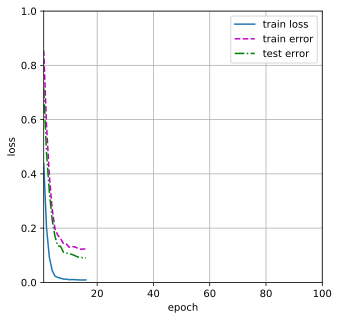

In [ ]:
if (test_env == 'notebook'):
  id_df = combined_dfs['NUMERIC_IDS']
  best_params['num_epochs'] = 100
  net, predictions, valid_nrmse = evaluateOptimalHyperparameters(cyp_config,
                                                                 best_params,
                                                                 is_validation=True,
                                                                 early_stopping=True,
                                                                 visualize=True)
  print('Validation NRMSE:', round(100 * valid_nrmse, 2))
  pd_cv_preds = pd.DataFrame(data=predictions, columns=["id0", "id3", "FYEAR", "YIELD", "YIELD_PRED"])
  pd_cv_preds = pd_cv_preds.merge(id_df, on=['id0', 'id3']).drop(columns=['id0', 'id3'])
  pd_cv_preds = pd_cv_preds[['COUNTRY', 'IDREGION', 'FYEAR', 'YIELD', 'YIELD_PRED']]

  countries = pd_cv_preds['COUNTRY'].unique()
  valid_info = '\nValidation Set NRMSEs'
  valid_info += '\n---------------------'
  for cn in countries:
    cn_preds_df = pd_cv_preds[pd_cv_preds['COUNTRY'] == cn]
    cn_nrmse = NormalizedRMSE(cn_preds_df['YIELD'].values,
                              cn_preds_df['YIELD_PRED'].values)
    valid_info += '\n' + crop + ', '  + cn + ' NRMSE:' + str(cn_nrmse)
    print('\n', crop, cn, 'Normalized RMSE:', cn_nrmse)
    print(cn_preds_df.head(10))

  log_fh.write(valid_info)
  saved_net_name = cyp_config['architecture'] + '-valid.net'
  torch.save(net.state_dict(), '/content/' + saved_net_name)

### Evaluate on test data

NRMSE: 0.1421
Test NRMSE: 14.21

 soft wheat FR Normalized RMSE: 14.205852874686656
  COUNTRY IDREGION   FYEAR  YIELD  YIELD_PRED
0      FR    FR102  2010.0    8.3    8.543965
1      FR    FR102  2011.0    8.0    8.380564
2      FR    FR102  2012.0    8.1    7.687945
3      FR    FR102  2013.0    8.4    7.849327
4      FR    FR102  2014.0    8.8    7.804299
5      FR    FR102  2015.0    8.9    8.225515
6      FR    FR102  2016.0    4.0    8.122795
7      FR    FR102  2017.0    8.1    7.783165
8      FR    FR102  2018.0    7.7    7.533370
9      FR    FR103  2010.0    7.6    8.276426


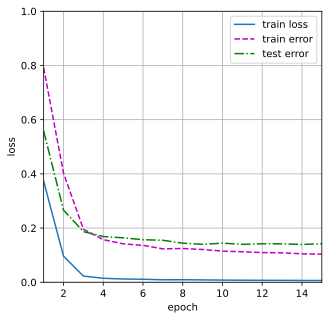

In [ ]:
if (test_env == 'notebook'):
  id_df = combined_dfs['NUMERIC_IDS']
  net, predictions, test_nrmse = evaluateOptimalHyperparameters(cyp_config,
                                                                best_params,
                                                                is_validation=False,
                                                                early_stopping=False,
                                                                visualize=True)
  print('Test NRMSE:', round(100 * test_nrmse, 2))
  pd_test_preds = pd.DataFrame(data=predictions, columns=["id0", "id3", "FYEAR", "YIELD", "YIELD_PRED"])
  pd_test_preds = pd_test_preds.merge(id_df, on=['id0', 'id3']).drop(columns=['id0', 'id3'])
  pd_test_preds = pd_test_preds[['COUNTRY', 'IDREGION', 'FYEAR', 'YIELD', 'YIELD_PRED']]

  countries = pd_test_preds['COUNTRY'].unique()
  test_info = '\nTest Set NRMSEs'
  test_info += '\n-----------------'
  for cn in countries:
    cn_preds_df = pd_test_preds[pd_test_preds['COUNTRY'] == cn]
    cn_nrmse = NormalizedRMSE(cn_preds_df['YIELD'].values,
                              cn_preds_df['YIELD_PRED'].values)
    test_info += '\n' + crop + ', '  + cn + ' NRMSE:' + str(cn_nrmse)
    print('\n', crop, cn, 'Normalized RMSE:', cn_nrmse)
    print(cn_preds_df.head(10))

  # Save predictions
  output_path = cyp_config['output_path']
  pred_file = getPredictionFilename(cyp_config['crop'],
                                    cyp_config['use_yield_trend'],
                                    cyp_config['early_season_end_dekad'],
                                    cyp_config['country_code'],
                                    cyp_config['spatial_level'],
                                    cyp_config['architecture'])

  pd_test_preds.to_csv(output_path + '/' + pred_file + '.csv', index=False)

  log_fh.write(test_info)
  saved_net_name = cyp_config['architecture'] + '-full.net'
  torch.save(net.state_dict(), '/content/' + saved_net_name)

### Feature Attributions

#### Utility functions

In [ ]:
import captum
from captum.attr import Occlusion
from captum.attr import IntegratedGradients
from captum.attr import DeepLift
from captum.attr import DeepLiftShap
from captum.attr import GradientShap

import pandas as pd
import numpy as np
from pathlib import Path
import geopandas as gpd
import seaborn as sns
# import branca.colormap as cm
# sns.set(font_scale=2.0)

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
pd.options.mode.chained_assignment = None

import matplotlib as mpl
# %matplotlib inline

from scipy import stats

def getNUTSGeoPandasData(country, nuts_level):
  nuts_map_source = 'https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson'
  geojson_file = 'NUTS_RG_03M_2016_4326_LEVL_' + nuts_level[-1] + '.geojson'

  geo_pd_nutsx = gpd.read_file(nuts_map_source + '/' + geojson_file)
  geo_pd_nutsx = geo_pd_nutsx.drop(columns=['id', 'LEVL_CODE', 'FID'])
  geo_pd_nutsx = geo_pd_nutsx.rename(columns={ 'CNTR_CODE' : 'COUNTRY'} )
  geo_pd_nutsx = geo_pd_nutsx[geo_pd_nutsx['COUNTRY'] == country]

  return geo_pd_nutsx

def plotStaticMaps(country, nuts_level, map_limits,
                   pd_values_df, show_cols, color_map,
                   vmin, vmax, title_label):
  pd_nuts0_df = getNUTSGeoPandasData(country, 'NUTS0')
  pd_nuts3_df = getNUTSGeoPandasData(country, nuts_level)

  num_plots = len(show_cols)
  fig, axs = plt.subplots(1, num_plots, figsize=(3 * num_plots, 2.5))

  pd_show_df = pd_values_df.copy()
  pd_nuts3_df = pd_nuts3_df.merge(pd_show_df, on=['COUNTRY', 'NUTS_ID'])
  for i, c in enumerate(show_cols):
    if (num_plots == 1):
      sel_ax = axs
    else:
      sel_ax = axs[i]

    base = pd_nuts3_df.plot(column=c, ax=sel_ax,
                            linewidth=1.0, edgecolor='gray',
                            legend=(i==(len(show_cols) - 1)),
                            cmap=color_map, vmax=vmax, vmin=vmin)

    sel_ax.set_xlim(map_limits['xmin'], map_limits['xmax'])
    sel_ax.set_ylim(map_limits['ymin'], map_limits['ymax'])
    pd_nuts0_df.plot(ax=base, edgecolor='black', linewidth=2.0, facecolor="none")
    base.set(yticklabels=[])
    base.set(xticklabels=[])

  fig.suptitle(title_label, fontsize=12)

##############################################
# Compute and visualize feature attributions #
##############################################

def getFeatureValues(data_loader):
  X_ts_all = None
  X_static_all = None
  X_trend_all = None
  Y_all = None
  for X_ts, X_static, X_trend, y in data_loader:
    if (X_ts_all is None):
      X_ts_all, X_static_all, X_trend_all = X_ts, X_static, X_trend
      Y_all = y
    else:
      X_ts_all = torch.cat((X_ts_all, X_ts), 0)
      X_static_all = torch.cat((X_static_all, X_static), 0)
      X_trend_all = torch.cat((X_trend_all, X_trend), 0)
      Y_all = torch.cat((Y_all, y), 0)

  X_ts_all = X_ts_all.detach().numpy()
  X_static_all = X_static_all.detach().numpy()
  X_trend_all = X_trend_all.detach().numpy()
  Y_all = Y_all.detach().numpy()

  return X_ts_all, X_static_all, X_trend_all, Y_all

# TODO: Check attributions are stacked correctly
# Example from Matplotlib
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_stacked.html
def getFeatureAttributions(net, nn_architecture, test_loader, attr_class):
  net.eval()

  ts_attr_all = None
  rest_attr_all = None
  trend_attr_all = None
  for X_ts, X_rest, X_trend, y in test_loader:
    # for LSTM, X_ts second dimension is the time series
    ts_sliding_window = (3, 1)
    if (nn_architecture == '1DCNN'):
      X_ts = X_ts.permute(0, 2, 1)
      # for 1DCNN, X_ts second dimension is the indicator
      ts_sliding_window = (1, 3)

    X_ts.requires_grad_()
    X_rest.requires_grad_()
    X_trend.requires_grad_()
    # TODO: Compare with baselines filled with zeroes
    baselines = (torch.randn(X_ts.shape),
                 torch.randn(X_rest.shape),
                 torch.randn(X_trend.shape))

    if (isinstance(attr_class, Occlusion)):
      attr = attr_class.attribute((X_ts, X_rest, X_trend), baselines=baselines, target=0,
                                  sliding_window_shapes=(ts_sliding_window, (1,), (1,)))
    elif (isinstance(attr_class, IntegratedGradients) or
          isinstance(attr_class, DeepLift) or
          isinstance(attr_class, DeepLiftShap) or
          isinstance(attr_class, GradientShap)):
      attr, delta = attr_class.attribute((X_ts, X_rest, X_trend), baselines, target=0,
                                         return_convergence_delta=True)

    if (ts_attr_all is None):
      ts_attr_all, rest_attr_all, trend_attr_all = attr
    else:
      ts_attr_all = torch.cat((ts_attr_all, attr[0]), 0)
      rest_attr_all = torch.cat((rest_attr_all, attr[1]), 0)
      trend_attr_all = torch.cat((trend_attr_all, attr[2]), 0)

  ts_attr_all = ts_attr_all.detach().numpy()
  rest_attr_all = rest_attr_all.detach().numpy()
  trend_attr_all = trend_attr_all.detach().numpy()

  return ts_attr_all, rest_attr_all, trend_attr_all

def getDekadNumbers(nn_arch, ts_attr_all):
  if (nn_arch == '1DCNN'):
    return [(i+1) for i in range(ts_attr_all.shape[2])]
  else:
    return [(i+1) for i in range(ts_attr_all.shape[1])]

def getTimeSeriesFeatureColors(ts_indicator_names):
  colors = ['silver', 'salmon', 'orange', 'khaki', 'yellow', 'lime',
            'cyan', 'lavender', 'pink', 'plum', 'royalblue', 'blueviolet']
  assert (len(ts_indicator_names) <= len(colors))
  ft_colors = {}
  for i, ft in enumerate(ts_indicator_names):
    ft_colors[ft] = colors[i]

  return ft_colors

# Take negative and positive data apart and cumulate
# From https://stackoverflow.com/questions/35979852/stacked-bar-charts-using-python-matplotlib-for-positive-and-negative-values

def getCumulativeArray(data, **kwargs):
    cum = data.clip(**kwargs)
    cum = np.cumsum(cum, axis=0)
    d = np.zeros(np.shape(data))
    d[1:] = cum[:-1]
    return d

def stackedBarPlots(ft_labels, ft_importances, stack_ids, stack_colors,
                    figure_title, figure_filename):
  x_pos = np.arange(len(ft_labels))
  fig, axs = plt.subplots(1, 6, sharex=True, sharey=True, figsize=(12, 2.5))
  for period_idx in range(6):
    # https://www.geeksforgeeks.org/create-a-stacked-bar-plot-in-matplotlib/
    # plot stacked bars
    # plt.bar(x, y1, color='r')
    # plt.bar(x, y2, bottom=y1, color='b')
    # plt.bar(x, y3, bottom=y1+y2, color='y')

    # handle +ve and -ve data
    # https://stackoverflow.com/questions/35979852/stacked-bar-charts-using-python-matplotlib-for-positive-and-negative-values
    all_data = np.array([ft_importances[sid][period_idx] for sid in stack_ids])

    cumulated_data = getCumulativeArray(all_data, min=0)
    cumulated_neg = getCumulativeArray(all_data, max=0)

    # Merge negative and positive data.
    row_mask = (all_data < 0)
    cumulated_data[row_mask] = cumulated_neg[row_mask]
    expert_data_stack = cumulated_data
    for i in range(len(stack_ids)):
      axs[period_idx].barh(x_pos, all_data[i], left=expert_data_stack[i],
                           align='center', color=stack_colors[i])

    axs[period_idx].set_yticks(x_pos)
    axs[period_idx].set_yticklabels(ft_labels)
    title="Period p" + str(period_idx)
    axs[period_idx].set_xlim([-3, 4])
    # if (period_idx == 0):
    #   axs[period_idx].legend(expert_ids)

    axs[period_idx].axvline(x=0.0, color='gray', linestyle='-')
    axs[period_idx].set_title(title)

  fig.tight_layout(rect=[0, 0.03, 1, 0.95])
  fig.suptitle(figure_title, fontsize=14)
  fig.savefig(figure_filename + '.jpg', dpi=300, bbox_inches='tight')

def plotExpertFeatureImportances(ft_labels, expert_ft_importances, expert_ids, colors):
  stackedBarPlots(ft_labels, expert_ft_importances, expert_ids, colors,
                  'Feature Importance from Experts', 'barplots_experts')

def plotMultipleMethodImportances(ft_labels, dl_ft_importances, dl_attr_methods, colors):
  stackedBarPlots(ft_labels, dl_ft_importances, dl_attr_methods, colors,
                  'Feature Importance from DL', 'barplots_dl')

def barPlotsPerPeriod(ft_imports, ts_ft_names, attr_methods,
                      crop_cal, early_season_end,
                      architecture, figure_title, figure_file):
  x_pos = np.arange(len(ts_ft_names))
  fig, axs = plt.subplots(1, len(crop_cal), sharex=True, sharey=True, figsize=(12, 2.5))
  last_dekad = 36 + early_season_end
  for i, p in enumerate(list(crop_cal.keys())):
    p_start, p_end = crop_cal[p]
    if (last_dekad < p_start):
      continue

    period_ft_import_neg = np.zeros(len(ts_ft_names))
    period_ft_import_pos = np.zeros(len(ts_ft_names))
    for attr_method in attr_methods:
      ts_imports = ft_imports[attr_method]['ts']

      for j, ft in enumerate(ts_ft_names):
        if (architecture == '1DCNN'):
          sel_data = ts_imports[:, j, p_start-1:p_end]
        else:
          sel_data = ts_imports[:, p_start-1:p_end, j]

        period_ft_import_neg[j] += np.mean(sel_data.clip(max=0))
        period_ft_import_pos[j] += np.mean(sel_data.clip(min=0))

    axs[i].barh(x_pos, period_ft_import_neg, align='center')
    axs[i].barh(x_pos, period_ft_import_pos, align='center')
    axs[i].set_yticks(x_pos)
    axs[i].set_yticklabels(ts_ft_names)
    axs[i].set_title('Period ' + p)

  # fig.suptitle('Bar plots per period')
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])
  fig.suptitle(figure_title, fontsize=14)
  fig.savefig(figure_file + '.jpg', dpi=300, bbox_inches='tight')

#### SHAP Beeswarm plots

In [ ]:
# stuff from shap beeswarm plot
# from https://github.com/slundberg/shap/blob/0662f4e9e6be38e658120079904899cccda59ff8/shap/plots/_beeswarm.py

from scipy import linalg
from warnings import warn
import matplotlib.cm as cm

def rgb2xyz(rgb):
    # Follow the algorithm from http://www.easyrgb.com/index.php
    # except we don't multiply/divide by 100 in the conversion
    arr = _prepare_colorarray(rgb).copy()
    mask = arr > 0.04045
    arr[mask] = np.power((arr[mask] + 0.055) / 1.055, 2.4)
    arr[~mask] /= 12.92
    return arr @ xyz_from_rgb.T.astype(arr.dtype)

def lab2xyz(lab, illuminant="D65", observer="2"):
    arr = _prepare_colorarray(lab).copy()

    L, a, b = arr[:, :, 0], arr[:, :, 1], arr[:, :, 2]
    y = (L + 16.) / 116.
    x = (a / 500.) + y
    z = y - (b / 200.)

    if np.any(z < 0):
        invalid = np.nonzero(z < 0)
        warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size,
             stacklevel=2)
        z[invalid] = 0

    out = np.dstack([x, y, z])

    mask = out > 0.2068966
    out[mask] = np.power(out[mask], 3.)
    out[~mask] = (out[~mask] - 16.0 / 116.) / 7.787

    # rescale to the reference white (illuminant)
    xyz_ref_white = get_xyz_coords(illuminant, observer)
    out *= xyz_ref_white
    return out

def xyz2lab(xyz, illuminant="D65", observer="2"):
    arr = _prepare_colorarray(xyz)

    xyz_ref_white = get_xyz_coords(illuminant, observer)

    # scale by CIE XYZ tristimulus values of the reference white point
    arr = arr / xyz_ref_white

    # Nonlinear distortion and linear transformation
    mask = arr > 0.008856
    arr[mask] = np.cbrt(arr[mask])
    arr[~mask] = 7.787 * arr[~mask] + 16. / 116.

    x, y, z = arr[..., 0], arr[..., 1], arr[..., 2]

    # Vector scaling
    L = (116. * y) - 16.
    a = 500.0 * (x - y)
    b = 200.0 * (y - z)

    return np.concatenate([x[..., np.newaxis] for x in [L, a, b]], axis=-1)

def lab2rgb(lab, illuminant="D65", observer="2"):
  return xyz2rgb(lab2xyz(lab, illuminant, observer))

def img_as_float(image, force_copy=False):
    return convert(image, np.floating, force_copy)

def prepare_lab_array(arr):
  arr = np.asarray(arr)
  shape = arr.shape
  if shape[-1] < 3:
      raise ValueError('Input array has less than 3 color channels')
  return img_as_float(arr, force_copy=True)

def lch2lab(lch):
  lch = prepare_lab_array(lch)

  c, h = lch[..., 1], lch[..., 2]
  lch[..., 1], lch[..., 2] = c * np.cos(h), c * np.sin(h)
  return lch

def get_xyz_coords(illuminant, observer):
    illuminant = illuminant.upper()
    try:
        return illuminants[illuminant][observer]
    except KeyError:
        raise ValueError("Unknown illuminant/observer combination\
        (\'{0}\', \'{1}\')".format(illuminant, observer))

def _prepare_colorarray(arr):
    """Check the shape of the array and convert it to
    floating point representation.
    """
    arr = np.asanyarray(arr)

    if arr.ndim not in [3, 4] or arr.shape[-1] != 3:
        msg = ("the input array must be have a shape == (.., ..,[ ..,] 3)), " +
               "got (" + (", ".join(map(str, arr.shape))) + ")")
        raise ValueError(msg)

    return img_as_float(arr)

def xyz2rgb(xyz):
    # Follow the algorithm from http://www.easyrgb.com/index.php
    # except we don't multiply/divide by 100 in the conversion
    arr = _convert(rgb_from_xyz, xyz)
    mask = arr > 0.0031308
    arr[mask] = 1.055 * np.power(arr[mask], 1 / 2.4) - 0.055
    arr[~mask] *= 12.92
    np.clip(arr, 0, 1, out=arr)
    return arr

def _convert(matrix, arr):
    arr = _prepare_colorarray(arr)

    return arr @ matrix.T.copy()

# ---------------------------------------------------------------
# Matrices that define conversion between different color spaces
# ---------------------------------------------------------------

# From sRGB specification
xyz_from_rgb = np.array([[0.412453, 0.357580, 0.180423],
                         [0.212671, 0.715160, 0.072169],
                         [0.019334, 0.119193, 0.950227]])

rgb_from_xyz = linalg.inv(xyz_from_rgb)

# From https://en.wikipedia.org/wiki/CIE_1931_color_space
# Note: Travis's code did not have the divide by 0.17697
xyz_from_rgbcie = np.array([[0.49, 0.31, 0.20],
                            [0.17697, 0.81240, 0.01063],
                            [0.00, 0.01, 0.99]]) / 0.17697

rgbcie_from_xyz = linalg.inv(xyz_from_rgbcie)

# construct matrices to and from rgb:
rgbcie_from_rgb = rgbcie_from_xyz @ xyz_from_rgb
rgb_from_rgbcie = rgb_from_xyz @ xyz_from_rgbcie


gray_from_rgb = np.array([[0.2125, 0.7154, 0.0721],
                          [0, 0, 0],
                          [0, 0, 0]])

yuv_from_rgb = np.array([[ 0.299     ,  0.587     ,  0.114      ],
                         [-0.14714119, -0.28886916,  0.43601035 ],
                         [ 0.61497538, -0.51496512, -0.10001026 ]])

rgb_from_yuv = linalg.inv(yuv_from_rgb)

yiq_from_rgb = np.array([[0.299     ,  0.587     ,  0.114     ],
                         [0.59590059, -0.27455667, -0.32134392],
                         [0.21153661, -0.52273617,  0.31119955]])

rgb_from_yiq = linalg.inv(yiq_from_rgb)

ypbpr_from_rgb = np.array([[ 0.299   , 0.587   , 0.114   ],
                           [-0.168736,-0.331264, 0.5     ],
                           [ 0.5     ,-0.418688,-0.081312]])

rgb_from_ypbpr = linalg.inv(ypbpr_from_rgb)

ycbcr_from_rgb = np.array([[    65.481,   128.553,    24.966],
                           [   -37.797,   -74.203,   112.0  ],
                           [   112.0  ,   -93.786,   -18.214]])

rgb_from_ycbcr = linalg.inv(ycbcr_from_rgb)

ydbdr_from_rgb = np.array([[    0.299,   0.587,    0.114],
                           [   -0.45 ,  -0.883,    1.333],
                           [   -1.333,   1.116,    0.217]])

rgb_from_ydbdr = linalg.inv(ydbdr_from_rgb)


# CIE LAB constants for Observer=2A, Illuminant=D65
# NOTE: this is actually the XYZ values for the illuminant above.
lab_ref_white = np.array([0.95047, 1., 1.08883])


illuminants = \
    {"A": {'2': (1.098466069456375, 1, 0.3558228003436005),
           '10': (1.111420406956693, 1, 0.3519978321919493)},
     "D50": {'2': (0.9642119944211994, 1, 0.8251882845188288),
             '10': (0.9672062750333777, 1, 0.8142801513128616)},
     "D55": {'2': (0.956797052643698, 1, 0.9214805860173273),
             '10': (0.9579665682254781, 1, 0.9092525159847462)},
     "D65": {'2': (0.95047, 1., 1.08883),   # This was: `lab_ref_white`
             '10': (0.94809667673716, 1, 1.0730513595166162)},
     "D75": {'2': (0.9497220898840717, 1, 1.226393520724154),
             '10': (0.9441713925645873, 1, 1.2064272211720228)},
     "E": {'2': (1.0, 1.0, 1.0),
           '10': (1.0, 1.0, 1.0)}}


_integer_types = (np.byte, np.ubyte,          # 8 bits
                  np.short, np.ushort,        # 16 bits
                  np.intc, np.uintc,          # 16 or 32 or 64 bits
                  np.int_, np.uint,           # 32 or 64 bits
                  np.longlong, np.ulonglong)  # 64 bits
_integer_ranges = {t: (np.iinfo(t).min, np.iinfo(t).max)
                   for t in _integer_types}
dtype_range = {np.bool_: (False, True),
               np.bool8: (False, True),
               np.float16: (-1, 1),
               np.float32: (-1, 1),
               np.float64: (-1, 1)}
dtype_range.update(_integer_ranges)

_supported_types = list(dtype_range.keys())


def dtype_limits(image, clip_negative=False):
    """Return intensity limits, i.e. (min, max) tuple, of the image's dtype.
    Parameters
    ----------
    image : ndarray
        Input image.
    clip_negative : bool, optional
        If True, clip the negative range (i.e. return 0 for min intensity)
        even if the image dtype allows negative values.
    Returns
    -------
    imin, imax : tuple
        Lower and upper intensity limits.
    """
    imin, imax = dtype_range[image.dtype.type]
    if clip_negative:
        imin = 0
    return imin, imax


def _dtype_itemsize(itemsize, *dtypes):
    return next(dt for dt in dtypes if np.dtype(dt).itemsize >= itemsize)


def _dtype_bits(kind, bits, itemsize=1):
    s = next(i for i in (itemsize, ) + (2, 4, 8) if
             bits < (i * 8) or (bits == (i * 8) and kind == 'u'))

    return np.dtype(kind + str(s))


def _scale(a, n, m, copy=True):
    kind = a.dtype.kind
    if n > m and a.max() < 2 ** m:
        mnew = int(np.ceil(m / 2) * 2)
        if mnew > m:
            dtype = "int{}".format(mnew)
        else:
            dtype = "uint{}".format(mnew)
        n = int(np.ceil(n / 2) * 2)
        warn("Downcasting {} to {} without scaling because max "
             "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype),
             stacklevel=3)
        return a.astype(_dtype_bits(kind, m))
    elif n == m:
        return a.copy() if copy else a
    elif n > m:
        # downscale with precision loss
        if copy:
            b = np.empty(a.shape, _dtype_bits(kind, m))
            np.floor_divide(a, 2**(n - m), out=b, dtype=a.dtype,
                            casting='unsafe')
            return b
        else:
            a //= 2**(n - m)
            return a
    elif m % n == 0:
        # exact upscale to a multiple of `n` bits
        if copy:
            b = np.empty(a.shape, _dtype_bits(kind, m))
            np.multiply(a, (2**m - 1) // (2**n - 1), out=b, dtype=b.dtype)
            return b
        else:
            a = a.astype(_dtype_bits(kind, m, a.dtype.itemsize), copy=False)
            a *= (2**m - 1) // (2**n - 1)
            return a
    else:
        # upscale to a multiple of `n` bits,
        # then downscale with precision loss
        o = (m // n + 1) * n
        if copy:
            b = np.empty(a.shape, _dtype_bits(kind, o))
            np.multiply(a, (2**o - 1) // (2**n - 1), out=b, dtype=b.dtype)
            b //= 2**(o - m)
            return b
        else:
            a = a.astype(_dtype_bits(kind, o, a.dtype.itemsize), copy=False)
            a *= (2**o - 1) // (2**n - 1)
            a //= 2**(o - m)
            return a


def convert(image, dtype, force_copy=False, uniform=False):
    image = np.asarray(image)
    dtypeobj_in = image.dtype
    if dtype is np.floating:
        dtypeobj_out = np.dtype("float64")
    else:
        dtypeobj_out = np.dtype(dtype)
    dtype_in = dtypeobj_in.type
    dtype_out = dtypeobj_out.type
    kind_in = dtypeobj_in.kind
    kind_out = dtypeobj_out.kind
    itemsize_in = dtypeobj_in.itemsize
    itemsize_out = dtypeobj_out.itemsize

    # Below, we do an `issubdtype` check.  Its purpose is to find out
    # whether we can get away without doing any image conversion.  This happens
    # when:
    #
    # - the output and input dtypes are the same or
    # - when the output is specified as a type, and the input dtype
    #   is a subclass of that type (e.g. `np.floating` will allow
    #   `float32` and `float64` arrays through)

    if np.issubdtype(dtype_in, np.obj2sctype(dtype)):
        if force_copy:
            image = image.copy()
        return image

    if not (dtype_in in _supported_types and dtype_out in _supported_types):
        raise ValueError("Can not convert from {} to {}."
                         .format(dtypeobj_in, dtypeobj_out))

    if kind_in in 'ui':
        imin_in = np.iinfo(dtype_in).min
        imax_in = np.iinfo(dtype_in).max
    if kind_out in 'ui':
        imin_out = np.iinfo(dtype_out).min
        imax_out = np.iinfo(dtype_out).max

    # any -> binary
    if kind_out == 'b':
        return image > dtype_in(dtype_range[dtype_in][1] / 2)

    # binary -> any
    if kind_in == 'b':
        result = image.astype(dtype_out)
        if kind_out != 'f':
            result *= dtype_out(dtype_range[dtype_out][1])
        return result

    # float -> any
    if kind_in == 'f':
        if kind_out == 'f':
            # float -> float
            return image.astype(dtype_out)

        if np.min(image) < -1.0 or np.max(image) > 1.0:
            raise ValueError("Images of type float must be between -1 and 1.")
        # floating point -> integer
        # use float type that can represent output integer type
        computation_type = _dtype_itemsize(itemsize_out, dtype_in,
                                           np.float32, np.float64)

        if not uniform:
            if kind_out == 'u':
                image_out = np.multiply(image, imax_out,
                                        dtype=computation_type)
            else:
                image_out = np.multiply(image, (imax_out - imin_out) / 2,
                                        dtype=computation_type)
                image_out -= 1.0 / 2.
            np.rint(image_out, out=image_out)
            np.clip(image_out, imin_out, imax_out, out=image_out)
        elif kind_out == 'u':
            image_out = np.multiply(image, imax_out + 1,
                                    dtype=computation_type)
            np.clip(image_out, 0, imax_out, out=image_out)
        else:
            image_out = np.multiply(image, (imax_out - imin_out + 1.0) / 2.0,
                                    dtype=computation_type)
            np.floor(image_out, out=image_out)
            np.clip(image_out, imin_out, imax_out, out=image_out)
        return image_out.astype(dtype_out)

    # signed/unsigned int -> float
    if kind_out == 'f':
        # use float type that can exactly represent input integers
        computation_type = _dtype_itemsize(itemsize_in, dtype_out,
                                           np.float32, np.float64)

        if kind_in == 'u':
            # using np.divide or np.multiply doesn't copy the data
            # until the computation time
            image = np.multiply(image, 1. / imax_in,
                                dtype=computation_type)
            # DirectX uses this conversion also for signed ints
            # if imin_in:
            #     np.maximum(image, -1.0, out=image)
        else:
            image = np.add(image, 0.5, dtype=computation_type)
            image *= 2 / (imax_in - imin_in)

        return np.asarray(image, dtype_out)

    # unsigned int -> signed/unsigned int
    if kind_in == 'u':
        if kind_out == 'i':
            # unsigned int -> signed int
            image = _scale(image, 8 * itemsize_in, 8 * itemsize_out - 1)
            return image.view(dtype_out)
        else:
            # unsigned int -> unsigned int
            return _scale(image, 8 * itemsize_in, 8 * itemsize_out)

    # signed int -> unsigned int
    if kind_out == 'u':
        image = _scale(image, 8 * itemsize_in - 1, 8 * itemsize_out)
        result = np.empty(image.shape, dtype_out)
        np.maximum(image, 0, out=result, dtype=image.dtype, casting='unsafe')
        return result

    # signed int -> signed int
    if itemsize_in > itemsize_out:
        return _scale(image, 8 * itemsize_in - 1, 8 * itemsize_out - 1)

    image = image.astype(_dtype_bits('i', itemsize_out * 8))
    image -= imin_in
    image = _scale(image, 8 * itemsize_in, 8 * itemsize_out, copy=False)
    image += imin_out
    return image.astype(dtype_out)

import matplotlib
from matplotlib.colors import LinearSegmentedColormap

def lch2rgb(x):
    return lab2rgb(lch2lab([[x]]))[0][0]

# define our colors using Lch
# note that we intentionally vary the lightness during interpolation so as to better
# enable the eye to see patterns (since patterns are most easily recognized through
# lightness variability)
blue_lch = [54., 70., 4.6588]
l_mid = 40.
red_lch = [54., 90., 0.35470565 + 2* np.pi]
gray_lch = [55., 0., 0.]
gray_rgb = lch2rgb(gray_lch)
white_rgb = np.array([1.,1.,1.])

# define a perceptually uniform color scale using the Lch color space
reds = []
greens = []
blues = []
alphas = []
nsteps = 100
l_vals = list(np.linspace(blue_lch[0], l_mid, nsteps//2)) + list(np.linspace(l_mid, red_lch[0], nsteps//2))
c_vals = np.linspace(blue_lch[1], red_lch[1], nsteps)
h_vals = np.linspace(blue_lch[2], red_lch[2], nsteps)
for pos,l,c,h in zip(np.linspace(0, 1, nsteps), l_vals, c_vals, h_vals):
    lch = [l, c, h]
    rgb = lch2rgb(lch)
    reds.append((pos, rgb[0], rgb[0]))
    greens.append((pos, rgb[1], rgb[1]))
    blues.append((pos, rgb[2], rgb[2]))
    alphas.append((pos, 1.0, 1.0))

red_blue = LinearSegmentedColormap('red_blue', {
    "red": reds,
    "green": greens,
    "blue": blues,
    "alpha": alphas
})
red_blue.set_bad(gray_rgb, 1.0)
red_blue.set_over(gray_rgb, 1.0)
red_blue.set_under(gray_rgb, 1.0)

def beeswarmPlot(ft_attr, ft_vals, feature_names,
                 xlabel, ftval_color, axis_color,
                 xmin, xmax, title_label):
  yticklabels = feature_names
  num_features = len(feature_names)
  row_height = 0.3
  plt.gcf().set_size_inches(8, num_features * row_height + 1.5)
  plt.axvline(x=0, color="#999999", zorder=-1)

  # make the beeswarm dots
  feature_inds = [j for j in range(1, num_features + 1)]
  for pos, j in enumerate(feature_inds):
    plt.axhline(y=pos, color="#cccccc", lw=0.5, dashes=(1, 5))
    shaps = ft_attr[:, j - 1]
    fvalues = ft_vals[:, j - 1]
    colored_feature = True
    N = len(shaps)
    nbins = 100
    quant = np.round(nbins * (shaps - np.min(shaps)) / (np.max(shaps) - np.min(shaps) + 1e-8))
    inds = np.argsort(quant + np.random.randn(N) * 1e-6)
    layer = 0
    last_bin = -1
    ys = np.zeros(N)
    for ind in inds:
        if quant[ind] != last_bin:
            layer = 0
        ys[ind] = np.ceil(layer / 2) * ((layer % 2) * 2 - 1)
        layer += 1
        last_bin = quant[ind]
    ys *= 0.9 * (row_height / np.max(ys + 1))

    vmin = np.nanpercentile(fvalues, 5)
    vmax = np.nanpercentile(fvalues, 95)
    cvals = fvalues.astype(np.float64)
    cvals_imp = cvals.copy()
    cvals_imp[np.isnan(cvals)] = (vmin + vmax) / 2.0
    cvals[cvals_imp > vmax] = vmax
    cvals[cvals_imp < vmin] = vmin
    plt.scatter(shaps, pos + 1 + ys,
                cmap=ftval_color, vmin=vmin, vmax=vmax, s=16,
                c=cvals, alpha=1, linewidth=0,
                zorder=3, rasterized=len(shaps) > 500)

  m = cm.ScalarMappable(cmap=ftval_color)
  m.set_array([0, 1])
  cb = plt.colorbar(m, ticks=[0, 1], aspect=1000)
  cb.set_ticklabels(["Low", "High"])
  cb.set_label("Feature value", size=12, labelpad=0)
  cb.ax.tick_params(labelsize=11, length=0)
  cb.set_alpha(1)
  cb.outline.set_visible(False)
  bbox = cb.ax.get_window_extent().transformed(plt.gcf().dpi_scale_trans.inverted())
  cb.ax.set_aspect((bbox.height - 0.9) * 20)
    # cb.draw_all()

  plt.gca().xaxis.set_ticks_position('bottom')
  plt.gca().yaxis.set_ticks_position('none')
  plt.gca().spines['right'].set_visible(False)
  plt.gca().spines['top'].set_visible(False)
  plt.gca().spines['left'].set_visible(False)
  plt.gca().tick_params(color=axis_color, labelcolor=axis_color)
  plt.yticks(range(1, num_features + 1), yticklabels, fontsize=13)
  plt.gca().tick_params('y', length=20, width=0.5, which='major')
  plt.gca().tick_params('x', labelsize=11)
  plt.ylim(0, num_features + 1)
  plt.xlim(xmin, xmax)
  plt.xlabel(xlabel, fontsize=13)
  plt.title(title_label.replace('_', ' '))
  plt.savefig(title_label + ".jpg", dpi=300, bbox_inches='tight')
  plt.show()

#### Datasets

In [ ]:
test_fraction = cyp_config['test_fraction']
use_yield_trend = cyp_config['use_yield_trend']
early_season_end = cyp_config['early_season_end_dekad']
print_debug = cyp_config['debug_level'] > 1
num_valid_years = 5

scaler_args = {}
train_dataset = CYPMLDataset(combined_dfs,
                             yield_trend=use_yield_trend,
                             early_season_end=early_season_end,
                             is_train=True,
                             test_fraction=test_fraction,
                             num_folds=1, fold_iter=0,
                             num_valid_years=5,
                             scaler_args=scaler_args,
                             country=country,
                             print_debug=print_debug,
                             log_fh=log_fh)

valid_dataset = CYPMLDataset(combined_dfs,
                             early_season_end=early_season_end,
                             is_train=False, is_validation=True,
                             test_fraction=test_fraction,
                             num_folds=1, fold_iter=0,
                             num_valid_years=5,
                             scaler_args=scaler_args,
                             country=country,
                             print_debug=print_debug,
                             log_fh=log_fh)

scaler_args = {}
test_years = None
# if ((crop == 'soft wheat') and (country == 'FR')):
#   test_years = [2017]

train_dataset2 = CYPMLDataset(combined_dfs,
                              yield_trend=use_yield_trend,
                              early_season_end=early_season_end,
                              is_train=True,
                              test_fraction=test_fraction,
                              num_folds=1, fold_iter=0,
                              num_valid_years=0,
                              scaler_args=scaler_args,
                              country=country, test_years=test_years,
                              print_debug=print_debug,
                              log_fh=log_fh)

test_dataset = CYPMLDataset(combined_dfs,
                            early_season_end=early_season_end,
                            is_train=False, is_validation=False,
                            test_fraction=test_fraction,
                            num_folds=1, fold_iter=0,
                            num_valid_years=0,
                            scaler_args=scaler_args,
                            country=country, test_years=test_years,
                            print_debug=print_debug,
                            log_fh=log_fh)

datasets = {
    'valid' : [train_dataset, valid_dataset],
    'test' : [train_dataset2, test_dataset]
}


----------------
Training data
----------------


Dekadal features: WLIM_YB, WLIM_YS, WLAI, RSM, TMIN, TMAX, TAVG, PREC, CWB, FAPAR
Other features: SM_WHC, AVG_ELEV, STD_ELEV, AVG_SLOPE, STD_SLOPE, AVG_FIELD_SIZE, STD_FIELD_SIZE, IRRIG_AREA_ALL, IRRIG_AREA90, AEZ_1845, AEZ_1932, AEZ_1957, AEZ_1976, AEZ_1984, AEZ_2034, AEZ_2057, AEZ_2075, AEZ_2137
Trend features: YIELD-5, YIELD-4, YIELD-3, YIELD-2, YIELD-1
Label columns: YIELD

FR Training years: 1999, 2000, 2001, 2002, 2003, 2004


Dekadal data: 528, 30, 10
Other feature data: 88, 19
Trend feature data: 528, 5
Label data: 528, 4

------------------
Validation data
------------------


Dekadal features: WLIM_YB, WLIM_YS, WLAI, RSM, TMIN, TMAX, TAVG, PREC, CWB, FAPAR
Other features: SM_WHC, AVG_ELEV, STD_ELEV, AVG_SLOPE, STD_SLOPE, AVG_FIELD_SIZE, STD_FIELD_SIZE, IRRIG_AREA_ALL, IRRIG_AREA90, AEZ_1845, AEZ_1932, AEZ_1957, AEZ_1976, AEZ_1984, AEZ_2034, AEZ_2057, AEZ_2075, AEZ_2137
Trend features: YIELD-5, YIELD-4, YIELD-3, YIELD-2, YIELD

#### Plot historical mean yields

test years: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
Index(['AEZ_ID', 'YIELD', 'NUTS_ID', 'COUNTRY'], dtype='object')


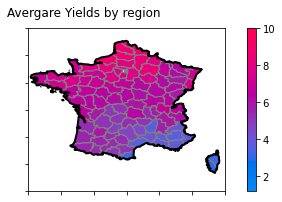

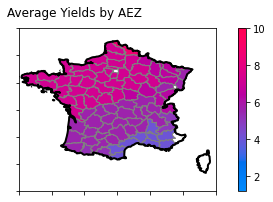

In [ ]:
def plotYields(country, nuts_level,
               pd_train_df, pd_test_df,
               map_limits, color_map,
               vmin, vmax, title):
  pd_nuts0_df = getNUTSGeoPandasData(country, 'NUTS0')
  pd_nuts3_df = getNUTSGeoPandasData(country, nuts_level)
  fig, axs = plt.subplots(1, 1, figsize=(8, 3))

  data_dfs = [pd_test_df]
  axes_titles = ['Training Set', 'Test Set']
  for i in range(1):
    pd_nuts3_df2 = pd_nuts3_df.merge(data_dfs[i], on=['COUNTRY', 'NUTS_ID'])
    sel_ax = axs # [i]
    base = pd_nuts3_df2.plot(column='YIELD', ax=sel_ax,
                             linewidth=1.0, edgecolor='gray',
                             legend=(i==0),
                             cmap=color_map, vmax=vmax, vmin=vmin)

    sel_ax.set_xlim(map_limits['xmin'], map_limits['xmax'])
    sel_ax.set_ylim(map_limits['ymin'], map_limits['ymax'])
    # sel_ax.set_title(axes_titles[i])
    pd_nuts0_df.plot(ax=base, edgecolor='black', linewidth=2.0, facecolor="none")
    base.set(yticklabels=[])
    base.set(xticklabels=[])

  fig.suptitle(title, fontsize=12)

id_df = combined_dfs['NUMERIC_IDS']
pd_yield_df = combined_dfs['YIELD']
pd_static_df = combined_dfs['STATIC']

pd_yield_df = pd_yield_df.merge(id_df, on=['id0', 'id3']).drop(columns=['id0', 'id3'])
pd_static_df = pd_static_df.merge(id_df, on=['id0', 'id3']).drop(columns=['id0', 'id3'])
pd_static_df = pd_static_df.rename(columns={'IDREGION' : 'NUTS_ID'})

all_years = sorted(pd_yield_df['FYEAR'].unique())
tr_ts_splitter = CYPTrainTestSplitter()
test_years = tr_ts_splitter.getTestYears(all_years, test_fraction=0.3,
                                         use_yield_trend=True)

print('test years:', test_years)
pd_yield_df = pd_yield_df.rename(columns={'IDREGION' : 'NUTS_ID'})
pd_train_yields = pd_yield_df[~pd_yield_df['FYEAR'].isin(test_years)]
pd_test_yields = pd_yield_df[pd_yield_df['FYEAR'].isin(test_years)]

unique_years = pd_train_yields['FYEAR'].unique()
if (len(unique_years) > 1):
  pd_train_yields = pd_train_yields.groupby(['NUTS_ID']).agg(YIELD=('YIELD', 'mean')).reset_index()
  pd_train_yields['COUNTRY'] = pd_train_yields['NUTS_ID'].str[:2]

map_limits = {
      'xmin' : -5, 'xmax' : 10,
      'ymin' : 40, 'ymax' : 52,
}

vmin = pd_yield_df['YIELD'].min()
vmax = pd_yield_df['YIELD'].max()

unique_years = pd_test_yields['FYEAR'].unique()
if (len(unique_years) > 1):
  pd_test_yields = pd_test_yields.groupby(['NUTS_ID']).agg(YIELD=('YIELD', 'mean')).reset_index()
  pd_test_yields['COUNTRY'] = pd_test_yields['NUTS_ID'].str[:2]

plotYields('FR', 'NUTS3', pd_train_yields, pd_test_yields,
           map_limits, red_blue, vmin, vmax, 'Avergare Yields by region')

pd_test_yields = pd_test_yields.merge(pd_static_df, on=['NUTS_ID'])
pd_aez_yields = pd_test_yields.groupby(['AEZ_ID']).agg(YIELD=('YIELD', 'mean')).reset_index()
pd_aez_yields = pd_aez_yields.merge(pd_test_yields[['NUTS_ID', 'AEZ_ID']], on=['AEZ_ID'])

pd_aez_yields['COUNTRY'] = pd_aez_yields['NUTS_ID'].str[:2]

print(pd_aez_yields.columns)
plotYields('FR', 'NUTS3', pd_train_yields, pd_aez_yields,
           map_limits, red_blue, vmin, vmax, 'Average Yields by AEZ')

#### Plot Static features

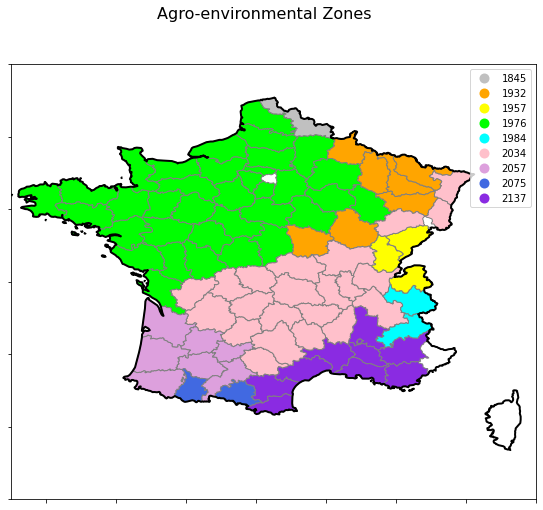

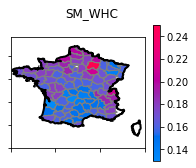

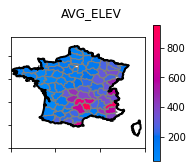

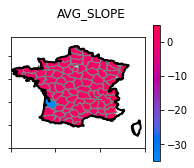

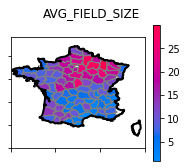

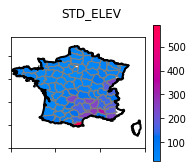

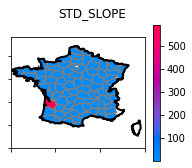

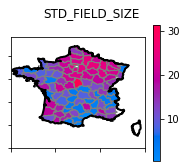

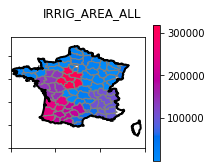

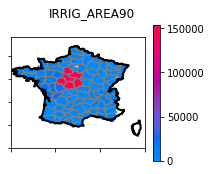

In [ ]:
from matplotlib.colors import ListedColormap

def plotCategoricalColumn(country, nuts_level, map_limits,
                          pd_show_df, show_col, color_map,
                          figure_title):
  pd_nuts0_df = getNUTSGeoPandasData(country, 'NUTS0')
  pd_nuts3_df = getNUTSGeoPandasData(country, nuts_level)
  fig, ax = plt.subplots(1, 1, figsize=(10, 8))

  categories = sorted(pd_show_df[show_col].unique())
  pd_nuts3_df = pd_nuts3_df.merge(pd_show_df, on=['COUNTRY', 'NUTS_ID'])
  base = pd_nuts3_df.plot(column=show_col, categorical=True,
                          categories=categories, ax=ax,
                          linewidth=1.0, edgecolor='gray',
                          legend=True, cmap=color_map)

  ax.set_xlim(map_limits['xmin'], map_limits['xmax'])
  ax.set_ylim(map_limits['ymin'], map_limits['ymax'])
  pd_nuts0_df.plot(ax=base, edgecolor='black', linewidth=2.0, facecolor="none")
  base.set(yticklabels=[])
  base.set(xticklabels=[])

  fig.suptitle(figure_title, fontsize=16)


id_df = combined_dfs['NUMERIC_IDS']
pd_static_df = combined_dfs['STATIC']

pd_static_df = pd_static_df.merge(id_df, on=['id0', 'id3']).drop(columns=['id0', 'id3'])
pd_static_df = pd_static_df.rename(columns={'IDREGION' : 'NUTS_ID'})

map_limits = {
      'xmin' : -5, 'xmax' : 10,
      'ymin' : 40, 'ymax' : 52,
}

vmin = pd_static_df['AEZ_ID'].min()
vmax = pd_static_df['AEZ_ID'].max()
title_label = 'Agro-environmental Zones'
color_map = ListedColormap(['silver', 'orange', 'yellow', 'lime',
                            'cyan', 'pink', 'plum', 'royalblue', 'blueviolet'])
plotCategoricalColumn('FR', 'NUTS3', map_limits, pd_static_df, 'AEZ_ID',
                      color_map, title_label)

show_cols = ['SM_WHC', 'AVG_ELEV', 'AVG_SLOPE', 'AVG_FIELD_SIZE',
             'STD_ELEV', 'STD_SLOPE', 'STD_FIELD_SIZE',
             'IRRIG_AREA_ALL', 'IRRIG_AREA' + str(crop_id)]
for ft in show_cols:
  vmin = pd_static_df[ft].min()
  vmax = pd_static_df[ft].max()
  plotStaticMaps('FR', 'NUTS3', map_limits, pd_static_df, [ft], red_blue,
                vmin, vmax, ft)

#### Training and Evaluation

In [ ]:
def trainAndTest(cyp_config, best_params,
                 train_dataset, test_dataset,
                 early_stopping=False,
                 pretrained=False, saved_net=None,
                 visualize=False, country=None):
  """
  1. Evaluate on validation data: num_valid_years = 5
  2. Evaluate on test data: num_valid_years = 0.
  """
  loss = nn.MSELoss()
  num_epochs = best_params['num_epochs']
  architecture = cyp_config['architecture']

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=best_params['batch_size'],
                                             shuffle=True, num_workers=2)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=best_params['batch_size'],
                                            shuffle=False, num_workers=2)

  y_max = 1.0 # torch.max(train_dataset[0][3]).item()/2
  # train_dataset is : X_ts, X_rest, X_trend. X_rest shape is (variables)
  num_other_features = train_dataset[0][1].shape[0]
  # X_trend shape is (trend_window)
  num_trend_features = train_dataset[0][2].shape[0]

  # X_ts shape is (dekads, variables)
  ts_seq_len = train_dataset[0][0].shape[0]
  num_ts_indicators = train_dataset[0][0].shape[1]

  device = d2l.try_gpu()
  assert architecture in ['1DCNN', 'LSTM'], 'Architecture is not supported. Must be 1DCNN or LSTM.'
  if (architecture == '1DCNN'):
    net = CYP1DCNNModel(num_ts_indicators,
                        num_trend_features,
                        num_other_features,
                        ts_seq_len=ts_seq_len,
                        num_outputs=1)
  elif (architecture == 'LSTM'):
    net = CYPLSTMModel(num_ts_indicators,
                       num_trend_features,
                       num_other_features,
                       ts_seq_len=ts_seq_len,
                       num_outputs=1)

  net = net.to(device)
  if (pretrained):
    net.load_state_dict(torch.load(saved_net))

  trainer = torch.optim.Adam(net.parameters(), lr=best_params['lr'],
                             weight_decay=best_params['weight_decay'])

  test_nrmse, epochs_run = train(net, train_loader, test_loader, loss, trainer, num_epochs,
                                 early_stopping=early_stopping, device=device,
                                 country=country, visualize=visualize, ymax=y_max)

  if (early_stopping):
    best_params['num_epochs'] = epochs_run

  print('NRMSE:', round(test_nrmse, 4))
  predictions, test_nrmse = evaluatePredictions(net, test_loader, device)

  return net, predictions, test_nrmse

#### Compute Feature Attributions for the test set

In [ ]:
import seaborn as sns
import captum
from captum.attr import Occlusion
from captum.attr import IntegratedGradients
from captum.attr import GradientShap

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import pandas as pd

ft_imports = {}
num_iters = 10
pd_cv_preds_all = None
pd_test_preds_all = None
static_ft_names = None
trend_ft_names = None
for i in range(1, num_iters + 1):
  """
  Evaluate on validation data with early stopping
  """
  iter_info = '\n' + 'Iteration ' + str(i)
  iter_info += '\n-------------------'
  print(iter_info)
  log_fh.write(iter_info)

  id_df = combined_dfs['NUMERIC_IDS']
  best_params['num_epochs'] = 100
  valid_info = '\n\nValidation Set Evaluation'
  valid_info += '\n----------------------------'
  print(valid_info)
  net, predictions, valid_nrmse = trainAndTest(cyp_config, best_params,
                                               datasets['valid'][0], datasets['valid'][1],
                                               early_stopping=True, visualize=False)
  valid_info = '\nValidation NRMSE:' + str(round(100 * valid_nrmse, 3))
  pd_cv_preds = pd.DataFrame(data=predictions, columns=["id0", "id3", "FYEAR", "YIELD", "YIELD_PRED"])
  pd_cv_preds = pd_cv_preds.merge(id_df, on=['id0', 'id3']).drop(columns=['id0', 'id3'])
  pd_cv_preds = pd_cv_preds[['COUNTRY', 'IDREGION', 'FYEAR', 'YIELD', 'YIELD_PRED']]

  if (pd_cv_preds_all is None):
    pd_cv_preds_all = pd_cv_preds
  else:
    pd_cv_preds_all = pd_cv_preds_all.append(pd_cv_preds)

  countries = pd_cv_preds['COUNTRY'].unique()
  valid_info += '\n\nValidation NRMSEs'
  valid_info += '\n---------------------'
  for cn in countries:
    cn_preds_df = pd_cv_preds[pd_cv_preds['COUNTRY'] == cn]
    cn_nrmse = NormalizedRMSE(cn_preds_df['YIELD'].values,
                              cn_preds_df['YIELD_PRED'].values)
    valid_info += '\n' + crop + ', '  + cn + ' NRMSE:' + str(cn_nrmse)

  print(valid_info)
  log_fh.write(valid_info)

  """
  Evaluate on test data with early stopping epochs from above
  """
  id_df = combined_dfs['NUMERIC_IDS']
  test_info = '\n\nTest Set Evaluation'
  test_info += '\n----------------------------'
  print(test_info)
  net, predictions, test_nrmse = trainAndTest(cyp_config, best_params,
                                              datasets['test'][0], datasets['test'][1],
                                              early_stopping=False, visualize=False)
  test_info = '\nTest NRMSE: ' + str(round(100 * test_nrmse, 2))
  pd_test_preds = pd.DataFrame(data=predictions, columns=["id0", "id3", "FYEAR", "YIELD", "YIELD_PRED"])
  pd_test_preds = pd_test_preds.merge(id_df, on=['id0', 'id3']).drop(columns=['id0', 'id3'])
  pd_test_preds = pd_test_preds[['COUNTRY', 'IDREGION', 'FYEAR', 'YIELD', 'YIELD_PRED']]

  if (pd_test_preds_all is None):
    pd_test_preds_all = pd_test_preds
  else:
    pd_test_preds_all = pd_test_preds_all.append(pd_test_preds)

  countries = pd_test_preds['COUNTRY'].unique()
  test_info += '\n\nTest NRMSEs'
  test_info += '\n-----------------'
  for cn in countries:
    cn_preds_df = pd_test_preds[pd_test_preds['COUNTRY'] == cn]
    cn_nrmse = NormalizedRMSE(cn_preds_df['YIELD'].values,
                              cn_preds_df['YIELD_PRED'].values)
    test_info += '\n' + crop + ', '  + cn + ' NRMSE:' + str(cn_nrmse)

  print(test_info)
  log_fh.write(test_info)

  attr_classes = {
      # pred1 = prediction with features in window set to 0
      # pred2 = prediction with features in window left untouched
      # Attributions = pred2 - pred1
      'Occlusion' : Occlusion(net),

      # Better to set multiply_by_inputs to True
      # Multiplying by inputs make the attribution global
      # (as opposed to local, see https://arxiv.org/pdf/1711.06104.pdf)
      'IntegratedGradients' : IntegratedGradients(net, multiply_by_inputs=True),

      # # See https://github.com/slundberg/shap for GradientShap
      'GradientShap' : GradientShap(net, multiply_by_inputs=True),
  }

  test_dataset = datasets['test'][1]
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=best_params['batch_size'],
                                            shuffle=False, num_workers=2)
  for j in range(num_iters):
    dekad_numbers = None
    for cname in attr_classes:
      # print('\n Feature importance using', cname)
      # print('-----------------------------------------------')
      ts_ft_attrs, static_ft_attrs, trend_ft_attrs = getFeatureAttributions(net,
                                                                            cyp_config['architecture'],
                                                                            test_loader,
                                                                            attr_classes[cname])

      if (cname in ft_imports):
        ft_imports[cname]['ts'] = ft_imports[cname]['ts'] + ts_ft_attrs
        ft_imports[cname]['static'] = ft_imports[cname]['static'] + static_ft_attrs
        ft_imports[cname]['trend'] = ft_imports[cname]['trend'] + trend_ft_attrs
      else:
        ft_imports[cname] = {
            'ts' : ts_ft_attrs,
            'static' : static_ft_attrs,
            'trend' : trend_ft_attrs
        }

# Save predictions
output_path = cyp_config['output_path']
pred_file = getPredictionFilename(cyp_config['crop'],
                                  cyp_config['use_yield_trend'],
                                  cyp_config['early_season_end_dekad'],
                                  cyp_config['country_code'],
                                  cyp_config['spatial_level'],
                                  cyp_config['architecture'])

pd_test_preds_all.to_csv(output_path + '/' + pred_file + '-mul.csv', index=False)

valid_info = '\n\nAverage Validation Set NRMSEs'
valid_info += '\n----------------------------'
countries = sorted(pd_cv_preds_all['COUNTRY'].unique())
for cn in countries:
  pd_cn_cv_preds = pd_cv_preds_all[pd_cv_preds_all['COUNTRY'] == cn]
  pd_cn_cv_preds = pd_cn_cv_preds.groupby(['IDREGION', 'FYEAR']).agg(YIELD_PRED=('YIELD_PRED', 'mean'),
                                                                     YIELD=('YIELD', 'mean' )).reset_index()
  cn_nrmse = round(NormalizedRMSE(pd_cn_cv_preds['YIELD'].values,
                                  pd_cn_cv_preds['YIELD_PRED'].values), 3)
  valid_info += '\n' + crop + ', '  + cn + ': ' + str(cn_nrmse)

print(valid_info)
log_fh.write(valid_info)

test_info = '\n\nAverage Test Set NRMSEs'
test_info += '\n----------------------------'
countries = sorted(pd_test_preds_all['COUNTRY'].unique())
for cn in countries:
  pd_cn_test_preds = pd_test_preds_all[pd_test_preds_all['COUNTRY'] == cn]
  pd_cn_test_preds = pd_cn_test_preds.groupby(['IDREGION', 'FYEAR']).agg(YIELD_PRED=('YIELD_PRED', 'mean'),
                                                                         YIELD=('YIELD', 'mean' )).reset_index()
  cn_nrmse = round(NormalizedRMSE(pd_cn_test_preds['YIELD'].values,
                                  pd_cn_test_preds['YIELD_PRED'].values), 3)
  
  test_info += '\n' + crop + ', '  + cn + ': ' + str(cn_nrmse)

log_fh.write(test_info)
print(test_info)


Iteration 1
-------------------


Validation Set Evaluation
----------------------------
NRMSE: 0.0895

Validation NRMSE:8.954

Validation NRMSEs
---------------------
soft wheat, FR NRMSE:8.954244844380115


Test Set Evaluation
----------------------------
NRMSE: 0.1351

Test NRMSE: 13.51

Test NRMSEs
-----------------
soft wheat, FR NRMSE:13.512299904671597

Iteration 2
-------------------


Validation Set Evaluation
----------------------------
NRMSE: 0.094

Validation NRMSE:9.395

Validation NRMSEs
---------------------
soft wheat, FR NRMSE:9.395088818364322


Test Set Evaluation
----------------------------
NRMSE: 0.1332

Test NRMSE: 13.32

Test NRMSEs
-----------------
soft wheat, FR NRMSE:13.321854501322713

Iteration 3
-------------------


Validation Set Evaluation
----------------------------
NRMSE: 0.093

Validation NRMSE:9.304

Validation NRMSEs
---------------------
soft wheat, FR NRMSE:9.303731546249544


Test Set Evaluation
----------------------------
NRMSE: 0.1396

Te

#### Compute feature attribtions over multiple runs

In [ ]:
import seaborn as sns
import captum
from captum.attr import Occlusion
from captum.attr import IntegratedGradients
from captum.attr import GradientShap

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import pandas as pd

ft_imports = {}
num_iters = 10
for i in range(1, num_iters + 1):
  """
  Evaluate on validation data with early stopping
  """
  iter_info = '\n' + 'Iteration ' + str(i)
  iter_info += '\n-------------------'
  print(iter_info)
  log_fh.write(iter_info)

  best_params['num_epochs'] = 100
  valid_info = '\n\nValidation Set Evaluation'
  valid_info += '\n----------------------------'
  print(valid_info)
  net, predictions, valid_nrmse = trainAndTest(cyp_config, best_params,
                                               datasets['valid'][0], datasets['valid'][1],
                                               early_stopping=True, visualize=False)
  valid_info = '\nValidation NRMSE:' + str(round(100 * valid_nrmse, 3))
  print(valid_info)
  log_fh.write(valid_info)

  """
  Evaluate on test data with early stopping epochs from above
  """
  test_info = '\n\nTest Set Evaluation'
  test_info += '\n----------------------------'
  print(test_info)
  net, predictions, test_nrmse = trainAndTest(cyp_config, best_params,
                                              datasets['test'][0], datasets['test'][1],
                                              early_stopping=False, visualize=False)
  test_info = '\nTest NRMSE: ' + str(round(100 * test_nrmse, 2))
  print(test_info)
  log_fh.write(test_info)

  attr_classes = {
      # pred1 = prediction with features in window set to 0
      # pred2 = prediction with features in window left untouched
      # Attributions = pred2 - pred1
      'Occlusion' : Occlusion(net),

      # Better to set multiply_by_inputs to True
      # Multiplying by inputs make the attribution global
      # (as opposed to local, see https://arxiv.org/pdf/1711.06104.pdf)
      'IntegratedGradients' : IntegratedGradients(net, multiply_by_inputs=True),

      # # See https://github.com/slundberg/shap for GradientShap
      'GradientShap' : GradientShap(net, multiply_by_inputs=True),
  }

  test_dataset = datasets['test'][1]
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=best_params['batch_size'],
                                            shuffle=False, num_workers=2)
  for j in range(num_iters):
    dekad_numbers = None
    for cname in attr_classes:
      # print('\n Feature importance using', cname)
      # print('-----------------------------------------------')
      ts_ft_attrs, static_ft_attrs, trend_ft_attrs = getFeatureAttributions(net,
                                                                            cyp_config['architecture'],
                                                                            test_loader,
                                                                            attr_classes[cname])

      ts_ft_attrs = np.expand_dims(ts_ft_attrs, axis=0)
      static_ft_attrs = np.expand_dims(static_ft_attrs, axis=0)
      trend_ft_attrs = np.expand_dims(trend_ft_attrs, axis=0)
      if (cname in ft_imports):
        ft_imports[cname]['ts'] = np.concatenate((ft_imports[cname]['ts'], ts_ft_attrs), axis=0)
        ft_imports[cname]['static'] = np.concatenate((ft_imports[cname]['static'], static_ft_attrs), axis=0)
        ft_imports[cname]['trend'] = np.concatenate((ft_imports[cname]['trend'], trend_ft_attrs), axis=0)
      else:
        ft_imports[cname] = {
            'ts' : ts_ft_attrs,
            'static' : static_ft_attrs,
            'trend' : trend_ft_attrs
        }


Iteration 1
-------------------


Validation Set Evaluation
----------------------------
NRMSE: 0.1074

Validation NRMSE:10.741


Test Set Evaluation
----------------------------
NRMSE: 0.1386

Test NRMSE: 13.86

Iteration 2
-------------------


Validation Set Evaluation
----------------------------
NRMSE: 0.0962

Validation NRMSE:9.617


Test Set Evaluation
----------------------------
NRMSE: 0.1332

Test NRMSE: 13.32

Iteration 3
-------------------


Validation Set Evaluation
----------------------------
NRMSE: 0.1005

Validation NRMSE:10.047


Test Set Evaluation
----------------------------
NRMSE: 0.1348

Test NRMSE: 13.48

Iteration 4
-------------------


Validation Set Evaluation
----------------------------
NRMSE: 0.1075

Validation NRMSE:10.748


Test Set Evaluation
----------------------------
NRMSE: 0.1326

Test NRMSE: 13.26

Iteration 5
-------------------


Validation Set Evaluation
----------------------------
NRMSE: 0.107

Validation NRMSE:10.697


Test Set Evaluation

#### Compute average coefficient of variation

In [ ]:
import numpy as np

save_data_path = r'drive/MyDrive/Wageningen PhD/Dilli - Deep Learning/saved-output/all-hundred-runs-SW'
ft_imports = {}

crop = 'soft wheat'
filename_suffixes = {
    'Occlusion' : 'ocl',
    'IntegratedGradients' : 'IG',
    'GradientShap' : 'GS',
}

es_suffix = 'early-6'
early_season_end = -6
for attr_method in filename_suffixes:
  filename_suffix = filename_suffixes[attr_method]
  ft_imports[attr_method] = {
      'ts' : np.load(save_data_path + '/ts_ft_imports-' + es_suffix + '-' + filename_suffix + '.npy'),
      'static' : np.load(save_data_path + '/static_ft_imports-' + es_suffix + '-' + filename_suffix + '.npy'),
      'trend' : np.load(save_data_path + '/trend_ft_imports-' + es_suffix + '-' + filename_suffix + '.npy')
  }


crop_calendars = {
    'sof_FR' : { 'p0' : [1, 11], 'p1' : [10, 12], 'p2' : [11, 29], 'p3' : [28, 30], 'p4' : [29, 34], 'p5' : [33, 35] },
    'gra_FR' : { 'p0' : [7, 18], 'p1' : [17, 19], 'p2' : [18, 25], 'p3' : [24, 26], 'p4' : [25, 34], 'p5' : [33, 35] },
}

cn_code = 'FR'
if (cn_code is None):
  crop_cn_code = crop[:3] + '_' + 'COM'
else:
  crop_cn_code = crop[:3] + '_' + cn_code

crop_cal = crop_calendars[crop_cn_code]

wofost_indicators = ['WLIM_YB', 'WLIM_YS', 'WLAI', 'RSM' ]
meteo_indicators = ['TMIN', 'TMAX', 'TAVG', 'PREC', 'CWB']
rs_indicators = [ 'FAPAR' ]
ts_indicator_names = wofost_indicators + meteo_indicators + rs_indicators

last_dekad = 36 + early_season_end

for cname in ft_imports:
  ts_ft_imports = ft_imports[cname]['ts']
  static_ft_imports = ft_imports[cname]['static']
  trend_ft_imports = ft_imports[cname]['trend']

  # avg_static_imports = np.mean(static_ft_imports, axis=1)
  # avg_trend_imports = np.mean(trend_ft_imports, axis=1)
  print(cname, 'static', np.mean(np.std(static_ft_imports, axis=0))) #/np.mean(avg_static_imports)))
  print(cname, 'trend', np.mean(np.std(trend_ft_imports, axis=0))) #/np.mean(avg_trend_imports)))
  print(cname, 'ts', np.mean(np.std(ts_ft_imports, axis=0)))

  avg_coeff_var = 0.0
  for i, p in enumerate(list(crop_cal.keys())):
    p_start, p_end = crop_cal[p]
    if (last_dekad < p_start):
      continue

    for j, ft in enumerate(ts_indicator_names):
      sel_ft_import = np.mean(ts_ft_imports[:, :, p_start-1:p_end, j], axis=1)
      avg_sel_ft_import = np.mean(sel_ft_import, axis=1)
      coeff_var = np.mean(np.std(avg_sel_ft_import, axis=0)/np.mean(avg_sel_ft_import))
      # print(cname, 'ts', p, ft, coeff_val)
      avg_coeff_var += coeff_var

  # print(cname, 'ts', avg_coeff_var)

# filename_suffixes = {
#     'Occlusion' : 'ocl',
#     'IntegratedGradients' : 'IG',
#     'GradientShap' : 'GS',
# }

# early_season_end = cyp_config['early_season_end_dekad']
# es_suffix = 'end'
# if (early_season_end == -6):
#   es_suffix = 'early-6'

# save_data_path = r'drive/MyDrive/Wageningen PhD/Dilli - Deep Learning/saved-output/all-hundred-runs-SW'

# for attr_method in ft_imports:
#   ts_ft_imports = ft_imports[attr_method]['ts']
#   static_ft_imports = ft_imports[attr_method]['static']
#   trend_ft_imports = ft_imports[attr_method]['trend']
#   filename_suffix = filename_suffixes[attr_method]
#   ft_import_filenames = ['ts_ft_imports-' + es_suffix + '-' + filename_suffix + '.npy',
#                          'static_ft_imports-' + es_suffix + '-' + filename_suffix + '.npy',
#                          'trend_ft_imports-' + es_suffix + '-' + filename_suffix + '.npy']

#   ft_import_arrays = [ts_ft_imports, static_ft_imports, trend_ft_imports]
#   for i, fname in enumerate(ft_import_filenames):
#     with open(save_data_path + '/' + fname, 'wb') as f:
#       np.save(f, ft_import_arrays[i])

Occlusion static 0.07801915
Occlusion trend 0.15369862
Occlusion ts 0.03266262
IntegratedGradients static 0.07808600152615063
IntegratedGradients trend 0.1537401182634869
IntegratedGradients ts 0.02140228140976646
GradientShap static 0.0459359
GradientShap trend 0.08775252
GradientShap ts 0.017169105


#### Compute Wasserstein distances for attributions

In [ ]:
import scipy.stats as stats

ref_features = {
    'p0' : ['CWB'],
    'p1' : ['TAVG', 'TMIN', 'PREC', 'CWB'],
    'p2' : ['WLIM_YB', 'WLAI', 'RSM', 'TAVG', 'CWB', 'FAPAR'],
    'p3' : ['RSM', 'TMAX', 'PREC'],
    'p4' : ['WLIM_YB', 'WLAI', 'WLIM_YS', 'RSM', 'FAPAR'],
    'p5' : ['PREC'],
}

crop_calendars = {
    'sof_FR' : { 'p0' : [1, 11], 'p1' : [10, 12], 'p2' : [11, 29], 'p3' : [28, 30], 'p4' : [29, 34], 'p5' : [33, 35] },
    'gra_FR' : { 'p0' : [7, 18], 'p1' : [17, 19], 'p2' : [18, 25], 'p3' : [24, 26], 'p4' : [25, 34], 'p5' : [33, 35] },
}

cn_code = cyp_config['country_code']
if (cn_code is None):
  crop_cn_code = crop[:3] + '_' + 'COM'
else:
  crop_cn_code = crop[:3] + '_' + cn_code

crop_cal = crop_calendars[crop_cn_code]
print('\n')
print(crop, cn_code)

max_dekad = 36
last_dekad = max_dekad + cyp_config['early_season_end_dekad']
ts_indicator_names = wofost_indicators + meteo_indicators + rs_indicators

# Reference :
# TAVG, CWB    RSM, TAVG  
# ----------|-------------|---------------|------------|-----------------------
ref_ts_import = np.zeros((len(ts_indicator_names), max_dekad))
for p in crop_cal:
  p_fts = ref_features[p]
  p_start, p_end = crop_cal[p]
  if (last_dekad < p_start):
    continue

  for ft in p_fts:
    idx = ts_indicator_names.index(ft)
    for i in range(p_start - 1, p_end):
      ref_ts_import[idx][i] = 1

# print(np.sum(ref_ts_import, axis=1))
ref_ts_import_sum = np.sum(ref_ts_import, axis=1)
for i, ft in enumerate(ts_indicator_names):
  ref_ts_import[i, :] = ref_ts_import[i, :]/ref_ts_import_sum[i]

# Now the sums must be all 1's
# print(np.sum(ref_ts_import, axis=1))

# DL important features
#  ...                            RSM
# ----------|-------------|---------------|------------|-----------------------

# combinining features importance from different methods
attr_methods = list(ft_imports.keys())
combo_ts_imports = None
combo_static_imports = None
combo_trend_imports = None
for cname in attr_methods:
  if (combo_ts_imports is None):
    combo_ts_imports = ft_imports[cname]['ts']
    combo_static_imports = ft_imports[cname]['static']
    combo_trend_imports = ft_imports[cname]['trend']
  else:
    combo_ts_imports = combo_ts_imports + ft_imports[cname]['ts']
    combo_static_imports = combo_static_imports + ft_imports[cname]['static']
    combo_trend_imports = combo_trend_imports + ft_imports[cname]['trend']

ft_imports['combined'] = {
    'ts' : combo_ts_imports,
    'static' : combo_static_imports,
    'trend' : combo_trend_imports
}

wasserstein_dists = {}
pred_last_dekad = 36 + cyp_config['early_season_end_dekad']
saved_ft_imports = {}
for cname in ft_imports:
  ts_imports = ft_imports[cname]['ts']
  sel_method_wass_dists = 0
  for i, ft in enumerate(ts_indicator_names):
    if (cyp_config['architecture'] == '1DCNN'):
      # TODO: should it be avg of absolute values?
      sel_ft_import = np.mean(np.abs(ts_imports[:, i, :]), axis=0)
    else:
      sel_ft_import = np.mean(np.abs(ts_imports[:, :, i]), axis=0)

    sel_ft_import = sel_ft_import/np.sum(sel_ft_import)
    wass_dist = stats.wasserstein_distance(ref_ts_import[i, :pred_last_dekad], sel_ft_import)
    sel_method_wass_dists += wass_dist
    if (cname not in saved_ft_imports):
      saved_ft_imports[cname] = [sel_ft_import/np.sum(sel_ft_import)]
    else:
      saved_ft_imports[cname] = saved_ft_imports[cname] + [sel_ft_import/np.sum(sel_ft_import)]

  wasserstein_dists[cname] = sel_method_wass_dists

attr_methods = list(ft_imports.keys())
for i in range(len(attr_methods) -1):
  wass_dist = 0
  am1 = attr_methods[i]
  for j in range(i+1, len(attr_methods)):
    am2 = attr_methods[j]
    for k, ft in enumerate(ts_indicator_names):
      sel_ft_import1 = saved_ft_imports[am1][k]
      sel_ft_import2 = saved_ft_imports[am2][k]
      wass_dist += stats.wasserstein_distance(sel_ft_import1, sel_ft_import2)

    print('Wasserstein distance for ', am1, am2, wass_dist)

# determine the best attribution method
min_wass_dist = None
best_attr_method = None
for cname in wasserstein_dists:
  print('Wasserstein distance for ', cname + ': ', wasserstein_dists[cname])
  if ((best_attr_method is None) or (wasserstein_dists[cname] < min_wass_dist)):
    min_wass_dist = wasserstein_dists[cname]
    best_attr_method = cname

print('Best method (min Wasserstein distance):', best_attr_method)

# select feature attributions from the best method
ts_ft_imports = ft_imports[best_attr_method]['ts']
static_ft_imports = ft_imports[best_attr_method]['static']
trend_ft_imports = ft_imports[best_attr_method]['trend']

# Compute https://en.wikipedia.org/wiki/Wasserstein_metric
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wasserstein_distance.html



soft wheat FR
Wasserstein distance for  Occlusion IntegratedGradients 0.10638089512277021
Wasserstein distance for  Occlusion GradientShap 0.21484171745945635
Wasserstein distance for  Occlusion combined 0.271637198029353
Wasserstein distance for  IntegratedGradients GradientShap 0.00503226346796906
Wasserstein distance for  IntegratedGradients combined 0.06359175924880779
Wasserstein distance for  GradientShap combined 0.05987953045545285
Wasserstein distance for  Occlusion:  0.2661342215122676
Wasserstein distance for  IntegratedGradients:  0.3034585354411766
Wasserstein distance for  GradientShap:  0.3037801961518353
Wasserstein distance for  combined:  0.2840515569385116
Best method (min Wasserstein distance): Occlusion


#### Save feature values and feature importance

In [ ]:
test_dataset = datasets['test'][1]
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=best_params['batch_size'],
                                          shuffle=False, num_workers=2)
X_ts_all, X_static_all, X_trend_all, Y_all = getFeatureValues(test_loader)
ts_ft_names = wofost_indicators + meteo_indicators + rs_indicators
static_ft_names = test_dataset.getStaticFeatureCols()
trend_ft_names = ['YIELD-5', 'YIELD-4', 'YIELD-3', 'YIELD-2', 'YIELD-1']

# z = (x - avg(x)/std(x)
# invert : x = z * std(x) + avg(x)
# for i, ft in enumerate(ts_ft_names):
#   X_ts_all[:, :, i] = X_ts_all[:, :, i] * scaler_args[ft][1] + scaler_args[ft][0]

# for i, ft in enumerate(trend_ft_names):
#   X_trend_all[:, i] = X_trend_all[:, i] * scaler_args[ft][1] + scaler_args[ft][0]

# for i, ft in enumerate(static_ft_names):
#   # CN feature can have 0.0 std
#   if (scaler_args[ft][1] > 0.0):
#     X_static_all[:, i] = X_static_all[:, i] * scaler_args[ft][1] + scaler_args[ft][0]

architecture = cyp_config['architecture']
early_season_end = cyp_config['early_season_end_dekad']
es_suffix = 'end'
if (early_season_end == -6):
  es_suffix = 'early-6'

save_data_path = r'drive/MyDrive/Wageningen PhD/Dilli - Deep Learning/saved-output/ft-import-SW-FR-' + architecture
ft_values_filenames = ['ts_ft_values-' + es_suffix + '.npy', 'static_ft_values-' + es_suffix + '.npy',
                       'trend_ft_values-' + es_suffix + '.npy', 'Y_values-' + es_suffix + '.npy']
ft_val_arrays = [X_ts_all, X_static_all, X_trend_all, Y_all]
for i, fname in enumerate(ft_values_filenames):
  with open(save_data_path + '/' + fname, 'wb') as f:
    np.save(f, ft_val_arrays[i])

filename_suffixes = {
    'Occlusion' : 'ocl',
    'IntegratedGradients' : 'IG',
    'GradientShap' : 'GS',
    'combined' : 'com'
}

for attr_method in ft_imports:
  ts_ft_imports = ft_imports[attr_method]['ts']
  static_ft_imports = ft_imports[attr_method]['static']
  trend_ft_imports = ft_imports[attr_method]['trend']
  filename_suffix = filename_suffixes[attr_method]
  ft_import_filenames = ['ts_ft_imports-' + es_suffix + '-' + filename_suffix + '.npy',
                         'static_ft_imports-' + es_suffix + '-' + filename_suffix + '.npy',
                         'trend_ft_imports-' + es_suffix + '-' + filename_suffix + '.npy']

  ft_import_arrays = [ts_ft_imports, static_ft_imports, trend_ft_imports]
  for i, fname in enumerate(ft_import_filenames):
    with open(save_data_path + '/' + fname, 'wb') as f:
      np.save(f, ft_import_arrays[i])

#### Load saved feature attributions

In [ ]:

architecture = cyp_config['architecture']
save_data_path = r'drive/MyDrive/Wageningen PhD/Dilli - Deep Learning/saved-output/ft-import-SW-FR-' + architecture
ft_imports = {}

filename_suffixes = {
    'Occlusion' : 'ocl',
    'IntegratedGradients' : 'IG',
    'GradientShap' : 'GS',
    'combined' : 'com'
}

es_suffix = 'end'
if (early_season_end == -6):
  es_suffix = 'early-6'

for attr_method in filename_suffixes:
  filename_suffix = filename_suffixes[attr_method]
  ft_imports[attr_method] = {
      'ts' : np.load(save_data_path + '/ts_ft_imports-' + es_suffix + '-' + filename_suffix + '.npy'),
      'static' : np.load(save_data_path + '/static_ft_imports-' + es_suffix + '-' + filename_suffix + '.npy'),
      'trend' : np.load(save_data_path + '/trend_ft_imports-' + es_suffix + '-' + filename_suffix + '.npy')
  }

X_ts_all = np.load(save_data_path + '/ts_ft_values-' + es_suffix + '.npy')
X_static_all = np.load(save_data_path + '/static_ft_values-' + es_suffix + '.npy')
X_trend_all = np.load(save_data_path + '/trend_ft_values-' + es_suffix + '.npy')
Y_all = np.load(save_data_path + '/Y_values-' + es_suffix + '.npy')
print(save_data_path + '/Y_values-' + es_suffix + '.npy')

# select GradientShap feature attributions
ts_ft_imports = ft_imports['GradientShap']['ts']
static_ft_imports = ft_imports['GradientShap']['static']
trend_ft_imports = ft_imports['GradientShap']['trend']

print(ts_ft_imports.shape, X_ts_all.shape)

ts_ft_names = wofost_indicators + meteo_indicators + rs_indicators
if (crop == 'grain maize'):
  static_ft_names = ['SM_WHC', 'AVG_ELEV', 'STD_ELEV', 'AVG_SLOPE', 'STD_SLOPE', 'AVG_FIELD_SIZE', 'STD_FIELD_SIZE',
                     'IRRIG_AREA_ALL', 'IRRIG_AREA2']
  static_ft_names += ['AEZ_1845', 'AEZ_1932', 'AEZ_1957', 'AEZ_1976', 'AEZ_1984', 'AEZ_2034', 'AEZ_2057',
                      'AEZ_2075', 'AEZ_2137']
else:
  static_ft_names = ['SM_WHC', 'AVG_ELEV', 'STD_ELEV', 'AVG_SLOPE', 'STD_SLOPE', 'AVG_FIELD_SIZE', 'STD_FIELD_SIZE',
                     'IRRIG_AREA_ALL', 'IRRIG_AREA90']
  static_ft_names += ['AEZ_1845', 'AEZ_1932', 'AEZ_1957', 'AEZ_1976', 'AEZ_1984', 'AEZ_2034', 'AEZ_2057',
                      'AEZ_2075', 'AEZ_2137']

trend_ft_names = ['YIELD-5', 'YIELD-4', 'YIELD-3', 'YIELD-2', 'YIELD-1']

# z = (x - avg(x)/std(x)
# invert : x = z * std(x) + avg(x)
for i, ft in enumerate(ts_ft_names):
  # print(ft, scaler_args[ft][0], scaler_args[ft][1])
  X_ts_all[:, :, i] = np.round(X_ts_all[:, :, i] * scaler_args[ft][1] + scaler_args[ft][0], 3)
  # print(ft, X_ts_all[:, :, i].min(), X_ts_all[:, :, i].max())

for i, ft in enumerate(trend_ft_names):
  # print(ft, scaler_args[ft][0], scaler_args[ft][1])
  X_trend_all[:, i] = np.round(X_trend_all[:, i] * scaler_args[ft][1] + scaler_args[ft][0], 3)

for i, ft in enumerate(static_ft_names):
  # CN feature can have 0.0 std
  if (scaler_args[ft][1] > 0.0):
    # print(ft, scaler_args[ft][0], scaler_args[ft][1])
    X_static_all[:, i] = np.round(X_static_all[:, i] * scaler_args[ft][1] + scaler_args[ft][0], 3)


drive/MyDrive/Wageningen PhD/Dilli - Deep Learning/saved-output/ft-import-SW-FR-LSTM/Y_values-early-6.npy
(792, 30, 10) (792, 30, 10)


#### Ranked plot of all features



soft wheat FR


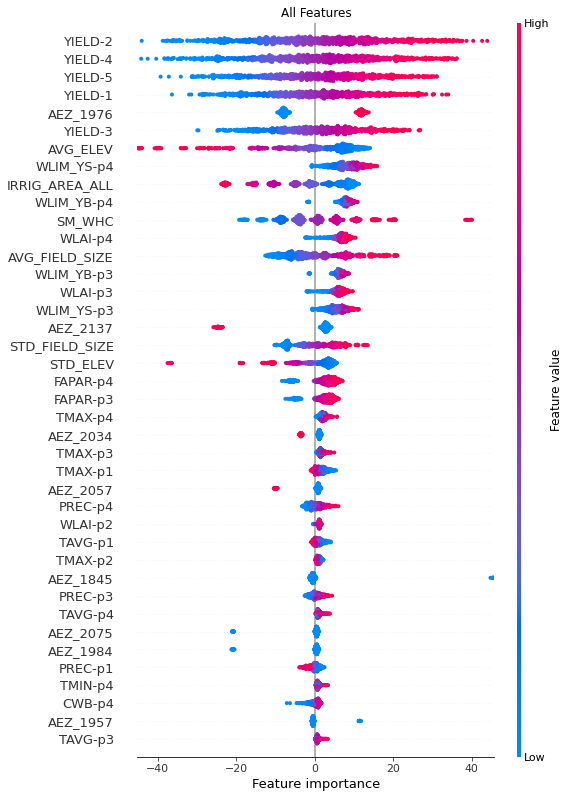

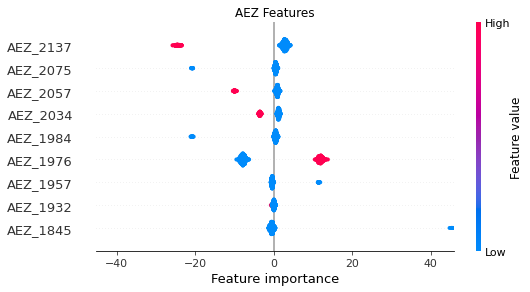

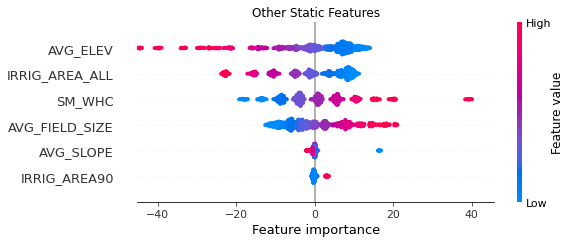

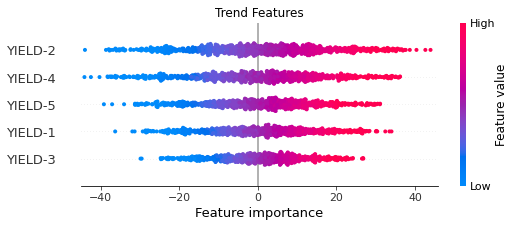

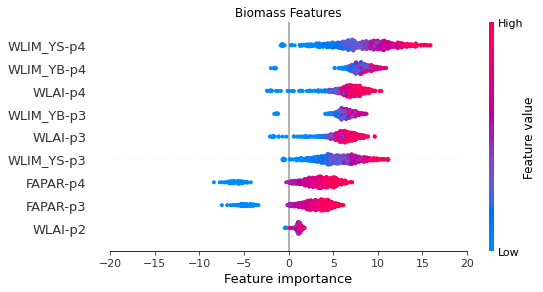

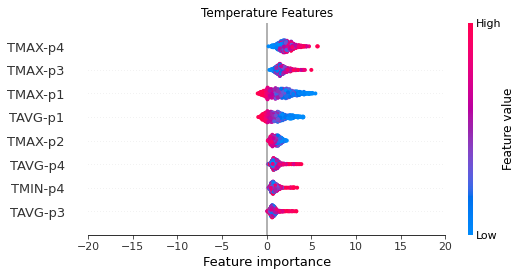

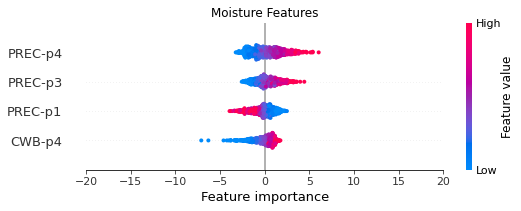

In [ ]:
architecture = cyp_config['architecture']

early_season_end = cyp_config['early_season_end_dekad']
last_dekad = 36 + early_season_end

crop_calendars = {
    'sof_FR' : { 'p0' : [1, 11], 'p1' : [10, 12], 'p2' : [11, 29], 'p3' : [28, 30], 'p4' : [29, 34], 'p5' : [33, 35] },
    'gra_FR' : { 'p0' : [7, 18], 'p1' : [17, 19], 'p2' : [18, 25], 'p3' : [24, 26], 'p4' : [25, 34], 'p5' : [33, 35] },
}

crop = cyp_config['crop']
cn_code = cyp_config['country_code']

if (cn_code is None):
  crop_cn_code = crop[:3] + '_' + 'COM'
else:
  crop_cn_code = crop[:3] + '_' + cn_code

crop_cal = crop_calendars[crop_cn_code]
print('\n')
print(crop, cn_code)

X_ts_periods = np.zeros((X_ts_all.shape[0], X_ts_all.shape[2] * 6))
if (architecture == '1DCNN'):
  ts_ft_imports_periods = np.zeros((ts_ft_imports.shape[0], ts_ft_imports.shape[1] * 6))
else:
  ts_ft_imports_periods = np.zeros((ts_ft_imports.shape[0], ts_ft_imports.shape[2] * 6))

crop_cal_periods = list(crop_cal.keys())
ts_periods_dict = {}
ts_period_ft_names = []
for i, ft in enumerate(ts_ft_names):
  for j, p in enumerate(crop_cal_periods):
    p_start, p_end = crop_cal[p]
    period_ft_index = i * len(crop_cal_periods) + j
    ts_period_ft_names.append(ft + '-p' + str(j))
    if (last_dekad < p_start):
      continue

    X_ts_periods[:, period_ft_index] = np.mean(X_ts_all[:, p_start-1:p_end, i], axis=1)
    if (architecture == '1DCNN'):
      ts_ft_imports_periods[:, period_ft_index] = np.mean(ts_ft_imports[:, i, p_start-1:p_end], axis=1)
    else:
      ts_ft_imports_periods[:, period_ft_index] = np.mean(ts_ft_imports[:, p_start-1:p_end, i], axis=1)

all_ft_vals = np.append(X_trend_all, X_static_all, axis=1)
all_ft_vals = np.append(all_ft_vals, X_ts_periods, axis=1)
all_ft_imports = np.append(trend_ft_imports, static_ft_imports, axis=1)
all_ft_imports = np.append(all_ft_imports, ts_ft_imports_periods, axis=1)
all_ft_cols = trend_ft_names + static_ft_names + ts_period_ft_names

# sort the arrays based on average feature importance
avg_ft_import = np.mean(np.abs(all_ft_imports), axis=0)
sort_idxs = np.argsort(avg_ft_import)
ranked_ft_imports = all_ft_imports[:, sort_idxs]
ranked_ft_vals = all_ft_vals[:, sort_idxs]

sorted_ft_names = []
for idx in sort_idxs:
  sorted_ft_names.append(all_ft_cols[idx])

xlabel = "Feature importance"
axis_color="#333333"
ftval_color = red_blue

xmin = np.min(all_ft_imports)
xmax = np.max(all_ft_imports)
beeswarmPlot(ranked_ft_imports[:, -40:], ranked_ft_vals[:, -40:],
             sorted_ft_names[-40:],
             xlabel, ftval_color, axis_color,
             xmin, xmax, 'All_Features')

top_40_fts = sorted_ft_names[-40:]
# plot AEZ features
AEZ_ft_idxs = []
AEZ_fts = []
for idx, ft in enumerate(all_ft_cols):
  if ('AEZ' in ft):
    AEZ_ft_idxs.append(idx)
    AEZ_fts.append(ft)

beeswarmPlot(all_ft_imports[:, AEZ_ft_idxs], all_ft_vals[:, AEZ_ft_idxs],
             AEZ_fts,
             xlabel, ftval_color, axis_color,
             xmin, xmax, 'AEZ_Features')

# plot other static features
other_static_fts = []
other_static_idxs = []
for idx, ft in enumerate(sorted_ft_names):
  if (('AEZ' not in ft) and ('YIELD' not in ft) and
      ('p' not in ft) and ('STD' not in ft)): # and
    #  (ft in top_40_fts)):
    other_static_idxs.append(idx)
    other_static_fts.append(ft)

beeswarmPlot(ranked_ft_imports[:, other_static_idxs], ranked_ft_vals[:, other_static_idxs],
             other_static_fts,
             xlabel, ftval_color, axis_color,
             xmin, xmax, 'Other_Static_Features')

# plot TREND features
trend_fts = []
trend_idxs = []
for idx, ft in enumerate(sorted_ft_names):
  if (('YIELD' in ft) and (ft in top_40_fts)):
    trend_idxs.append(idx)
    trend_fts.append(ft)

beeswarmPlot(ranked_ft_imports[:, trend_idxs], ranked_ft_vals[:, trend_idxs],
             trend_fts,
             xlabel, ftval_color, axis_color,
             xmin, xmax, 'Trend_Features')

xmin = -20
xmax = 20
# plot biomass features
biomass_fts = []
biomass_ft_idxs = []
for idx, ft in enumerate(sorted_ft_names):
  if ((('WLIM' in ft) or ('WLAI' in ft) or ('FAPAR' in ft)) and
      (ft in top_40_fts)):
    biomass_ft_idxs.append(idx)
    biomass_fts.append(ft)

beeswarmPlot(ranked_ft_imports[:, biomass_ft_idxs], ranked_ft_vals[:, biomass_ft_idxs],
             biomass_fts,
             xlabel, ftval_color, axis_color,
             xmin, xmax, 'Biomass_Features')

# plot temperature features
temp_fts = []
temp_ft_idxs = []
for idx, ft in enumerate(sorted_ft_names):
  if ((('TMIN' in ft) or ('TMAX' in ft) or ('TAVG' in ft)) and
      (ft in top_40_fts)):
    temp_ft_idxs.append(idx)
    temp_fts.append(ft)

beeswarmPlot(ranked_ft_imports[:, temp_ft_idxs], ranked_ft_vals[:, temp_ft_idxs],
             temp_fts,
             xlabel, ftval_color, axis_color,
             xmin, xmax, 'Temperature_Features')

# plot moisture features
moisture_fts = []
moisture_ft_idxs = []
for idx, ft in enumerate(sorted_ft_names):
  if ((('PREC' in ft) or ('CWB' in ft) or ('RSM' in ft)) and
      (ft in top_40_fts)):
    moisture_ft_idxs.append(idx)
    moisture_fts.append(ft)

beeswarmPlot(ranked_ft_imports[:, moisture_ft_idxs], ranked_ft_vals[:, moisture_ft_idxs],
             moisture_fts,
             xlabel, ftval_color, axis_color,
             xmin, xmax, 'Moisture_Features')


#### Ranked plot of features - Selected year



soft wheat FR


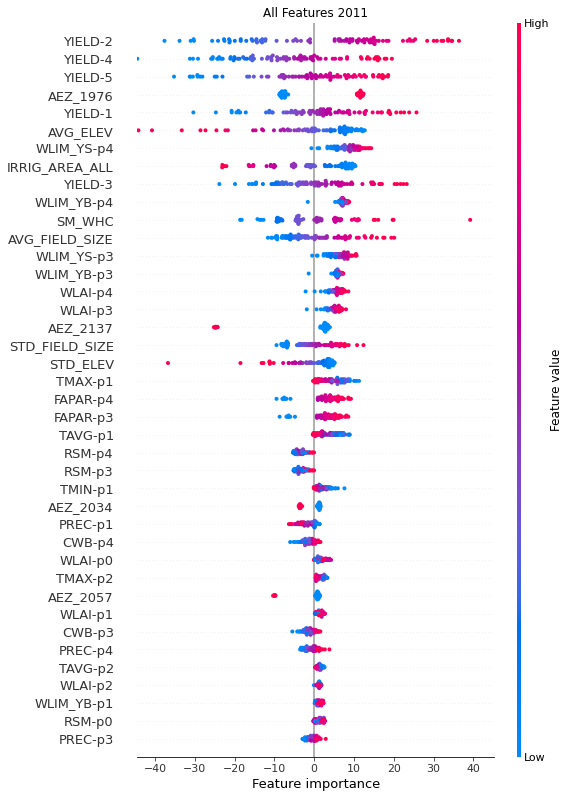

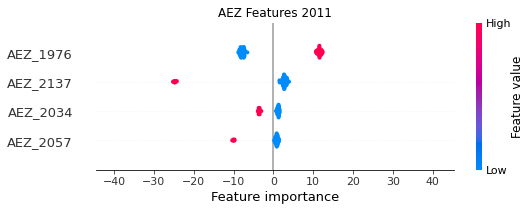

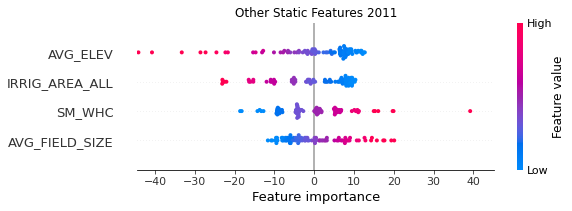

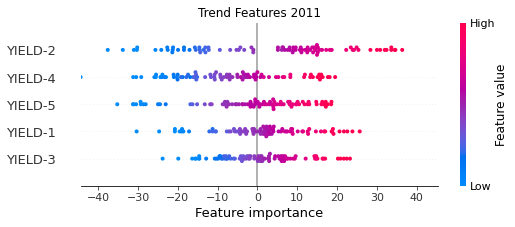

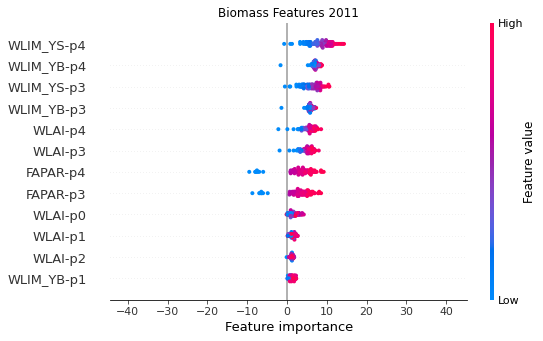

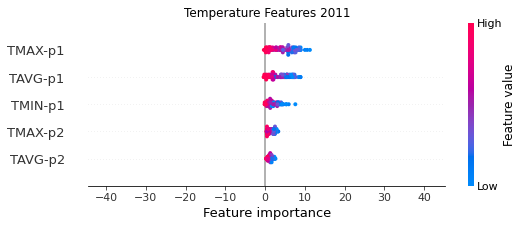

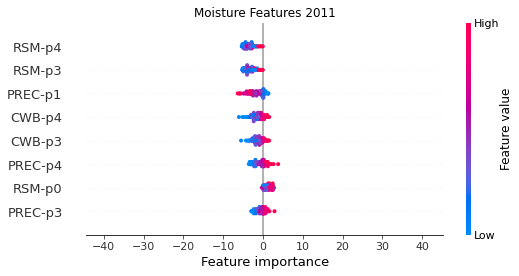

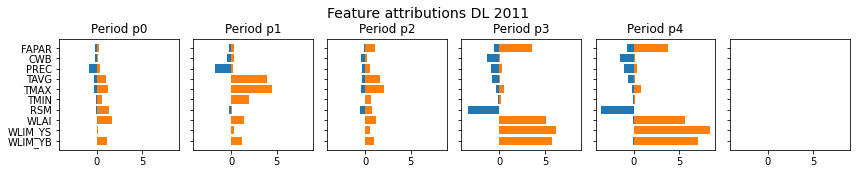

In [ ]:
architecture = cyp_config['architecture']

sel_year = 2011
early_season_end = cyp_config['early_season_end_dekad']
last_dekad = 36 + early_season_end

crop_calendars = {
    'sof_FR' : { 'p0' : [1, 11], 'p1' : [10, 12], 'p2' : [11, 29], 'p3' : [28, 30], 'p4' : [29, 34], 'p5' : [33, 35] },
    'gra_FR' : { 'p0' : [7, 18], 'p1' : [17, 19], 'p2' : [18, 25], 'p3' : [24, 26], 'p4' : [25, 34], 'p5' : [33, 35] },
}

crop = cyp_config['crop']
cn_code = cyp_config['country_code']

if (cn_code is None):
  crop_cn_code = crop[:3] + '_' + 'COM'
else:
  crop_cn_code = crop[:3] + '_' + cn_code

crop_cal = crop_calendars[crop_cn_code]
print('\n')
print(crop, cn_code)

sel_idxs = np.nonzero(Y_all[:, 2] == sel_year)[0]
ts_sel_imports = ts_ft_imports[sel_idxs, :, :]
static_sel_imports = static_ft_imports[sel_idxs, :]
trend_sel_imports = trend_ft_imports[sel_idxs, :]
X_ts_sel = X_ts_all[sel_idxs, :, :]
X_static_sel = X_static_all[sel_idxs, :]
X_trend_sel = X_trend_all[sel_idxs, :]

X_ts_periods = np.zeros((X_ts_sel.shape[0], X_ts_sel.shape[2] * 6))
if (architecture == '1DCNN'):
  ts_ft_imports_periods = np.zeros((ts_sel_imports.shape[0], ts_sel_imports.shape[1] * 6))
else:
  ts_ft_imports_periods = np.zeros((ts_sel_imports.shape[0], ts_sel_imports.shape[2] * 6))

ts_ft_names = wofost_indicators + meteo_indicators + rs_indicators
crop_cal_periods = list(crop_cal.keys())
ts_periods_dict = {}
ts_period_ft_names = []
for i, ft in enumerate(ts_ft_names):
  for j, p in enumerate(crop_cal_periods):
    p_start, p_end = crop_cal[p]
    period_ft_index = i * len(crop_cal_periods) + j
    ts_period_ft_names.append(ft + '-p' + str(j))
    if (last_dekad < p_start):
      continue

    X_ts_periods[:, period_ft_index] = np.mean(X_ts_sel[:, p_start-1:p_end, i], axis=1)
    if (architecture == '1DCNN'):
      ts_ft_imports_periods[:, period_ft_index] = np.mean(ts_sel_imports[:, i, p_start-1:p_end], axis=1)
    else:
      ts_ft_imports_periods[:, period_ft_index] = np.mean(ts_sel_imports[:, p_start-1:p_end, i], axis=1)

if (crop == 'grain maize'):
  static_ft_names = ['SM_WHC', 'AVG_ELEV', 'STD_ELEV', 'AVG_SLOPE', 'STD_SLOPE', 'AVG_FIELD_SIZE', 'STD_FIELD_SIZE',
                     'IRRIG_AREA_ALL', 'IRRIG_AREA2']
  static_ft_names += ['AEZ_1845', 'AEZ_1932', 'AEZ_1957', 'AEZ_1976', 'AEZ_1984', 'AEZ_2034', 'AEZ_2057',
                      'AEZ_2075', 'AEZ_2137']
else:
  static_ft_names = ['SM_WHC', 'AVG_ELEV', 'STD_ELEV', 'AVG_SLOPE', 'STD_SLOPE', 'AVG_FIELD_SIZE', 'STD_FIELD_SIZE',
                     'IRRIG_AREA_ALL', 'IRRIG_AREA90']
  static_ft_names += ['AEZ_1845', 'AEZ_1932', 'AEZ_1957', 'AEZ_1976', 'AEZ_1984', 'AEZ_2034', 'AEZ_2057',
                      'AEZ_2075', 'AEZ_2137']

trend_ft_names = ['YIELD-5', 'YIELD-4', 'YIELD-3', 'YIELD-2', 'YIELD-1']
all_ft_vals = np.append(X_trend_sel, X_static_sel, axis=1)
all_ft_vals = np.append(all_ft_vals, X_ts_periods, axis=1)
all_ft_imports = np.append(trend_sel_imports, static_sel_imports, axis=1)
all_ft_imports = np.append(all_ft_imports, ts_ft_imports_periods, axis=1)
all_ft_cols = trend_ft_names + static_ft_names + ts_period_ft_names

# sort the arrays based on average feature importance
avg_ft_import = np.mean(np.abs(all_ft_imports), axis=0)
sort_idxs = np.argsort(avg_ft_import)
all_ft_imports = all_ft_imports[:, sort_idxs]
all_ft_vals = all_ft_vals[:, sort_idxs]

sorted_ft_names = []
for idx in sort_idxs:
  sorted_ft_names.append(all_ft_cols[idx])

xlabel = "Feature importance"
axis_color="#333333"
ftval_color = red_blue

xmin = np.min(all_ft_imports)
xmax = np.max(all_ft_imports)
beeswarmPlot(all_ft_imports[:, -40:], all_ft_vals[:, -40:],
             sorted_ft_names[-40:],
             xlabel, ftval_color, axis_color,
             xmin, xmax, 'All_Features_' + str(sel_year))

top_40_fts = sorted_ft_names[-40:]
# plot AEZ features
AEZ_ft_idxs = []
AEZ_fts = []
for idx, ft in enumerate(sorted_ft_names):
  if (('AEZ' in ft) and (ft in top_40_fts)):
    AEZ_ft_idxs.append(idx)
    AEZ_fts.append(ft)

beeswarmPlot(all_ft_imports[:, AEZ_ft_idxs], all_ft_vals[:, AEZ_ft_idxs],
             AEZ_fts,
             xlabel, ftval_color, axis_color,
             xmin, xmax, 'AEZ_Features_' + str(sel_year))

# plot other static features
other_static_fts = []
other_static_idxs = []
for idx, ft in enumerate(sorted_ft_names):
  if (('AEZ' not in ft) and ('YIELD' not in ft) and
      ('p' not in ft) and ('STD' not in ft) and
      (ft in top_40_fts)):
    other_static_idxs.append(idx)
    other_static_fts.append(ft)

beeswarmPlot(all_ft_imports[:, other_static_idxs], all_ft_vals[:, other_static_idxs],
             other_static_fts,
             xlabel, ftval_color, axis_color,
             xmin, xmax, 'Other_Static_Features_' + str(sel_year))

# plot TREND features
trend_fts = []
trend_idxs = []
for idx, ft in enumerate(sorted_ft_names):
  if (('YIELD' in ft) and (ft in top_40_fts)):
    trend_idxs.append(idx)
    trend_fts.append(ft)

beeswarmPlot(all_ft_imports[:, trend_idxs], all_ft_vals[:, trend_idxs],
             trend_fts,
             xlabel, ftval_color, axis_color,
             xmin, xmax, 'Trend_Features_' + str(sel_year))

# plot biomass features
biomass_fts = []
biomass_ft_idxs = []
for idx, ft in enumerate(sorted_ft_names):
  if ((('WLIM' in ft) or ('WLAI' in ft) or ('FAPAR' in ft)) and
      (ft in top_40_fts)):
    biomass_ft_idxs.append(idx)
    biomass_fts.append(ft)

beeswarmPlot(all_ft_imports[:, biomass_ft_idxs], all_ft_vals[:, biomass_ft_idxs],
             biomass_fts,
             xlabel, ftval_color, axis_color,
             xmin, xmax, 'Biomass_Features_' + str(sel_year))

# plot temperature features
temp_fts = []
temp_ft_idxs = []
for idx, ft in enumerate(sorted_ft_names):
  if ((('TMIN' in ft) or ('TMAX' in ft) or ('TAVG' in ft)) and
      (ft in top_40_fts)):
    temp_ft_idxs.append(idx)
    temp_fts.append(ft)

beeswarmPlot(all_ft_imports[:, temp_ft_idxs], all_ft_vals[:, temp_ft_idxs],
             temp_fts,
             xlabel, ftval_color, axis_color,
             xmin, xmax, 'Temperature_Features_' + str(sel_year))

# plot moisture features
moisture_fts = []
moisture_ft_idxs = []
for idx, ft in enumerate(sorted_ft_names):
  if ((('PREC' in ft) or ('CWB' in ft) or ('RSM' in ft)) and
      (ft in top_40_fts)):
    moisture_ft_idxs.append(idx)
    moisture_fts.append(ft)

beeswarmPlot(all_ft_imports[:, moisture_ft_idxs], all_ft_vals[:, moisture_ft_idxs],
             moisture_fts,
             xlabel, ftval_color, axis_color,
             xmin, xmax, 'Moisture_Features_' + str(sel_year))


def barPlotsPerPeriodSelYear(ts_sel_imports, ts_ft_names,
                             crop_cal, early_season_end,
                             architecture, figure_title, figure_file):
  x_pos = np.arange(len(ts_ft_names))
  fig, axs = plt.subplots(1, len(crop_cal), sharex=True, sharey=True, figsize=(12, 2.5))
  last_dekad = 36 + early_season_end
  for i, p in enumerate(list(crop_cal.keys())):
    p_start, p_end = crop_cal[p]
    if (last_dekad < p_start):
      continue

    period_ft_import_neg = np.zeros(len(ts_ft_names))
    period_ft_import_pos = np.zeros(len(ts_ft_names))
    for j, ft in enumerate(ts_ft_names):
      if (architecture == '1DCNN'):
        sel_data = ts_sel_imports[:, j, p_start-1:p_end]
      else:
        sel_data = ts_sel_imports[:, p_start-1:p_end, j]

      period_ft_import_neg[j] += np.mean(sel_data.clip(max=0))
      period_ft_import_pos[j] += np.mean(sel_data.clip(min=0))

    axs[i].barh(x_pos, period_ft_import_neg, align='center')
    axs[i].barh(x_pos, period_ft_import_pos, align='center')
    axs[i].set_yticks(x_pos)
    axs[i].set_yticklabels(ts_ft_names)
    axs[i].set_title('Period ' + p)

  # fig.suptitle('Bar plots per period')
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])
  fig.suptitle(figure_title, fontsize=14)
  fig.savefig(figure_file + '.jpg', dpi=300, bbox_inches='tight')

figure_title = 'Feature attributions DL ' + str(sel_year)
figure_file = 'barplots_periods_' + str(sel_year)
barPlotsPerPeriodSelYear(ts_sel_imports, ts_ft_names,
                         crop_cal, early_season_end,
                         architecture, figure_title, figure_file)

#### Correlation : feature values and yield



soft wheat FR


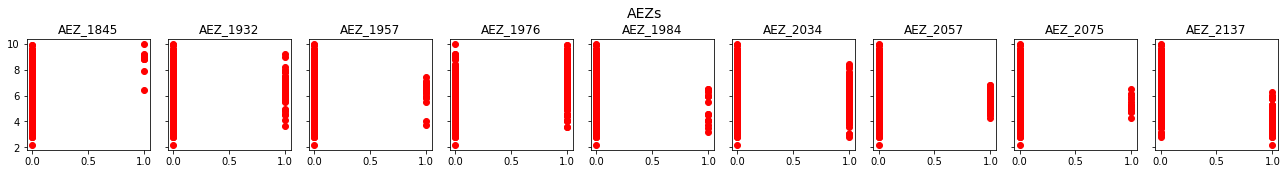

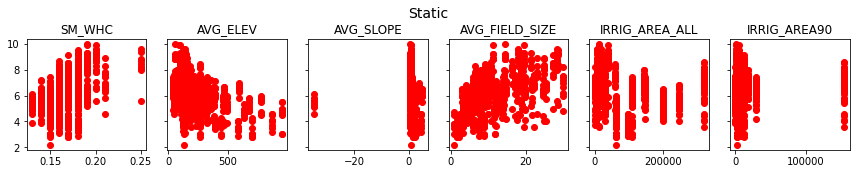

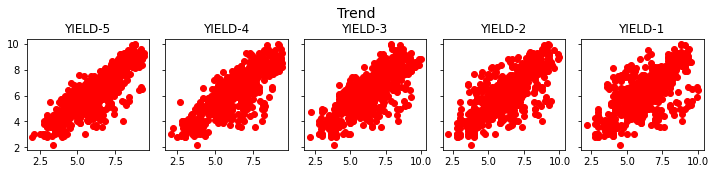

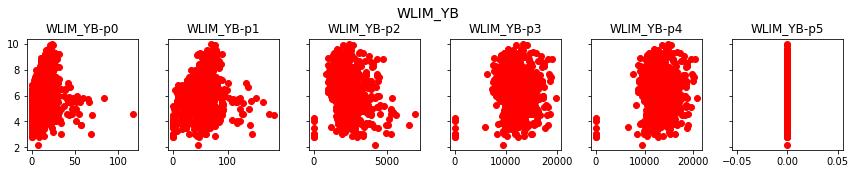

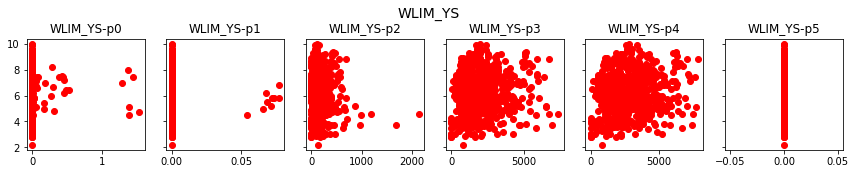

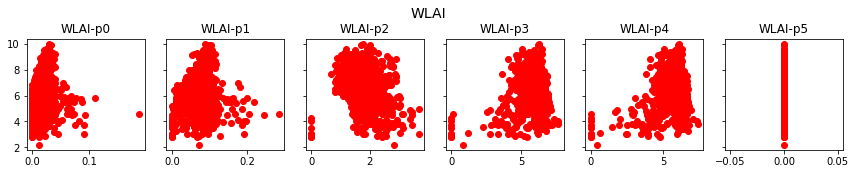

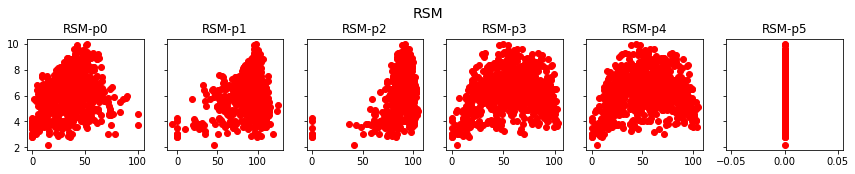

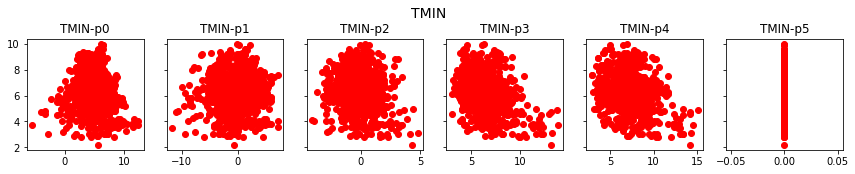

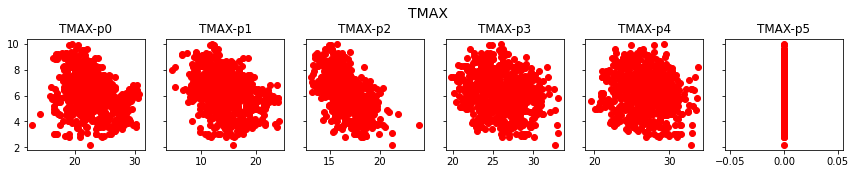

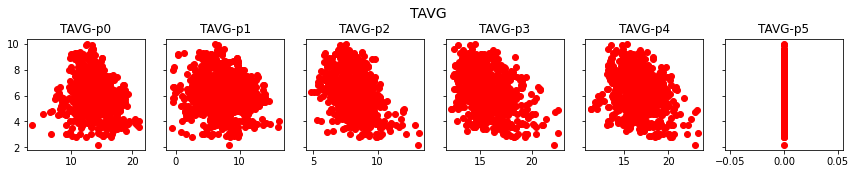

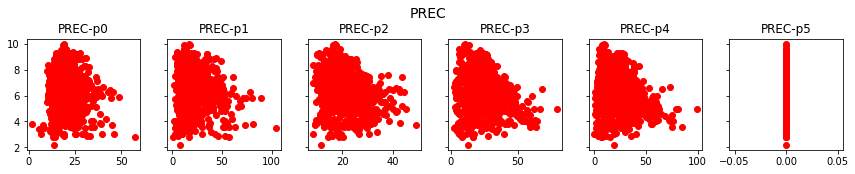

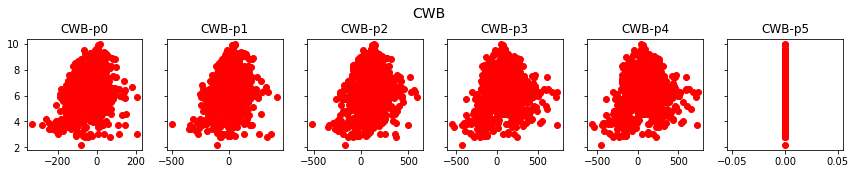

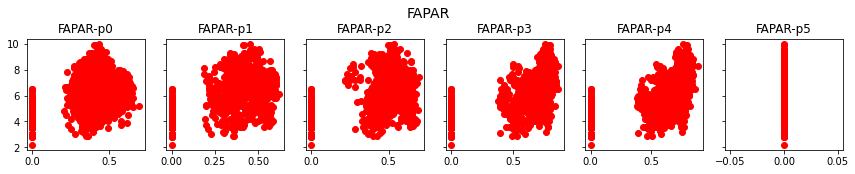

In [ ]:
def scatterPlotFeaturesYields(features, yields, ft_names, figure_title):
  num_plots = len(ft_names)
  x_pos = np.arange(num_plots)
  fig, axs = plt.subplots(1, num_plots, sharex=False, sharey=True, figsize=(num_plots * 2, 2.5))
  for i, ft in enumerate(ft_names):
    axs[i].scatter(features[:, i], yields, color='red')
    axs[i].set_title(ft)

  # fig.suptitle('Bar plots per period')
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])
  fig.suptitle(figure_title, fontsize=14)

architecture = cyp_config['architecture']

early_season_end = cyp_config['early_season_end_dekad']
last_dekad = 36 + early_season_end

crop_calendars = {
    'sof_FR' : { 'p0' : [1, 11], 'p1' : [10, 12], 'p2' : [11, 29], 'p3' : [28, 30], 'p4' : [29, 34], 'p5' : [33, 35] },
    'gra_FR' : { 'p0' : [7, 18], 'p1' : [17, 19], 'p2' : [18, 25], 'p3' : [24, 26], 'p4' : [25, 34], 'p5' : [33, 35] },
}

crop = cyp_config['crop']
cn_code = cyp_config['country_code']

if (cn_code is None):
  crop_cn_code = crop[:3] + '_' + 'COM'
else:
  crop_cn_code = crop[:3] + '_' + cn_code

crop_cal = crop_calendars[crop_cn_code]
print('\n')
print(crop, cn_code)

X_ts_periods = np.zeros((X_ts_all.shape[0], X_ts_all.shape[2] * 6))
if (architecture == '1DCNN'):
  ts_ft_imports_periods = np.zeros((ts_ft_imports.shape[0], ts_ft_imports.shape[1] * 6))
else:
  ts_ft_imports_periods = np.zeros((ts_ft_imports.shape[0], ts_ft_imports.shape[2] * 6))

ts_ft_names = wofost_indicators + meteo_indicators + rs_indicators
crop_cal_periods = list(crop_cal.keys())
ts_periods_dict = {}
ts_period_ft_names = []
for i, ft in enumerate(ts_ft_names):
  for j, p in enumerate(crop_cal_periods):
    p_start, p_end = crop_cal[p]
    period_ft_index = i * len(crop_cal_periods) + j
    ts_period_ft_names.append(ft + '-p' + str(j))
    if (last_dekad < p_start):
      continue

    X_ts_periods[:, period_ft_index] = np.mean(X_ts_all[:, p_start-1:p_end, i], axis=1)
    if (architecture == '1DCNN'):
      ts_ft_imports_periods[:, period_ft_index] = np.mean(ts_ft_imports[:, i, p_start-1:p_end], axis=1)
    else:
      ts_ft_imports_periods[:, period_ft_index] = np.mean(ts_ft_imports[:, p_start-1:p_end, i], axis=1)

# for i, ft in enumerate(static_ft_names):
#   corr = np.corrcoef(X_static_all[:, i], Y_all[:, -1])[0,1]
#   print(ft, corr)

# plot AEZ features
AEZ_ft_idxs = []
AEZ_fts = []
for idx, ft in enumerate(static_ft_names):
  if ('AEZ' in ft):
    AEZ_ft_idxs.append(idx)
    AEZ_fts.append(ft)

scatterPlotFeaturesYields(X_static_all[:, AEZ_ft_idxs], Y_all[:, -1], AEZ_fts, 'AEZs')

# plot other static features
other_static_fts = []
other_static_idxs = []
for idx, ft in enumerate(static_ft_names):
  if (('AEZ' not in ft) and ('STD' not in ft)):
    other_static_idxs.append(idx)
    other_static_fts.append(ft)

scatterPlotFeaturesYields(X_static_all[:, other_static_idxs], Y_all[:, -1], other_static_fts, 'Static')

# for i, ft in enumerate(trend_ft_names):
#   corr = np.corrcoef(X_trend_all[:, i], Y_all[:, -1])[0,1]
#   print(ft, corr)

# plot TREND features
scatterPlotFeaturesYields(X_trend_all, Y_all[:, -1], trend_ft_names, 'Trend')

# for i, ft in enumerate(ts_period_ft_names):
#   corr = np.corrcoef(X_ts_periods[:, i], Y_all[:, -1])[0,1]
#   print(ft, corr)

# plot seasonal features
for ts_ft in ts_ft_names:
  period_fts = []
  period_ft_idxs = []
  for idx, ft in enumerate(ts_period_ft_names):
    if (ts_ft in ft):
      period_ft_idxs.append(idx)
      period_fts.append(ft)

  scatterPlotFeaturesYields(X_ts_periods[:, period_ft_idxs], Y_all[:, -1], period_fts, ts_ft)

# Correlations
# YIELD-1   0.6903
# YIELD-2   0.7443
# YIELD-3   0.7762
# YIELD-4   0.8148
# YIELD-5   0.8353

# Correlations
# AEZ_1845  0.1762        				AEZ_1932  0.0586
# AEZ_1957  0.0109       					AEZ_1976  0.5637
# AEZ_1984  -0.1186        				AEZ_2034  -0.2252
# AEZ_2057  -0.1272        				AEZ_2075  -0.0981
# AEZ_2137  -0.4890

# SM_WHC  0.4596
# AVG_ELEV  -0.4770         			STD_ELEV -0.5930
# AVG_SLOPE -0.0237       				STD_SLOPE -0.0624
# AVG_FIELD_SIZE  0.5187     			STD_FIELD_SIZE 0.4125
# IRRIG_AREA_ALL -0.2037   				IRRIG_AREA90 0.0932

# Correlations
# WLIM_YB-p1 0.1898   # WLIM_YB-p2 -0.1645    # WLIM_YB-p3 0.0697  # WLIM_YB-p4 0.1334
# WLIM_YS-p3 0.0676   # WLIM_YS-p4 0.1301
# WLAI-p1 0.1322      # WLAI-p2 -0.216        # WLAI-p3 0.23628     # WLAI-p4 0.2928
# FAPAR-p1 0.3636     # FAPAR-p2 0.3759       # FAPAR-p3 0.5456     # FAPAR-p4 0.5661

# TMIN-p0 -0.0926     # TMIN-p1 0.0131        # TMIN-p2 -0.1800     # TMIN-p3 -0.3684     # TMIN-p4 -0.3106
# TMAX-p0 -0.2917     # TMAX-p1 -0.3208       # TMAX-p2 -0.5441     # TMAX-p3 -0.2067     # TMAX-p4 -0.1470
# TAVG-p0 -0.2150     # TAVG-p1 -0.1590       # TAVG-p2 -0.4275     # TAVG-p3 -0.3596     # TAVG-p4 -0.2690

# RSM-p1 0.2936       # RSM-p2 0.3672         # RSM-p3 0.2236       # RSM-p4 0.1755
# PREC-p0 -0.0875     # PREC-p1 -0.1085       # PREC-p2 -0.2289     # PREC-p3 -0.1825     # PREC-p4 -0.1697
# CWB-p0 0.2452       # CWB-p1 0.2153         # CWB-p2 0.2022       # CWB-p3 0.1483       # CWB-p4 0.1420

#### Bar plots of attributions per period



soft wheat FR


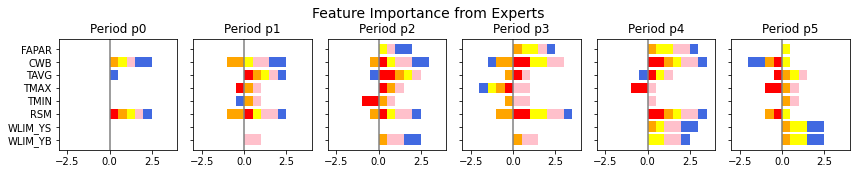

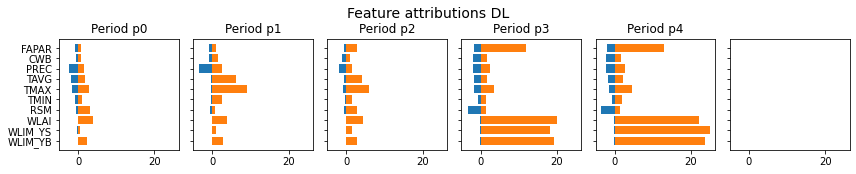

In [ ]:
import seaborn as sns

crop_calendars = {
    'sof_FR' : { 'p0' : [1, 11], 'p1' : [10, 12], 'p2' : [11, 29], 'p3' : [28, 30], 'p4' : [29, 34], 'p5' : [33, 35] },
    'gra_FR' : { 'p0' : [7, 18], 'p1' : [17, 19], 'p2' : [18, 25], 'p3' : [24, 26], 'p4' : [25, 34], 'p5' : [33, 35] },
}

crop = cyp_config['crop']
cn_code = cyp_config['country_code']

if (cn_code is None):
  crop_cn_code = crop[:3] + '_' + 'COM'
else:
  crop_cn_code = crop[:3] + '_' + cn_code

crop_cal = crop_calendars[crop_cn_code]
print('\n')
print(crop, cn_code)

expert_ft_importances = {
    'grain maize' : {
        'expert 1' : [[   0,	  0,	0.5,	   0,	   0,	   0,	 0.5, 	0],
                      [   0,	  0,	0.5,	 0.5,	 0.5,	 0.5,	 0.5,	  0],
                      [   1,	  0,	0.5,	-0.5,	-0.5,	-0.5,	 0.5,	  1],
                      [   1,	  0,	  1,	  -1,	  -1,	  -1,	   1,	  1],
                      [ 0.5,	  1,	0.5,	  -1,	  -1,	  -1,	 0.5,	  1],
                      [ 0.5,	0.5, -0.5,	  -1,	  -1,	  -1,	-0.5,	0.5]],
        'expert 2' : [[    0,   0,	0.5,	   0,	   0,	   0,	   0,	  0],
                      [    0,	  0,	0.5,	  -1,	   0,	   0,	 0.5,	  0],
                      [    1,	  0,	0.5,	-0.5,	-0.5,	 0.5,	 0.5,	0.5],
                      [ 0.5,	  0,	0.5,	  0,	  -1,	   0,	 0.5,	0.5],
                      [   1,	0.5,	  1,	  0,	-0.5,	   0,	   1,	0.5],
                      [   1,	0.5, -0.5,	  0,	 0.5,	   0,	-0.5,	0.5]],
        'expert 3' : [[   0,	  0,	0.5,	  0,	   0,	   0,	 0.5,	  0],
                      [ 0.5,	  0,	0.5,	0.5,	 0.5,	 0.5,	 0.5,	  0],
                      [   1,	  0,	  1,	0.5,	 0.5,	 0.5,	   1,	  1],
                      [ 0.5,	  0,	  1,	  1,	   1,	 0.5,	   1,	0.5],
                      [   1,	  1,	  1,	0.5,	 0.5,	 0.5,	   1,	  1],
                      [   0,	  0,	  0,  0.5,	 0.5,	 0.5,	 0.5,	  0]],      
        'expert 4' : [[   0,	  0,	0.5,	  0,	   0,	 0.5,	 0.5,	  0],
                      [   0,	  0,	0.5,	  0,	   0,	 0.5,	   0,	  0],
                      [   0,	  0,	0.5,	  0,	   0,	 0.5,	 0.5,	0.5],
                      [   0,	  0,	0.5,	0.5,	  -1,	   0,	 0.5,	  1],
                      [   1,	0.5,	0.5,	  0,	   0,	-0.5,	 0.5,	  1],
                      [   1,	  1, -0.5,	  0,	   0,	 0.5,	-0.5,	0.5]],
        'expert 5' : [[   0,	  0,	0.5,	  0,	   0,	 0.5,	   1,	  0],
                      [   0,	  0,	0.5, -0.5,	   0,	   0,	 0.5,	  0],
                      [   1,	  0,	0.5,	  0,	   0,	-0.5,	   1,	  1],
                      [   0,	  0,	0.5,	  0,	-0.5,	   0,	-0.5,	  0],
                      [   1,	  1,	0.5,	  0,	   0,	-0.5,	   1,	0.5],
                      [   1,	  1,	0.5,	  0,	   0,	   0,	-0.5,	  0]]
    },
    'soft wheat' : {
        'expert 1' : [[   0,	  0,	0.5,	  0,	   0,	   0,	   0,	  0],
                      [   0,	  0,	0.5,	  0,	-0.5,	 0.5,	   0,	  0],
                      [   0,	  0,	0.5,	 -1,	 0.5,	   1,	 0.5,	  0],
                      [   0,	  0,	  1,	  0,	-0.5,	 0.5,	   1,	  0],
                      [   0,	  0,	  1,	  0,	  -1,	 0.5,	   1,	  0],
                      [   0,	  0, -0.5,	  0,	  -1,	-0.5,	-0.5,	  0]],
        'expert 2' : [[   0,	  0,	0.5,	  0,	   0,	   0,	 0.5,	  0],
                      [   0,	  0,	 -1,	0.5,	 0.5,	 0.5,	  -1,	  0],
                      [ 0.5,	  0, -0.5,	0.5,	 0.5,	 0.5,	-0.5,	  0],
                      [ 0.5,	  0,	 -1, -0.5,  -0.5,	-0.5,	  -1,	0.5],
                      [   0,	0.5,	0.5,	  0, 	   0, 	 0,	 0.5,	0.5],
                      [ 0.5,	0.5, -0.5,	0.5,	 0.5,	 0.5,	-0.5,	  0]],
        'expert 3' : [[   0,	  0,	0.5,	  0,	   0,	   0,	 0.5,	  0],
                      [   0,	  0,	0.5,	  0,	   0,	 0.5,	 0.5,	  0],
                      [   0,	  0,	0.5,	  0,	   0,	 0.5,	 0.5,	0.5],
                      [   0,	  0,	  1,	  0,	-0.5,	   0,	   1,	  1],
                      [   1,	0.5,	0.5,	  0,	   0,	 0.5,	 0.5,	  1],
                      [   1,	  1,	0.5,	  0,	   0,	 0.5,	 0.5,	0.5]],
        'expert 4' : [[   0,	  0,	0.5,	  0,	   0,	   0,	 0.5,	  0],
                      [   1,	  0,	  1,	0.5,	 0.5,	 0.5,	   1,	  0],
                      [   1,	  0,	  1,	0.5,	 0.5,	 0.5,	   1,	0.5],
                      [   1,	  0,	  1,	  1, 	   1,	 0.5,	   1,	0.5],
                      [   1,	  1,	  1,	0.5,	 0.5,	 0.5,	   1,	  1],
                      [   0,	  0,	  0,	0.5,	 0.5,	 0.5,	   0,	  0]],
        'expert 5' : [[   0,	  0,	0.5,	  0,	   0,	 0.5,	   1,	  0],
                      [   0,	  0,	0.5, -0.5,	   0,	 0.5,	   1,	  0],
                      [   1,	  0,	0.5,	  0,	   0,	-0.5,	   1,	  1],
                      [   0,	  0,	0.5,	  0,	-0.5,	   0,	-0.5,	0.5],
                      [ 0.5,	  1,	0.5,	  0,	   0,	-0.5,	 0.5,	0.5],
                      [   1,	  1,	  0,	  0,	   0,	   0,	  -1,	  0]]
    }
}


colors = ['red', 'orange', 'yellow', 'pink', 'royalblue']
x_labels = ['WLIM_YB', 'WLIM_YS', 'RSM', 'TMIN', 'TMAX', 'TAVG', 'CWB', 'FAPAR']
expert_ids = ['expert 1', 'expert 2', 'expert 3', 'expert 4', 'expert 5']

sel_expert_ft_imports = expert_ft_importances[crop]
plotExpertFeatureImportances(x_labels, sel_expert_ft_imports, expert_ids,
                             colors)

attr_methods = ['Occlusion', 'IntegratedGradients', 'GradientShap']
ts_ft_names = wofost_indicators + meteo_indicators + rs_indicators
figure_title = 'Feature attributions DL'
figure_file = 'barplots_periods'
barPlotsPerPeriod(ft_imports, ts_ft_names, attr_methods,
                  crop_cal, early_season_end,
                  architecture, figure_title, figure_file)

#### Beeswarm plots

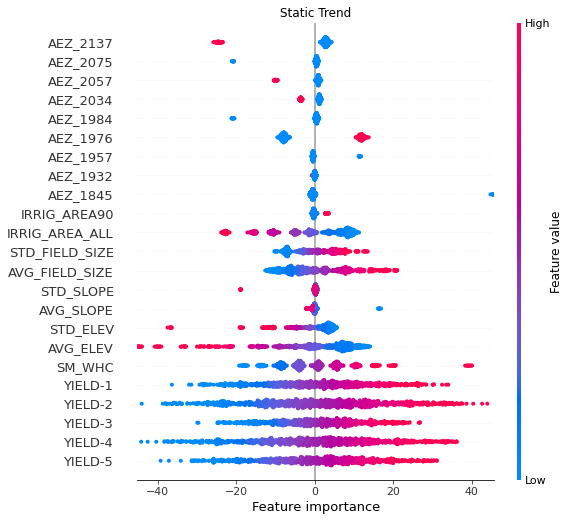

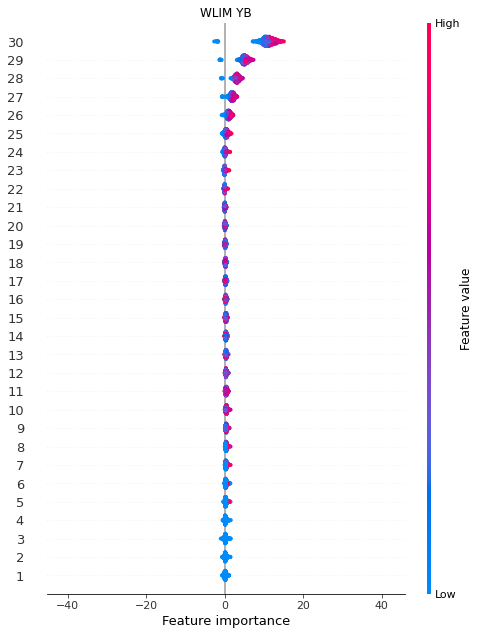

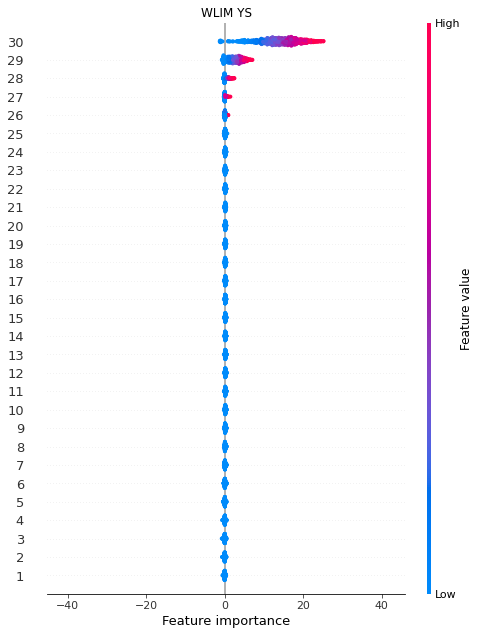

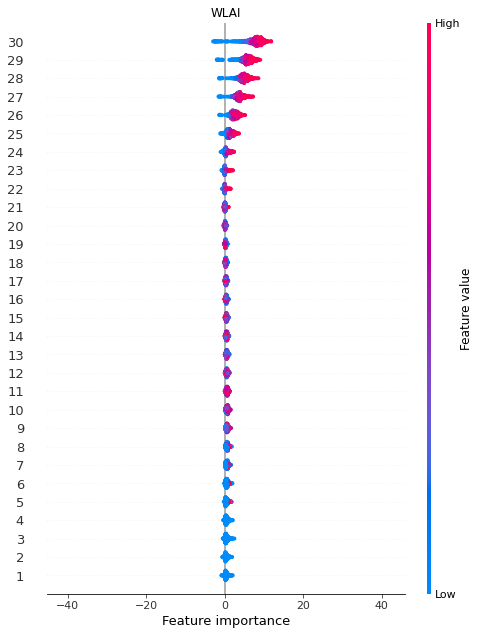

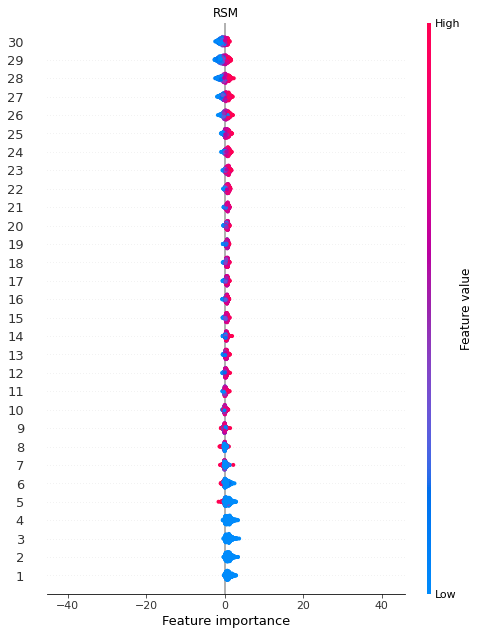

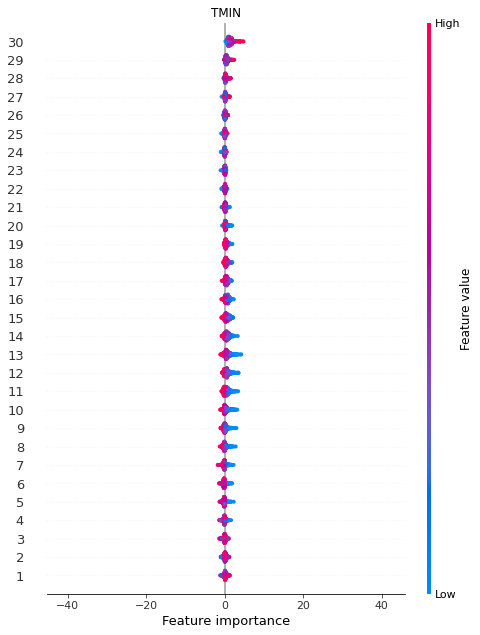

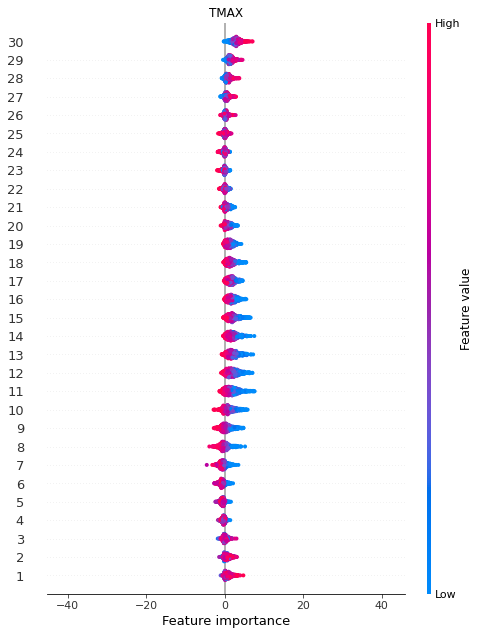

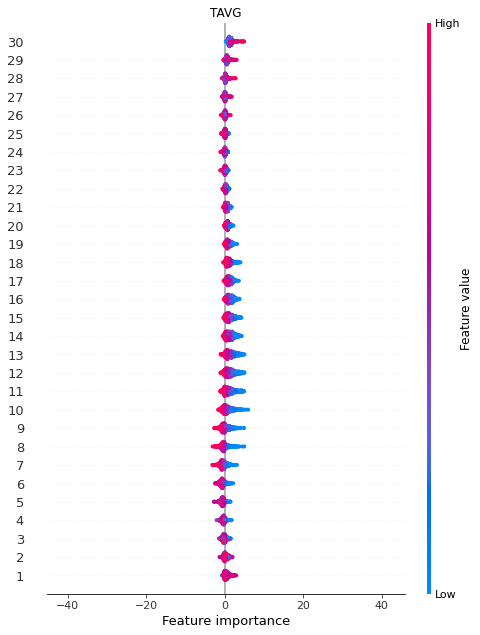

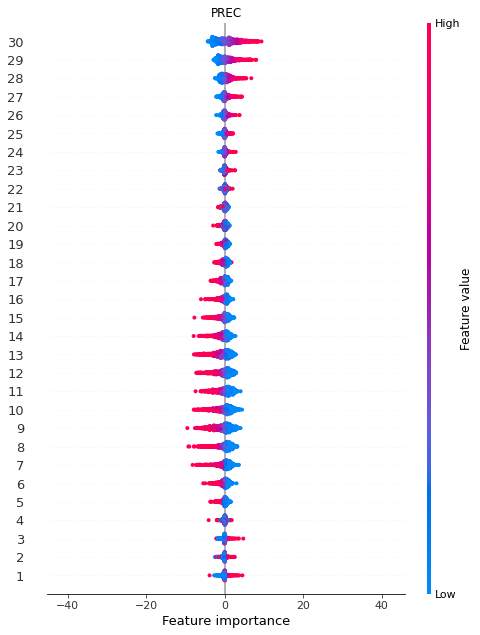

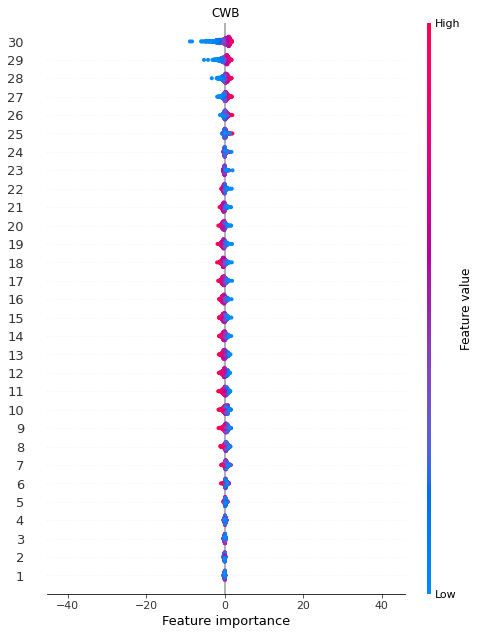

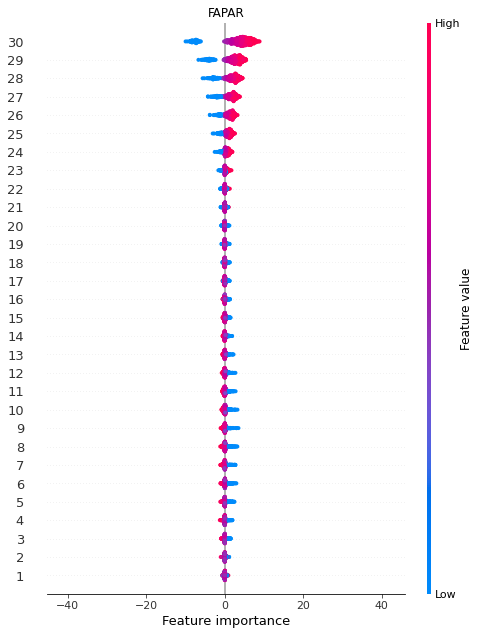

In [ ]:
ts_ft_imports = ft_imports['GradientShap']['ts']
static_ft_imports = ft_imports['GradientShap']['static']
trend_ft_imports = ft_imports['GradientShap']['trend']

trend_static_attrs = np.append(trend_ft_imports, static_ft_imports, axis=1)
ts_import_min, ts_import_max = np.min(ts_ft_imports), np.max(ts_ft_imports)
trend_static_import_min, trend_static_import_max = np.min(trend_static_attrs), np.max(trend_static_attrs)

xlabel = "Feature importance"
axis_color="#333333"

ftval_color = red_blue
xmin = min(ts_import_min, trend_static_import_min)
xmax = max(ts_import_max, trend_static_import_max)
trend_static_cols = trend_ft_names + static_ft_names
trend_static_vals = np.append(X_trend_all, X_static_all, axis=1)
beeswarmPlot(trend_static_attrs, trend_static_vals, trend_static_cols,
             xlabel, ftval_color, axis_color,
             xmin, xmax, 'Static_Trend')

if (cyp_config['architecture'] == '1DCNN'):
  dekad_nums = [(i+1) for i in range(ts_ft_imports.shape[2])]
else:
  dekad_nums = [(i+1) for i in range(ts_ft_imports.shape[1])]

for i, ft in enumerate(ts_ft_names):
  ft_vals = X_ts_all[:, :, i]
  if (cyp_config['architecture'] == '1DCNN'):
    ft_attr = ts_ft_imports[:, i, :]
  else:
    ft_attr = ts_ft_imports[:, :, i]

  beeswarmPlot(ft_attr, ft_vals, dekad_nums,
               xlabel, ftval_color, axis_color,
               xmin, xmax, ft)

#### Beeswarm plots per period



soft wheat FR


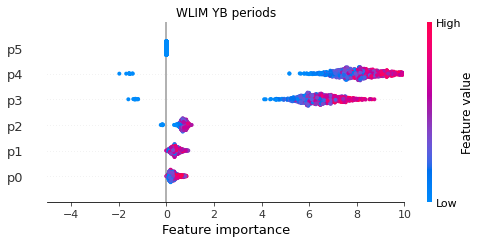

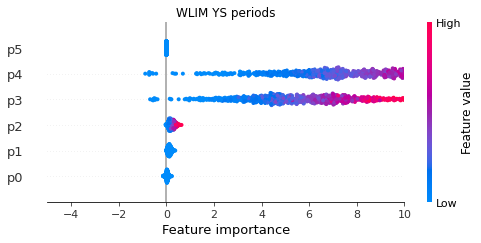

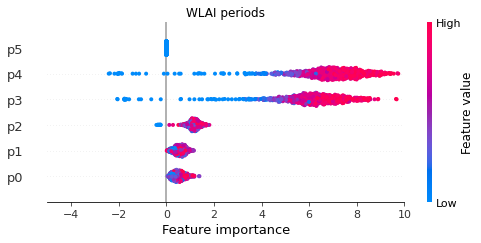

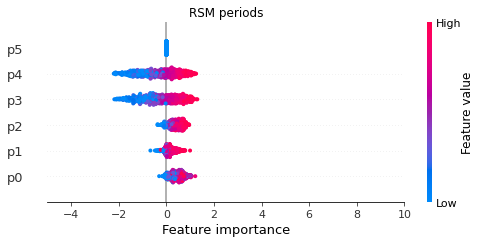

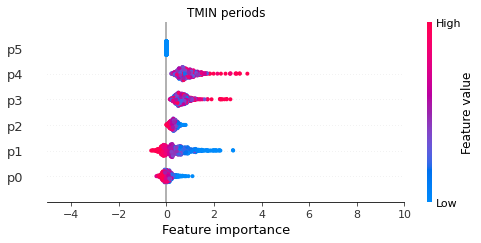

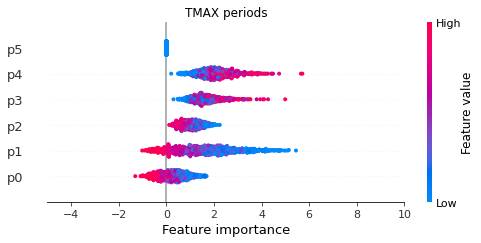

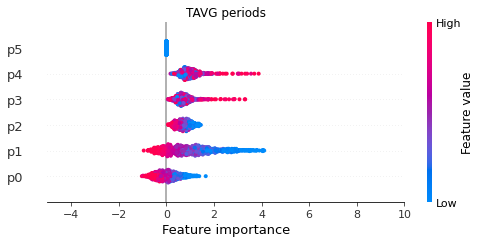

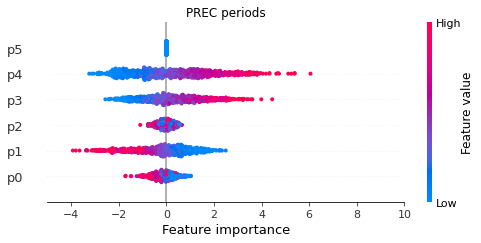

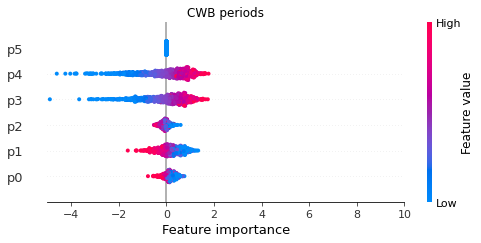

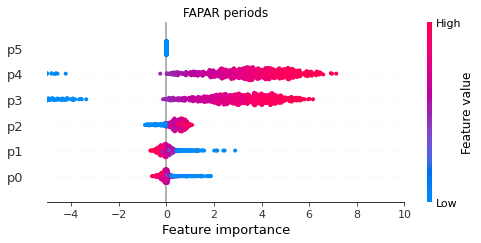

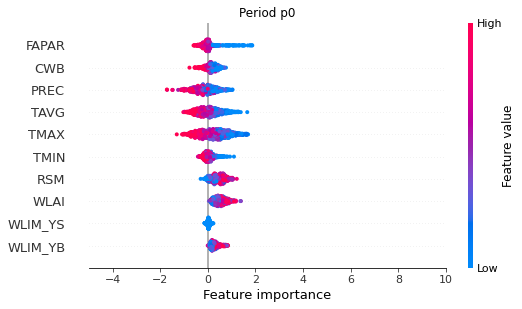

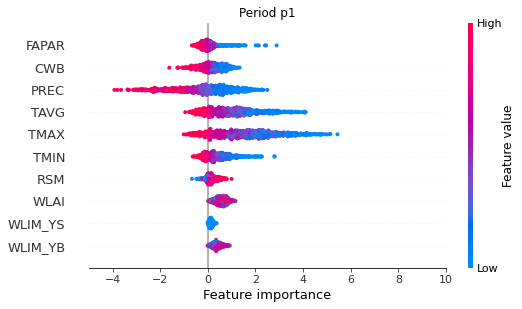

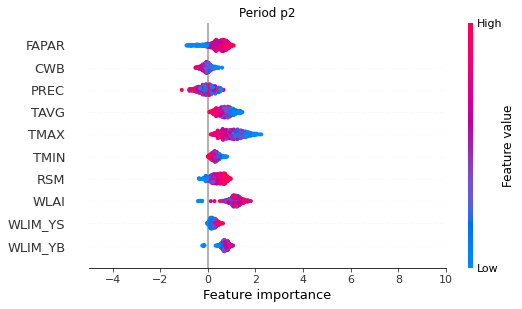

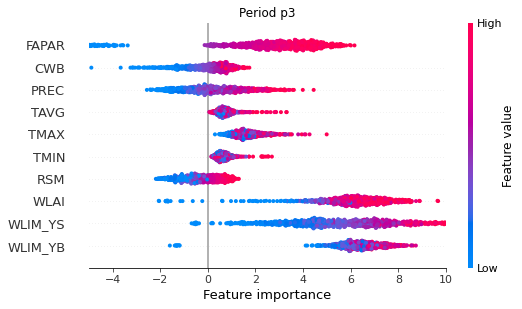

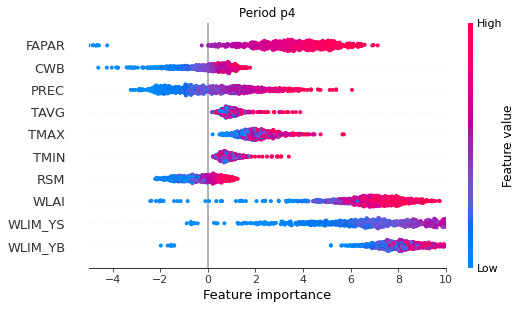

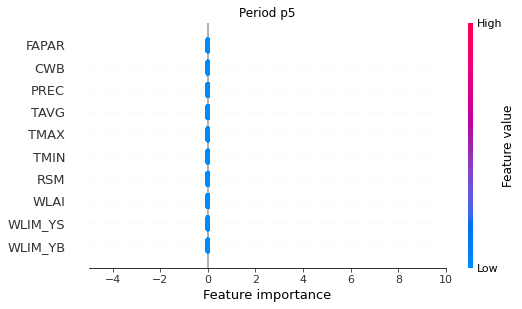

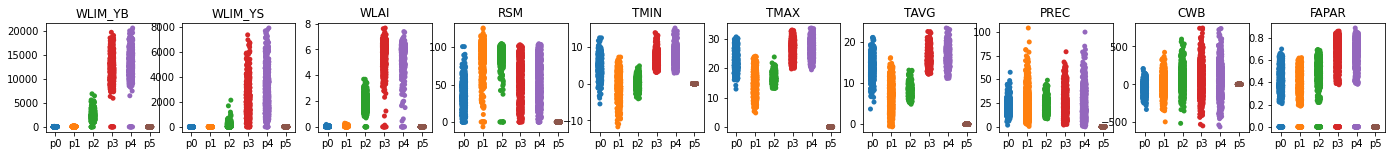

In [ ]:
def beeswarmPlotsPerPeriod(ts_ft_imports, static_ft_imports, trend_ft_imports,
                           X_ts_all, X_static_all, X_trend_all,
                           ts_ft_names, crop_cal, early_season_end,
                           xmin, xmax,
                           architecture):

  last_dekad = 36 + early_season_end
  X_ts_periods = np.zeros((ts_ft_imports.shape[0], 6, ts_ft_imports.shape[2]))
  if (architecture == '1DCNN'):
    ts_ft_imports_periods = np.zeros((ts_ft_imports.shape[0], ts_ft_imports.shape[1], 6))
  else:
    ts_ft_imports_periods = np.zeros((ts_ft_imports.shape[0], 6, ts_ft_imports.shape[2]))

  ts_period_stats = np.zeros((6, len(ts_ft_names)))
  for i, p in enumerate(list(crop_cal.keys())):
    p_start, p_end = crop_cal[p]
    if (last_dekad < p_start):
      continue

    for j, ft in enumerate(ts_ft_names):
      ts_period_stats[i, j] = np.mean(X_ts_all[:, p_start-1:p_end, j])
      X_ts_periods[:, i, j] = np.mean(X_ts_all[:, p_start-1:p_end, j], axis=1)
      if (architecture == '1DCNN'):
        ts_ft_imports_periods[:, j, i] = np.mean(ts_ft_imports[:, j, p_start-1:p_end], axis=1)
      else:
        ts_ft_imports_periods[:, i, j] = np.mean(ts_ft_imports[:, p_start-1:p_end, j], axis=1)

  pd_ts_period_stats = pd.DataFrame(ts_period_stats, columns=ts_ft_names)

  xlabel = "Feature importance"
  axis_color="#333333"

  ftval_color = red_blue
  period_nums = [ ('p' + str(i)) for i in range(6)]
  # by indicator
  for i, ft in enumerate(ts_ft_names):
    ft_vals = X_ts_periods[:, :, i]
    if (cyp_config['architecture'] == '1DCNN'):
      ft_attr = ts_ft_imports_periods[:, i, :]
    else:
      ft_attr = ts_ft_imports_periods[:, :, i]

    beeswarmPlot(ft_attr, ft_vals, period_nums,
                xlabel, ftval_color, axis_color,
                xmin, xmax, ft + ' periods')

  # by period
  for i in range(6):
    ft_vals = X_ts_periods[:, i, :]
    if (cyp_config['architecture'] == '1DCNN'):
      ft_attr = ts_ft_imports_periods[:, :, i]
    else:
      ft_attr = ts_ft_imports_periods[:, i, :]

    beeswarmPlot(ft_attr, ft_vals, ts_ft_names,
                xlabel, ftval_color, axis_color,
                xmin, xmax, 'Period p' + str(i))

  fig, axs = plt.subplots(1, len(ts_ft_names), figsize=(24, 2))
  for i, ft in enumerate(ts_ft_names):
    ft_vals = X_ts_periods[:, :, i]
    pd_ft_vals = pd.DataFrame(ft_vals, columns=['p' + str(i) for i in range(6)])
    sns.stripplot(data=pd_ft_vals, ax=axs[i])
    axs[i].set_title(ft)

  fig.savefig("seasonal_ft_values.jpg", dpi=300, bbox_inches='tight')

crop_calendars = {
    'sof_FR' : { 'p0' : [1, 11], 'p1' : [10, 12], 'p2' : [11, 29], 'p3' : [28, 30], 'p4' : [29, 34], 'p5' : [33, 35] },
    'gra_FR' : { 'p0' : [7, 18], 'p1' : [17, 19], 'p2' : [18, 25], 'p3' : [24, 26], 'p4' : [25, 34], 'p5' : [33, 35] },
}

crop_cal = crop_calendars[crop_cn_code]
print('\n')
print(crop, cn_code)

trend_static_attrs = np.append(trend_ft_imports, static_ft_imports, axis=1)
ts_import_min, ts_import_max = np.min(ts_ft_imports), np.max(ts_ft_imports)
trend_static_import_min, trend_static_import_max = np.min(trend_static_attrs), np.max(trend_static_attrs)
# xmin = min(ts_import_min, trend_static_import_min)
# xmax = max(ts_import_max, trend_static_import_max)
xmin = -5
xmax = 10

beeswarmPlotsPerPeriod(ts_ft_imports, static_ft_imports, trend_ft_imports,
                       X_ts_all, X_static_all, X_trend_all,
                       ts_ft_names, crop_cal, early_season_end,
                       xmin, xmax,
                       architecture)

#### Plot importance per region

In [ ]:
map_limits = {
      'xmin' : -5, 'xmax' : 10,
      'ymin' : 40, 'ymax' : 52,
}

id_df = combined_dfs['NUMERIC_IDS']
pd_yield_df = pd.DataFrame(Y_all, columns=['id0', 'id3', 'FYEAR', 'YIELD'])
pd_yield_df = pd_yield_df.merge(id_df, on=['id0', 'id3']).drop(columns=['id0', 'id3'])
pd_yield_df = pd_yield_df.rename(columns={'IDREGION' : 'NUTS_ID'})
unique_years = pd_yield_df['FYEAR'].unique()
if (len(unique_years) > 1):
  pd_yield_df = pd_yield_df.groupby(['NUTS_ID']).agg(YIELD=('YIELD', 'mean')).reset_index()
  pd_yield_df['COUNTRY'] = pd_yield_df['NUTS_ID'].str[:2]

vmin = pd_yield_df['YIELD'].min()
vmax = pd_yield_df['YIELD'].max()
title_label = 'Average Yield'
plotStaticMaps('FR', 'NUTS3', map_limits, pd_yield_df, ['YIELD'], red_blue,
               vmin, vmax, title_label)

region_num_ids = np.unique(Y_all[:, 1])
last_dekad = 36 + early_season_end

num_ts_features = len(ts_ft_names)
# reg_id, feature attribution for each indicator and period
regional_ft_imports = np.zeros((len(region_num_ids), 1 + 6 * num_ts_features))
# similar to above for values
regional_ft_values = np.zeros((len(region_num_ids), 1 + 6 * num_ts_features))
for i, reg_id in enumerate(region_num_ids):
  reg_idxs = np.nonzero(Y_all[:, 1] == reg_id)[0]
  for j, p in enumerate(list(crop_cal.keys())):
    p_start, p_end = crop_cal[p]
    if (last_dekad < p_start):
      continue

    if (architecture == '1DCNN'):
      sel_ft_import = np.mean(ts_ft_imports[reg_idxs, :, p_start-1:p_end], axis=2)
    else:
      sel_ft_import = np.mean(ts_ft_imports[reg_idxs, p_start-1:p_end, :], axis=1)

    sel_ft_value = np.mean(X_ts_all[reg_idxs, p_start-1:p_end, :], axis=1)
    # average over years
    mean_ft_import = np.mean(sel_ft_import, axis=0)
    mean_ft_value = np.mean(sel_ft_value, axis=0)
    col_indices = [ i for i in range(j * num_ts_features, (j + 1)* num_ts_features)]
    regional_ft_imports[i,  col_indices] = mean_ft_import
    regional_ft_values[i, col_indices] = mean_ft_value

  regional_ft_imports[i, -1] = reg_id
  regional_ft_values[i, -1] = reg_id

summary_cols = []
for i in range(6):
  summary_cols += [ ('p' + str(i) + '-' + ft) for ft in ts_ft_names]

pd_regional_ft_imports = pd.DataFrame(regional_ft_imports, columns=summary_cols + ['id3'])
pd_regional_ft_values = pd.DataFrame(regional_ft_values, columns=summary_cols + ['id3'])
pd_regional_ft_imports = pd_regional_ft_imports.merge(id_df, on=['id3']).drop(columns=['id0', 'id3'])
pd_regional_ft_values = pd_regional_ft_values.merge(id_df, on=['id3']).drop(columns=['id0', 'id3'])

pd_regional_ft_imports = pd_regional_ft_imports.rename(columns={'IDREGION' : 'NUTS_ID'})
pd_regional_ft_values = pd_regional_ft_values.rename(columns={'IDREGION' : 'NUTS_ID'})

for i, ft in enumerate(ts_ft_names):
  title_label = 'Feature importance : ' + ft
  show_cols = [ ('p' + str(i) + '-' + ft) for i in range(6)]
  vmin = pd_regional_ft_imports[show_cols].min()
  vmax = pd_regional_ft_imports[show_cols].max()
  plotStaticMaps('FR', 'NUTS3', map_limits, pd_regional_ft_imports, show_cols,
                 red_blue, vmin.min(), vmax.max(), title_label)
  vmin = pd_regional_ft_values[show_cols].min()
  vmax = pd_regional_ft_values[show_cols].max()
  title_label = 'Feature values : ' + ft
  plotStaticMaps('FR', 'NUTS3', map_limits, pd_regional_ft_values, show_cols,
                 red_blue, vmin.min(), vmax.max(), title_label)

#### Barplots for selected regions

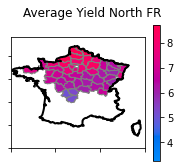

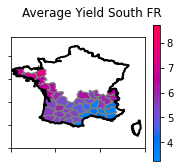

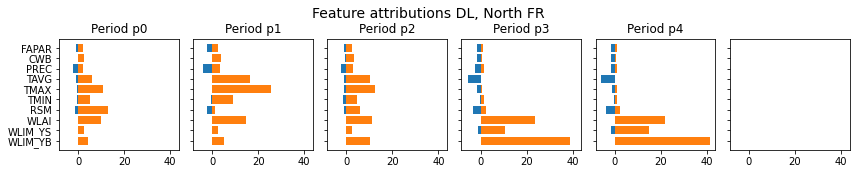

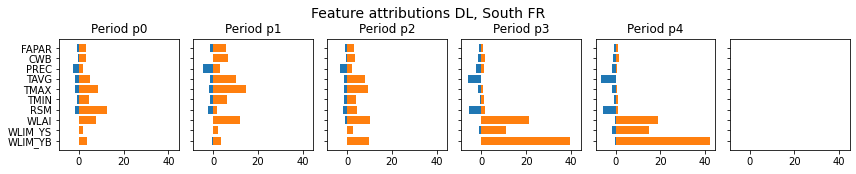

In [ ]:
country = cyp_config['country_code']

SW_FR_max_area_regions = ['FRB0', 'FRE2', 'FRF2', 'FRI3', 'FRG0', 'FRC1', 'FRE1', 'FRH0']
SW_FR_max_yield_regions = ['FRD1', 'FRD2', 'FRE1', 'FRE2', 'FRF1', 'FRF2', 'FR10', 'FRH0']

sel_regions1 = ['FR102', 'FR103', 'FR104', 'FR105', 'FR106', 'FR107', 'FR108', 'FRB01', 'FRB02',
                'FRB03', 'FRB04', 'FRB05', 'FRB06', 'FRC11', 'FRC12', 'FRC13', 'FRC14', 'FRC21',
                'FRC22', 'FRC23', 'FRC24', 'FRD11', 'FRD12', 'FRD13', 'FRD21', 'FRD22', 'FRE11',
                'FRE12', 'FRE21', 'FRE22', 'FRE23', 'FRF11', 'FRF12', 'FRF21', 'FRF22', 'FRF23',
                'FRF24', 'FRF31', 'FRF32', 'FRF33', 'FRF34', 'FRG02', 'FRG03', 'FRG04', 'FRH01',
                'FRI21', 'FRI22', 'FRI23', 'FRI34', 'FRK11', 'FRK21']

sel_regions2 = ['FRG01', 'FRG05', 'FRH02', 'FRH03', 'FRH04', 'FRI11', 'FRI12', 'FRI13', 'FRI14',
                'FRI15', 'FRI31', 'FRI32', 'FRI33', 'FRJ11', 'FRJ12', 'FRJ13', 'FRJ14', 'FRJ15',
                'FRJ21', 'FRJ22', 'FRJ23', 'FRJ24', 'FRJ25', 'FRJ26', 'FRJ27', 'FRJ28', 'FRK12',
                'FRK13', 'FRK14', 'FRK22', 'FRK23', 'FRK24', 'FRK25', 'FRK26', 'FRK27', 'FRK28',
                'FRL01', 'FRL02', 'FRL03', 'FRL04', 'FRL05', 'FRL06', 'FRM01', 'FRM02']

map_limits = {
      'xmin' : -5, 'xmax' : 10,
      'ymin' : 40, 'ymax' : 52,
}

id_df = combined_dfs['NUMERIC_IDS']
pd_yield_df = pd.DataFrame(Y_all, columns=['id0', 'id3', 'FYEAR', 'YIELD'])
pd_yield_df = pd_yield_df.merge(id_df, on=['id0', 'id3']).drop(columns=['id0', 'id3'])
pd_yield_df = pd_yield_df.rename(columns={'IDREGION' : 'NUTS_ID'})
unique_years = pd_yield_df['FYEAR'].unique()
if (len(unique_years) > 1):
  pd_yield_df = pd_yield_df.groupby(['NUTS_ID']).agg(YIELD=('YIELD', 'mean')).reset_index()
  pd_yield_df['COUNTRY'] = pd_yield_df['NUTS_ID'].str[:2]

vmin = pd_yield_df['YIELD'].min()
vmax = pd_yield_df['YIELD'].max()
title_label = 'Average Yield North FR'
pd_yield_df1 = pd_yield_df[pd_yield_df['NUTS_ID'].isin(sel_regions1)]
plotStaticMaps('FR', 'NUTS3', map_limits, pd_yield_df1, ['YIELD'], red_blue,
               vmin, vmax, title_label)

title_label = 'Average Yield South FR'
pd_yield_df2 = pd_yield_df[pd_yield_df['NUTS_ID'].isin(sel_regions2)]
plotStaticMaps('FR', 'NUTS3', map_limits, pd_yield_df2, ['YIELD'], red_blue,
               vmin, vmax, title_label)

# North FR
sel_region_ids = id_df[id_df['IDREGION'].isin(sel_regions1)]['id3'].unique()
sel_idxs = np.isin(Y_all[:, 1], sel_region_ids)

sel_ft_imports = {}
for attr_method in ft_imports:
  ts_sel_imports = ft_imports[attr_method]['ts'][sel_idxs, :, :]
  static_sel_imports = ft_imports[attr_method]['static'][sel_idxs, :]
  trend_sel_imports = ft_imports[attr_method]['trend'][sel_idxs, :]
  sel_ft_imports[attr_method] = {
      'ts' : ts_sel_imports,
      'static' : static_sel_imports,
      'trend' : trend_sel_imports
  }

figure_title = 'Feature attributions DL, North FR'
figure_file = 'barplot_periods_north'
barPlotsPerPeriod(sel_ft_imports, ts_ft_names, attr_methods,
                  crop_cal, early_season_end,
                  architecture, figure_title, figure_file)

# South FR
sel_region_ids = id_df[id_df['IDREGION'].isin(sel_regions2)]['id3'].unique()
sel_idxs = np.isin(Y_all[:, 1], sel_region_ids)

sel_ft_imports = {}
for attr_method in ft_imports:
  ts_sel_imports = ft_imports[attr_method]['ts'][sel_idxs, :, :]
  static_sel_imports = ft_imports[attr_method]['static'][sel_idxs, :]
  trend_sel_imports = ft_imports[attr_method]['trend'][sel_idxs, :]
  sel_ft_imports[attr_method] = {
      'ts' : ts_sel_imports,
      'static' : static_sel_imports,
      'trend' : trend_sel_imports
  }

figure_title = 'Feature attributions DL, South FR'
figure_file = 'barplot_periods_south'
barPlotsPerPeriod(sel_ft_imports, ts_ft_names, attr_methods,
                  crop_cal, early_season_end,
                  architecture, figure_title, figure_file)

#### Barplots for irrigated vs non-irrigated regions



soft wheat FR


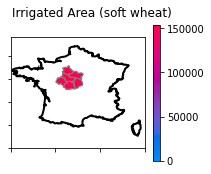

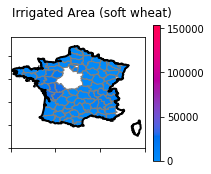

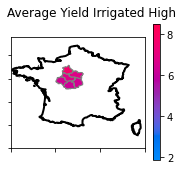

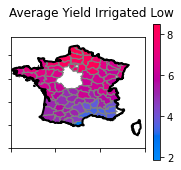

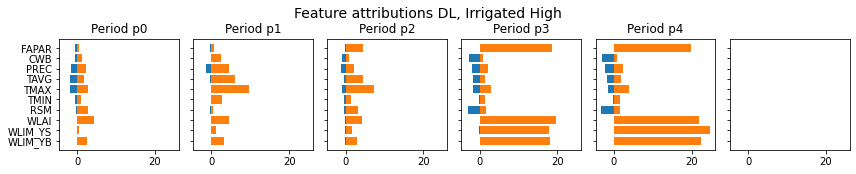

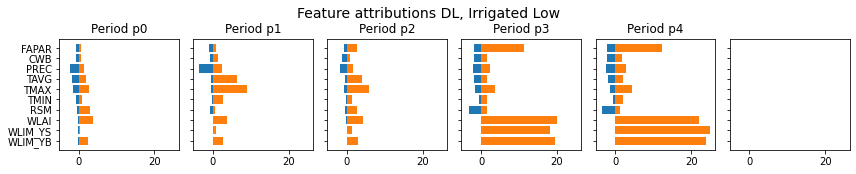

In [ ]:
country = cyp_config['country_code']

id_df = combined_dfs['NUMERIC_IDS']
pd_static_df = combined_dfs['STATIC']

map_limits = {
      'xmin' : -5, 'xmax' : 10,
      'ymin' : 40, 'ymax' : 52,
}

crop_calendars = {
    'sof_FR' : { 'p0' : [1, 11], 'p1' : [10, 12], 'p2' : [11, 29], 'p3' : [28, 30], 'p4' : [29, 34], 'p5' : [33, 35] },
    'gra_FR' : { 'p0' : [7, 18], 'p1' : [17, 19], 'p2' : [18, 25], 'p3' : [24, 26], 'p4' : [25, 34], 'p5' : [33, 35] },
}

crop = cyp_config['crop']
cn_code = cyp_config['country_code']

if (cn_code is None):
  crop_cn_code = crop[:3] + '_' + 'COM'
else:
  crop_cn_code = crop[:3] + '_' + cn_code

crop_cal = crop_calendars[crop_cn_code]
print('\n')
print(crop, cn_code)

attr_methods = ['Occlusion', 'IntegratedGradients', 'GradientShap']
ts_ft_names = wofost_indicators + meteo_indicators + rs_indicators

pd_static_df = pd_static_df.merge(id_df, on=['id0', 'id3']).drop(columns=['id0', 'id3'])
pd_static_df = pd_static_df.rename(columns={'IDREGION' : 'NUTS_ID'})

pd_static_df1 = pd_static_df[pd_static_df['IRRIG_AREA' + str(crop_id)] > 50000]
pd_static_df2 = pd_static_df[pd_static_df['IRRIG_AREA' + str(crop_id)] < 50000]

vmin = pd_static_df['IRRIG_AREA' + str(crop_id)].min()
vmax = pd_static_df['IRRIG_AREA' + str(crop_id)].max()
title_label = 'Irrigated Area (' + crop + ')'
plotStaticMaps('FR', 'NUTS3', map_limits, pd_static_df1, ['IRRIG_AREA' + str(crop_id)], red_blue,
               vmin, vmax, title_label)

title_label = 'Irrigated Area (' + crop + ')'
plotStaticMaps('FR', 'NUTS3', map_limits, pd_static_df2, ['IRRIG_AREA' + str(crop_id)], red_blue,
               vmin, vmax, title_label)

sel_regions1 = pd_static_df1['NUTS_ID'].unique()
sel_regions2 = pd_static_df2['NUTS_ID'].unique()

pd_yield_df = combined_dfs['YIELD']
pd_yield_df = pd_yield_df.merge(id_df, on=['id0', 'id3']).drop(columns=['id0', 'id3'])
pd_yield_df = pd_yield_df.rename(columns={'IDREGION' : 'NUTS_ID'})
unique_years = pd_yield_df['FYEAR'].unique()
if (len(unique_years) > 1):
  pd_yield_df = pd_yield_df.groupby(['NUTS_ID']).agg(YIELD=('YIELD', 'mean')).reset_index()
  pd_yield_df['COUNTRY'] = pd_yield_df['NUTS_ID'].str[:2]

vmin = pd_yield_df['YIELD'].min()
vmax = pd_yield_df['YIELD'].max()
title_label = 'Average Yield Irrigated High'
pd_yield_df1 = pd_yield_df[pd_yield_df['NUTS_ID'].isin(sel_regions1)]
plotStaticMaps('FR', 'NUTS3', map_limits, pd_yield_df1, ['YIELD'], red_blue,
               vmin, vmax, title_label)

title_label = 'Average Yield Irrigated Low'
pd_yield_df2 = pd_yield_df[pd_yield_df['NUTS_ID'].isin(sel_regions2)]
plotStaticMaps('FR', 'NUTS3', map_limits, pd_yield_df2, ['YIELD'], red_blue,
               vmin, vmax, title_label)

# High irrigated area
sel_region_ids = id_df[id_df['IDREGION'].isin(sel_regions1)]['id3'].unique()
sel_idxs = np.isin(Y_all[:, 1], sel_region_ids)

sel_ft_imports = {}
for attr_method in ft_imports:
  ts_sel_imports = ft_imports[attr_method]['ts'][sel_idxs, :, :]
  static_sel_imports = ft_imports[attr_method]['static'][sel_idxs, :]
  trend_sel_imports = ft_imports[attr_method]['trend'][sel_idxs, :]
  sel_ft_imports[attr_method] = {
      'ts' : ts_sel_imports,
      'static' : static_sel_imports,
      'trend' : trend_sel_imports
  }

figure_title = 'Feature attributions DL, Irrigated High'
figure_file = 'barplot_periods_high_irrig'
barPlotsPerPeriod(sel_ft_imports, ts_ft_names, attr_methods,
                  crop_cal, early_season_end,
                  architecture, figure_title, figure_file)

# Low irrigated area
sel_region_ids = id_df[id_df['IDREGION'].isin(sel_regions2)]['id3'].unique()
sel_idxs = np.isin(Y_all[:, 1], sel_region_ids)

sel_ft_imports = {}
for attr_method in ft_imports:
  ts_sel_imports = ft_imports[attr_method]['ts'][sel_idxs, :, :]
  static_sel_imports = ft_imports[attr_method]['static'][sel_idxs, :]
  trend_sel_imports = ft_imports[attr_method]['trend'][sel_idxs, :]
  sel_ft_imports[attr_method] = {
      'ts' : ts_sel_imports,
      'static' : static_sel_imports,
      'trend' : trend_sel_imports
  }

figure_title = 'Feature attributions DL, Irrigated Low'
figure_file = 'barplot_periods_low_irrig'
barPlotsPerPeriod(sel_ft_imports, ts_ft_names, attr_methods,
                  crop_cal, early_season_end,
                  architecture, figure_title, figure_file)


#### Importance of irrigated area by selected regions

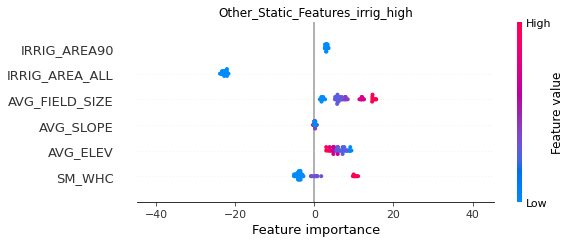

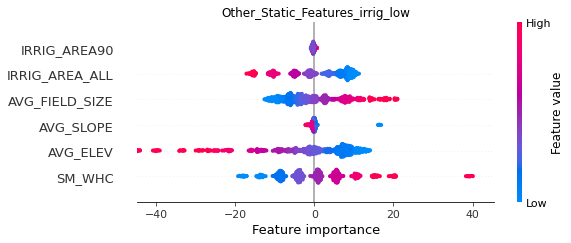

In [ ]:
ts_ft_imports = ft_imports['GradientShap']['ts']
static_ft_imports = ft_imports['GradientShap']['static']
trend_ft_imports = ft_imports['GradientShap']['trend']

other_static_fts = []
other_static_idxs = []
for idx, ft in enumerate(static_ft_names):
  if (('AEZ' not in ft) and ('STD' not in ft)):
    other_static_idxs.append(idx)
    other_static_fts.append(ft)

# High irrigated area
sel_region_ids = id_df[id_df['IDREGION'].isin(sel_regions1)]['id3'].unique()
sel_idxs = np.isin(Y_all[:, 1], sel_region_ids)
static_sel_imports = static_ft_imports[sel_idxs, :]
X_static_sel = X_static_all[sel_idxs, :]
beeswarmPlot(static_sel_imports[:, other_static_idxs], X_static_sel[:, other_static_idxs],
             other_static_fts,
             xlabel, ftval_color, axis_color,
             xmin, xmax, 'Other_Static_Features_irrig_high')

# High irrigated area
sel_region_ids = id_df[id_df['IDREGION'].isin(sel_regions2)]['id3'].unique()
sel_idxs = np.isin(Y_all[:, 1], sel_region_ids)
static_sel_imports = static_ft_imports[sel_idxs, :]
X_static_sel = X_static_all[sel_idxs, :]
beeswarmPlot(static_sel_imports[:, other_static_idxs], X_static_sel[:, other_static_idxs],
             other_static_fts,
             xlabel, ftval_color, axis_color,
             xmin, xmax, 'Other_Static_Features_irrig_low')

#### Beeswarm plots for North France

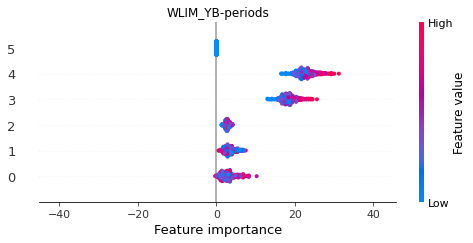

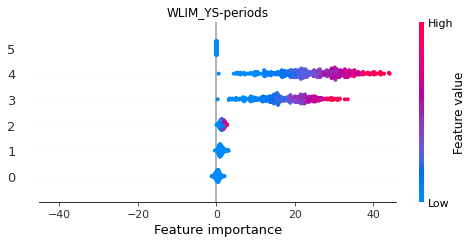

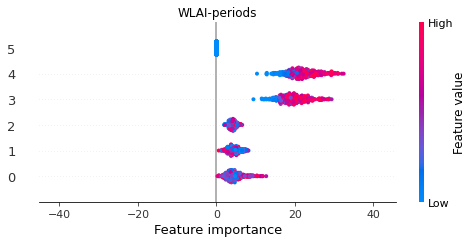

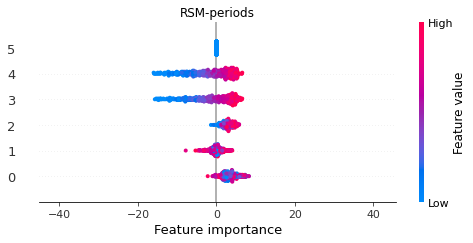

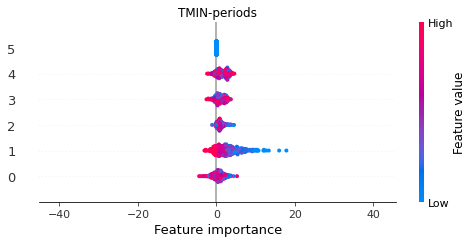

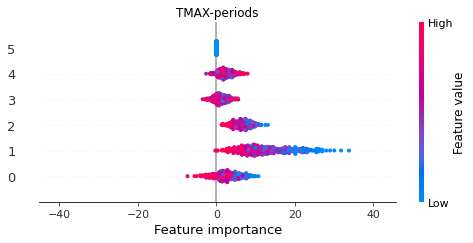

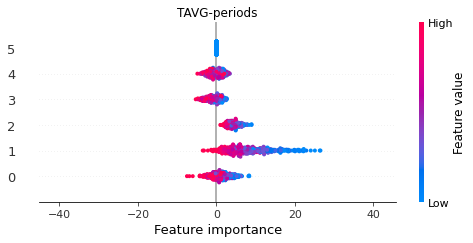

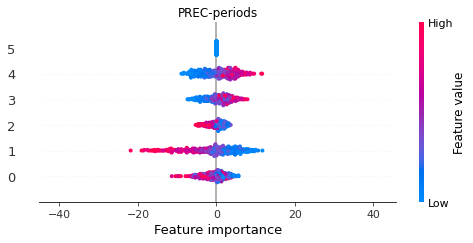

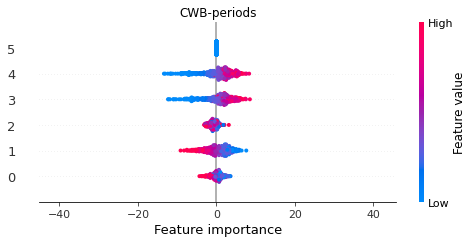

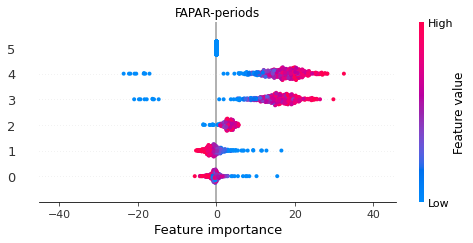

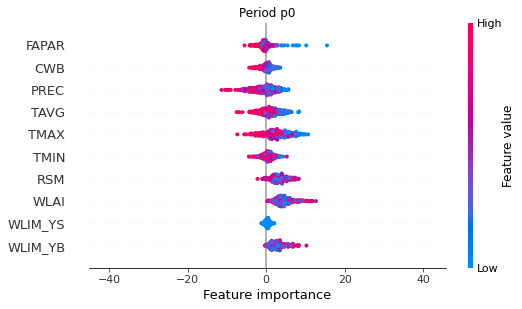

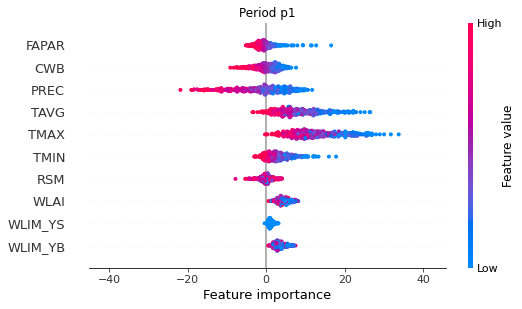

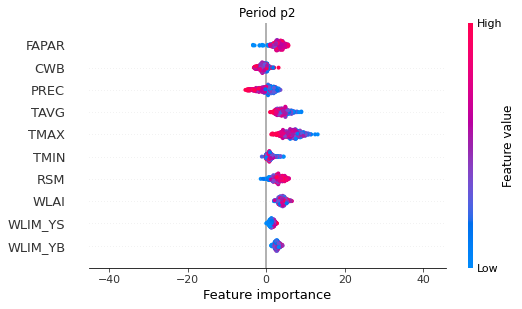

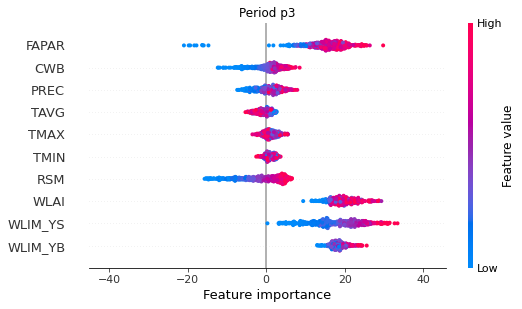

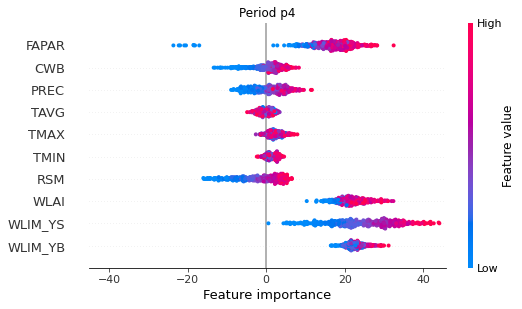

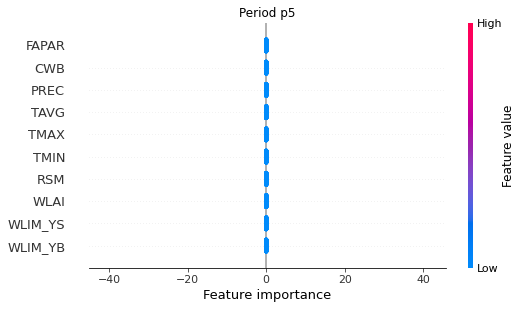

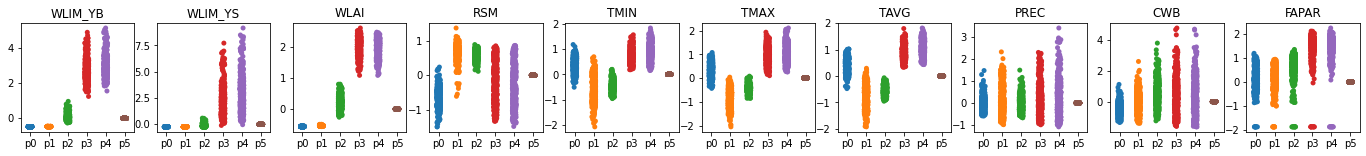

In [ ]:
country = cyp_config['country_code']

trend_static_attrs = np.append(trend_ft_imports, static_ft_imports, axis=1)
ts_import_min, ts_import_max = np.min(ts_ft_imports), np.max(ts_ft_imports)
trend_static_import_min, trend_static_import_max = np.min(trend_static_attrs), np.max(trend_static_attrs)
xmin = min(ts_import_min, trend_static_import_min)
xmax = max(ts_import_max, trend_static_import_max)

SW_FR_max_area_regions = ['FRB0', 'FRE2', 'FRF2', 'FRI3', 'FRG0', 'FRC1', 'FRE1', 'FRH0']
SW_FR_max_yield_regions = ['FRD1', 'FRD2', 'FRE1', 'FRE2', 'FRF1', 'FRF2', 'FR10', 'FRH0']

sel_regions1 = ['FR102', 'FR103', 'FR104', 'FR105', 'FR106', 'FR107', 'FR108', 'FRB01', 'FRB02',
                'FRB03', 'FRB04', 'FRB05', 'FRB06', 'FRC11', 'FRC12', 'FRC13', 'FRC14', 'FRC21',
                'FRC22', 'FRC23', 'FRC24', 'FRD11', 'FRD12', 'FRD13', 'FRD21', 'FRD22', 'FRE11',
                'FRE12', 'FRE21', 'FRE22', 'FRE23', 'FRF11', 'FRF12', 'FRF21', 'FRF22', 'FRF23',
                'FRF24', 'FRF31', 'FRF32', 'FRF33', 'FRF34', 'FRG02', 'FRG03', 'FRG04', 'FRH01',
                'FRI21', 'FRI22', 'FRI23', 'FRI34', 'FRK11', 'FRK21']

sel_regions2 = ['FRG01', 'FRG05', 'FRH02', 'FRH03', 'FRH04', 'FRI11', 'FRI12', 'FRI13', 'FRI14',
                'FRI15', 'FRI31', 'FRI32', 'FRI33', 'FRJ11', 'FRJ12', 'FRJ13', 'FRJ14', 'FRJ15',
                'FRJ21', 'FRJ22', 'FRJ23', 'FRJ24', 'FRJ25', 'FRJ26', 'FRJ27', 'FRJ28', 'FRK12',
                'FRK13', 'FRK14', 'FRK22', 'FRK23', 'FRK24', 'FRK25', 'FRK26', 'FRK27', 'FRK28',
                'FRL01', 'FRL02', 'FRL03', 'FRL04', 'FRL05', 'FRL06', 'FRM01', 'FRM02']

map_limits = {
      'xmin' : -5, 'xmax' : 10,
      'ymin' : 40, 'ymax' : 52,
}

id_df = combined_dfs['NUMERIC_IDS']
# North FR
sel_region_ids = id_df[id_df['IDREGION'].isin(sel_regions1)]['id3'].unique()
sel_idxs = np.isin(Y_all[:, 1], sel_region_ids)
X_ts_sel = X_ts_all[sel_idxs, :, :]
X_trend_sel = X_trend_all[sel_idxs, :]
X_static_sel = X_static_all[sel_idxs, :]

ts_sel_imports = ft_imports['combined']['ts'][sel_idxs, :, :]
static_sel_imports = ft_imports['combined']['static'][sel_idxs, :]
trend_sel_imports = ft_imports['combined']['trend'][sel_idxs, :]

beeswarmPlotsPerPeriod(ts_sel_imports, static_sel_imports, trend_sel_imports,
                       X_ts_sel, X_static_sel, X_trend_sel,
                       ts_ft_names, crop_cal, early_season_end,
                       xmin, xmax,
                       architecture)

#### Beeswarm plots for South France

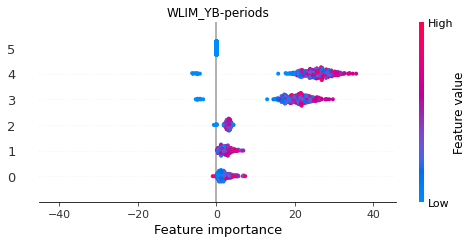

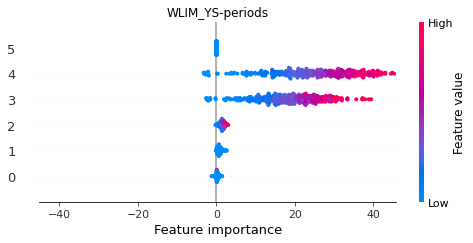

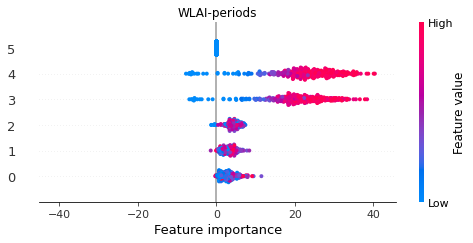

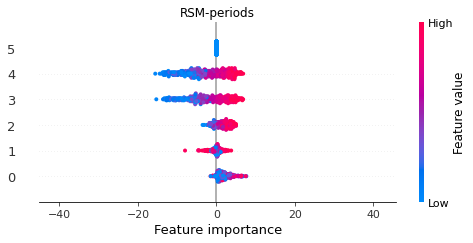

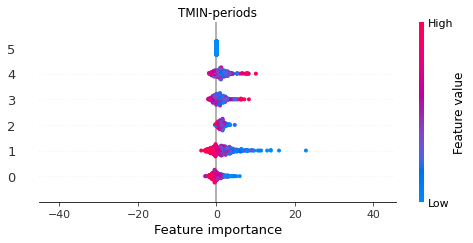

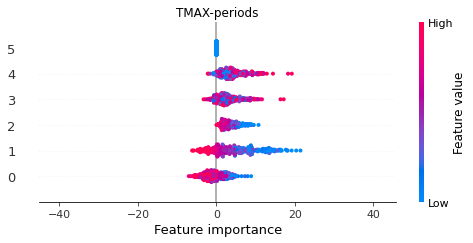

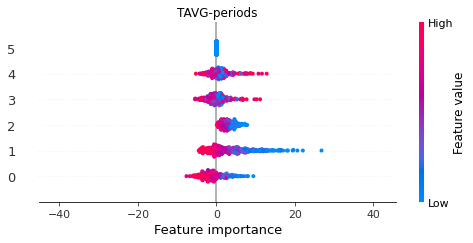

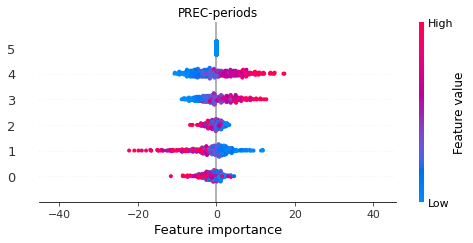

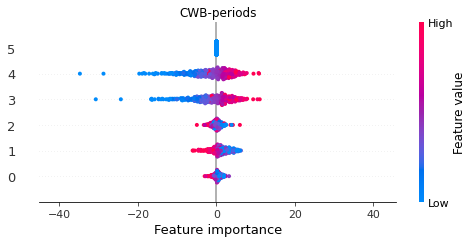

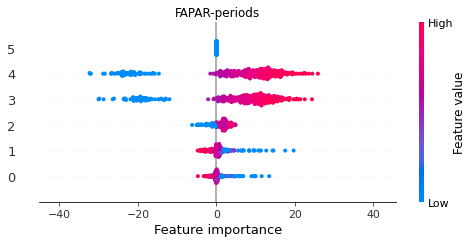

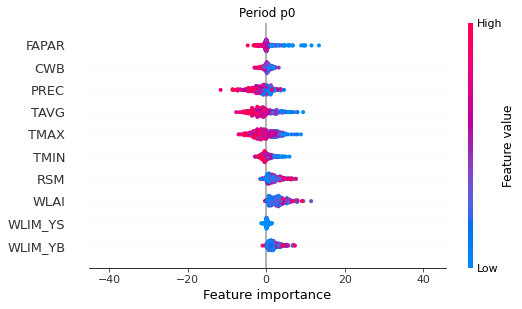

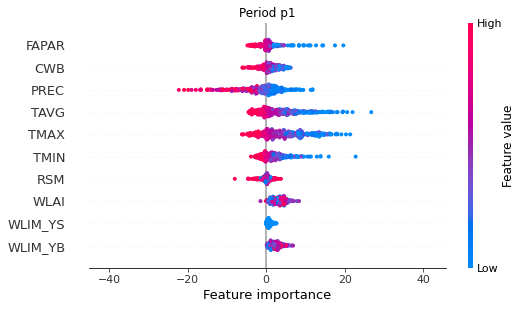

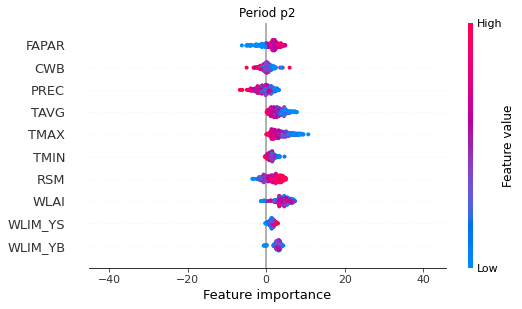

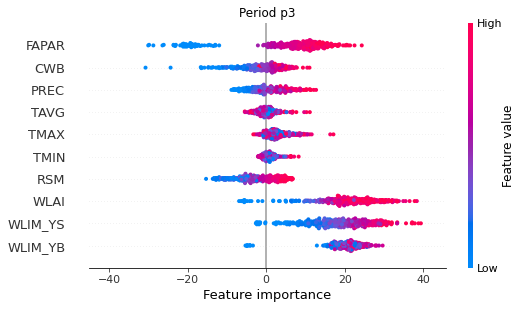

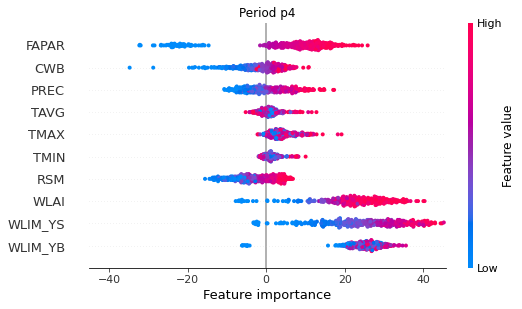

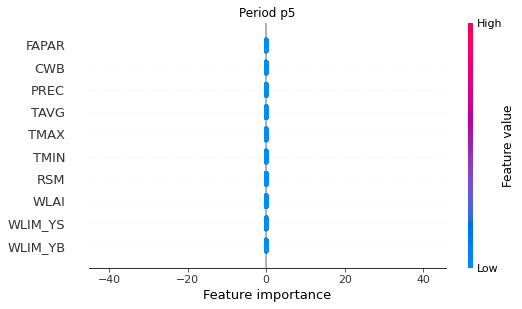

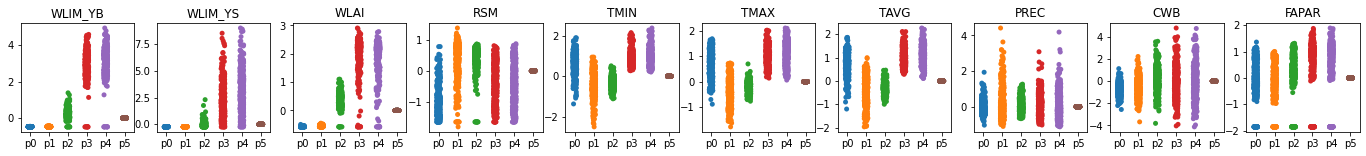

In [ ]:
# South FR
sel_region_ids = id_df[id_df['IDREGION'].isin(sel_regions2)]['id3'].unique()
sel_idxs = np.isin(Y_all[:, 1], sel_region_ids)
X_ts_sel = X_ts_all[sel_idxs, :, :]
X_trend_sel = X_trend_all[sel_idxs, :]
X_static_sel = X_static_all[sel_idxs, :]

ts_sel_imports = ft_imports['combined']['ts'][sel_idxs, :, :]
static_sel_imports = ft_imports['combined']['static'][sel_idxs, :]
trend_sel_imports = ft_imports['combined']['trend'][sel_idxs, :]

beeswarmPlotsPerPeriod(ts_sel_imports, static_sel_imports, trend_sel_imports,
                       X_ts_sel, X_static_sel, X_trend_sel,
                       ts_ft_names, crop_cal, early_season_end,
                       xmin, xmax,
                       architecture)

### Close file handle

In [ ]:
log_fh.close()

# change the last directory before running
# ! mv *.jpg drive/MyDrive/Wageningen\ PhD/Dilli\ -\ Deep\ Learning/saved-output/soft-wheat-FR-early-LSTM
# ! mv *.csv *.log drive/MyDrive/Wageningen\ PhD/Dilli\ -\ Deep\ Learning/saved-output/per-country-GM-LSTM-early-6